In [1]:
## import libraries
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from math import sqrt
from pybaseball import statcast
from pybaseball import playerid_reverse_lookup
from bs4 import BeautifulSoup
import requests
import lxml
import datetime
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from pybaseball import batting_stats_bref
from pybaseball import statcast_batter_expected_stats
from pybaseball import statcast_pitcher_expected_stats
from pybaseball import pitching_stats
from pybaseball import cache
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
from scipy.optimize import minimize
import pulp
from pulp import *
import datetime
import random
import pickle
import cProfile
import time
# import logistic regression and accuracy
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot
import statsmodels.api as sm
import math
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from meteostat import Point, Daily

import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

pd.options.display.max_columns = None
# cache.enable()

# get numbers as floats instead of ints
pd.options.display.float_format = '{:,.2f}'.format
optional = ''

In [2]:
# functions



# get today's date formatted as yyyy-mm-dd
def get_todays_date():
  # get the current date
  today = datetime.date.today()
  # format the date as yyyy-mm-dd
  date = today.strftime('%Y-%m-%d')
  # return the date
  return date

# programatically get the date
todays_date = get_todays_date()
year =  todays_date.split('-')[0]
month = todays_date.split('-')[1]
day = todays_date.split('-')[2]


def get_starters(date):
  # url for the website
  url = 'https://www.fangraphs.com/livescoreboard.aspx?date=' + date
  # get the website with bs
  response = requests.get(url)
  soup = BeautifulSoup(response.text, 'html.parser')
  tables = soup.find_all('table', class_='lineup')

  starting = []
  for table in tables:
    row = table.find_all('tr')
    for r in row:
      col = r.find_all('td')
      for c in col:
        a = c.find_all('a')
        if len(a) > 0:
          for i in a:
            name = i.text
            # change names which are not in the correct format
            if name == 'Cedric Mullins II':
              starting.append('Cedric Mullins')
            elif name == 'Mike Siani':
              starting.append('Michael Siani')
            elif name == 'Enrique Hernandez':
              starting.append('Kike Hernandez')
            elif name == 'J.J. Bleday':
              starting.append('JJ Bleday')
            elif name == 'D.J. Stewart':
              starting.append('DJ Stewart')
            else:
              starting.append(name)


  starting_df = pd.DataFrame(starting)
  return starting_df

            
def calculate_batting_fantasy_points(row):
  points = 0
  if row['events']=='single' or row['events'] == 'walk':
    points = points + 3
  elif row['events']=='double':
    points = points + 5
  elif row['events']=='triple':
    points = points + 8
  elif row['events']=='home_run':
    points = points + 10

  points = points + 4 * (row['post_bat_score']- row['bat_score'])

  return points

def calculate_pitching_fantasy_points(row):
  points = 0
  if row['events']=='strikeout':
    points = points + 2.75
  elif row['events']=='double_play' or row['events']=='grounded_into_double_play':
    points = points + 1.5
  elif row['events']=='strikeout_double_play' or row['events']=='strikeout_double_play':
    points = points + 3.5
  elif row['events']=='triple_play':
    points = points + 2.25
  elif row['events']=='single' or row['events'] == 'walk' or row['events'] == 'hit_by_pitch' or row['events'] == 'double' or row['events'] == 'triple' or row['events'] == 'home_run':
    points = points - .6
  else:
    points = points + .75

  points = points - 2 * (row['post_bat_score']- row['bat_score'])
  return points

def total_ball_movement(row):
  # return calculation if is a number else return 0
  x = row['pfx_x']
  z = row['pfx_z']
  if np.isnan(x):
    x = 0
  if np.isnan(z):
    z = 0
  total_movement = sqrt(x**2 + z**2)
  return total_movement

def batter_adjusted_plate_x(row):
  if row['stand'] == 'R':
    return row['plate_x']
  else:
    return -row['plate_x']

# sum batter stats per team for each game
def team_batters_games(df):
  df['team'] = np.where(df['inning_topbot'] == 'Top', df['away_team'], df['home_team'])
  team_batters = df.groupby(['game_pk', 'team'])['batter_fp'].sum().reset_index()
  return team_batters
    
# determine team based on inning_topbot
def team(row):
  if row['inning_topbot'] == 'Top':
    return row['away_team']
  else:
    return row['home_team']
  
# sum pitcher stats per team for each game
def team_pitchers_games(df):
  df['team'] = np.where(df['inning_topbot'] == 'Top', df['away_team'], df['home_team'])
  team_pitchers = df.groupby(['game_pk', 'team', 'player_name'])['pitcher_fp'].sum().reset_index()
  # get batters faced per pitcher
  batters_faced = df.groupby(['game_pk', 'team', 'player_name'])['batter'].count().reset_index()
  # merge the two dataframes
  team_pitchers = pd.merge(team_pitchers, batters_faced, on=['game_pk', 'team', 'player_name'])
  # for each game, select the pitcher with the most batters faced
  team_pitchers = team_pitchers.sort_values(by=['game_pk', 'batter'], ascending=False).drop_duplicates(subset=['game_pk', 'team'])
  return team_pitchers

# batter fantasy points by game
def batter_fp(df):
  df['batter_fp'] = df.apply(calculate_batting_fantasy_points, axis=1)

  # return points
  batter_game_fp = df.groupby(['game_pk', 'batter'])['batter_fp'].sum().reset_index()
  return batter_game_fp

# get number of plate appearances for each batter
def get_plate_appearances(df):
  plate_appearances = df.groupby(['batter'])['batter'].count().reset_index(name='pa')
  return plate_appearances

# filter the df to only the last x days
def last_x_days(df, x):
  # get the current date
  today = datetime.date.today()
  # get the date x days ago
  x_days_ago = today - datetime.timedelta(days=x)
  # convert to date
  x_days_ago = x_days_ago.strftime('%Y-%m-%d')
  # filter the df to only the last x days
  df = df[df['game_date'] > x_days_ago]
  return df

# fix player names to remove latin characters
def fix_player_names(df, column_name):
  df.loc[:, column_name] = df.loc[:, column_name].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
  # remove suffixes
  df = remove_suffixes(df, column_name)
  # change to all lower_case
  df[column_name] = df[column_name].str.lower()
  return df

# fix players names to move first name to the front and remove commas
def fix_player_names2(df, column_name):
  df[column_name] = df[column_name].str.split(',').str[1] + ' ' + df[column_name].str.split(',').str[0]
  df[column_name] = df[column_name].str.lower()

  return df

# get the frequency that a player has a stat between two values
def player_stat_frequency(df, player_name, column_name, lower, upper, is_batter=True):
  # filter the df to the selected player depending on if they are a batter or pitcher
  if is_batter:
    df = df[df['batter'] == player_name]
  else:
    df = df[df['player_name'] == player_name]

  # fix for when tyring to divide by zero
  if df.shape[0] == 0:
    return 0
  # find how often column name is between lower and upper
  freq = df[(df[column_name] >= lower) & (df[column_name] <= upper)].shape[0] / df.shape[0]
  return freq

# reformatting for merge
def convert_to_player_name(row):
  name = row['Name']
  # handle case for names with two spaces
  if len(name.split(' ')) > 2:
    return  name.split(' ')[1] + ' ' + name.split(' ')[2] + ', ' + name.split(' ')[0]
  else:
    return name.split(' ')[1] + ', ' + name.split(' ')[0]
    
# get data before date x
def data_before_date(df, y, m, d):
  x = y + "-" + m + "-" + d
  # filter the df to only the last x days
  df = df[df['game_date'] < x]
  # replace WSH with WAS and AZ with ARI
  df['home_team'] = df['home_team'].replace('WSH', 'WAS')
  df['away_team'] = df['away_team'].replace('WSH', 'WAS')
  df['home_team'] = df['home_team'].replace('AZ', 'ARI')
  df['away_team'] = df['away_team'].replace('AZ', 'ARI')
  return df


def get_batter_game_fp(pregame_info):
    # batter game fp
    batter_game_fp = batter_fp(pregame_info) # replaced batter_recent_info with df

    # get plate appearances for each batter
    plate_appearances = get_plate_appearances(pregame_info) # replaced batter_recent_info with df

    # get batter names
    batter_ids = batter_game_fp['batter'].unique()
    batter_name_id_pairs = playerid_reverse_lookup(batter_ids, key_type='mlbam')

    # rename key_mlbam to batter; capitalize first letter of  combine name_first and name_last, then combine name_first and name_last to batter_name
    batter_name_id_pairs = batter_name_id_pairs.rename(columns={'key_mlbam':'batter'})
    
    batter_name_id_pairs['batter_name'] = batter_name_id_pairs['name_first'].str.capitalize() + ' ' + batter_name_id_pairs['name_last'].str.capitalize()

    # merge batter names with batter game fp and plate_appearances
    batter_game_fp = pd.merge(batter_game_fp, batter_name_id_pairs, on='batter')
    batter_game_fp = pd.merge(batter_game_fp, plate_appearances, on='batter')

    # filter out batters with less than 14 plate appearances
    batter_game_fp = batter_game_fp[batter_game_fp['pa'] >= 14]

    # get 25th and 75th percentile outcomes for batter_fp for batters
    batter_game_fp['batter_fp'] = batter_game_fp['batter_fp'].astype(float)
    batter_game_fp['batter_fp_25'] = batter_game_fp.groupby('batter')['batter_fp'].transform(lambda x: x.quantile(.25))
    # batter_game_fp['batter_fp_25'] = batter_game_fp['batter_fp_25'].fillna(0)
    batter_game_fp['batter_fp_75'] = batter_game_fp.groupby('batter')['batter_fp'].transform(lambda x: x.quantile(.75))
    # batter_game_fp['batter_fp_75'] = batter_game_fp['batter_fp_75'].fillna(0)
    return batter_game_fp



def get_pitcher_exp(pregame_info):
    # get all qualified pitchers in 2024
    pitcher_exp = pitching_stats(2024, qual=10)
    pitcher_exp = pitcher_exp[['Name', 'WHIP', 'Stuff+', 'Location+', 'Pitching+']]

    # apply convert_to_player_name to Name column
    pitcher_exp['player_name'] = pitcher_exp.apply(lambda row: convert_to_player_name(row), axis=1)

    # get pitcher frequency of plate_z between 2 and 3, release_speed between 90 and 95, and release_spin_rate between 2090 and 2470
    pitcher_exp['hr_friendly_launch_speed_pitcher'] = pitcher_exp.apply(lambda row: player_stat_frequency(pregame_info, row['player_name'], 'launch_speed', 100, 150, is_batter=False), axis=1)
    pitcher_exp['hr_friendly_launch_angle_pitcher'] = pitcher_exp.apply(lambda row: player_stat_frequency(pregame_info, row['player_name'], 'launch_angle', 25, 31.25, is_batter=False), axis=1)
    return pitcher_exp


def get_batter_exp(pregame_info):
    # get all of this season's expected batting data so far
    batter_exp = statcast_batter_expected_stats(2024, 20)

    batter_exp = fix_player_names(batter_exp, 'last_name, first_name')
    batter_exp = fix_player_names2(batter_exp, 'last_name, first_name')
    # rename first column to batter_name and player_id to batter
    batter_exp = batter_exp.rename(columns={batter_exp.columns[0]: 'batter_name'})
    batter_exp = batter_exp.rename(columns={'player_id': 'batter'})

    # get batter frequency of launch speed between 100 and 109 and launch angle between 25 and 31.25
    batter_exp['hr_friendly_launch_speed_freq'] = batter_exp.apply(lambda row: player_stat_frequency(pregame_info, row['batter'], 'launch_speed', 100, 150), axis=1)
    batter_exp['hr_friendly_launch_angle_freq'] = batter_exp.apply(lambda row: player_stat_frequency(pregame_info, row['batter'], 'launch_angle', 25, 31.25), axis=1)
    return batter_exp


def get_pregame_batting_order(pregame_info):
    # get only the last game for each team
    #pregame_info = pregame_info.groupby(['game_pk', 'team']).apply(lambda x: x.iloc[-1]).reset_index(drop=True)
    # get only the first at bat for each batter per game
    pregame_batting_order = pregame_info.sort_values(by=['game_pk', 'at_bat_number'])
    pregame_batting_order = pregame_batting_order.groupby(['game_pk', 'batter']).apply(lambda x: x.iloc[0]).reset_index(drop=True)
    pregame_batting_order["batting_order"] = pregame_batting_order.groupby(['game_pk', 'team'])['at_bat_number'].rank()
    pregame_batting_order = pregame_batting_order[pregame_batting_order['batting_order'] <= 9]
    return pregame_batting_order

def trim(col):
    return col.str.strip()

def remove_suffixes(df, col):
    # df[col] = df[col].str.replace(' Jr.', '')
    # df[col] = df[col].str.replace(' Sr.', '')
    # df[col] = df[col].str.replace(' II', '')
    # df[col] = df[col].str.replace(' III', '')
    # df[col] = df[col].str.replace(' IV', '')

    #do the above without chained indexing
    df.loc[:, col] = df.loc[:, col].str.replace(' Jr.', '')
    df.loc[:, col] = df.loc[:, col].str.replace(' Sr.', '')
    df.loc[:, col] = df.loc[:, col].str.replace(' III', '')
    df.loc[:, col] = df.loc[:, col].str.replace(' II', '')
    df.loc[:, col] = df.loc[:, col].str.replace(' IV', '')

    # do the same for lowercase
    df.loc[:, col] = df.loc[:, col].str.replace(' jr.', '')
    df.loc[:, col] = df.loc[:, col].str.replace(' sr.', '')
    df.loc[:, col] = df.loc[:, col].str.replace(' iii', '')
    df.loc[:, col] = df.loc[:, col].str.replace(' ii', '')
    df.loc[:, col] = df.loc[:, col].str.replace(' iv', '')
    
    return df

def adjust_player_name(row):
  first_name = row['name_first']
  last_name = row['name_last']
  # fix names which are not in the correct format
  if last_name == 'vogelbach':
    return 'dan vogelbach'
  elif last_name == 'siani':
    return 'michael siani'
  elif first_name == 'j. d.':
    return 'j.d. martinez'
  elif row['batter_name'] == 'Michael A. Taylor':
    return 'michael taylor'

  return row['batter_name']

def filter_from_last_game_pks(df, last_game_pks):
  # remove rows in which team and game_pks pairs are not in last_game_pks
  for index, row in df.iterrows():
    if row['game_pk'] not in last_game_pks['game_pk']:
      df = df.drop(index)
    elif row['team'] not in last_game_pks['team']:
      df = df.drop(index)
    elif not(last_game_pks['team'].index_of(row['team']) == last_game_pks['game_pk'].index_of(row['game_pk'])):
      df = df.drop(index)
  return df


def get_past_date(days=30):
  # get the current date
  today = datetime.date.today()
  # get the date x days ago
  x_days_ago = today - datetime.timedelta(days=days)
  # convert to date
  x_days_ago = x_days_ago.strftime('%Y-%m-%d')
  return x_days_ago

def get_pitcher_averages_by_handedness(df):
  l_data = df[df['stand'] == 'L']
  r_data = df[df['stand'] == 'R']
  l_data = l_data.groupby(['Name', 'player_name']).mean(numeric_only=True).reset_index()
  r_data = r_data.groupby(['Name', 'player_name']).mean(numeric_only=True).reset_index()
  columns = l_data.columns
  columns = columns.drop(['Name', 'player_name'])
  l_data = add_suffix_to_columns(l_data, columns, '_vs_l_batter')
  r_data = add_suffix_to_columns(r_data, columns, '_vs_r_batter')
  pitcher_data = pd.merge(df, l_data, on=['Name', 'player_name'], how='left')
  pitcher_data = pd.merge(pitcher_data, r_data, on=['Name', 'player_name'], how='left')
  return pitcher_data

def get_batter_averages_by_handedness(df):
  l_data = df[df['p_throws'] == 'L']
  r_data = df[df['p_throws'] == 'R']
  l_data = l_data.groupby('batter').mean(numeric_only=True).reset_index()
  r_data = r_data.groupby('batter').mean(numeric_only=True).reset_index()
  columns = l_data.columns
  columns = columns.drop('batter')
  l_data = add_suffix_to_columns(l_data, columns, '_vs_l_pitcher')
  r_data = add_suffix_to_columns(r_data, columns, '_vs_r_pitcher')
  batter_data = pd.merge(df, l_data, on='batter', how='left')
  batter_data = pd.merge(batter_data, r_data, on='batter', how='left')
  return batter_data


def add_suffix_to_columns(df, columns, suffix):
  for col in columns:
    df = df.rename(columns={col: col + suffix})
  return df

def reduce_columns_by_handedness(df):
  # get handedness columns
  columns = df.columns
  # keep only columns containing '_vs_'
  columns = [col for col in columns if '_vs_' in col]

  for column in columns:
    # remove any that include _pitcher and _batter
    if ('_pitcher' in column) and ('_batter' in column):
      continue
    elif '_vs_l_pitcher' in column:
      new_column = column.replace('_vs_l_pitcher', '_by_pitcher_handedness')
      opposite_column = column.replace('_vs_l_pitcher', '_vs_r_pitcher')
      df[new_column] = np.where(df['p_throws'] == 'L', df[column], df[opposite_column])
    elif '_vs_l_batter' in column:
      new_column = column.replace('_vs_l_batter', '_by_batter_handedness')
      opposite_column = column.replace('_vs_l_batter', '_vs_r_batter')
      df[new_column] = np.where(df['stand'] == 'L', df[column], df[opposite_column])

  df = df.drop(columns, axis=1)
  return df

def select_best_features(df, target):
    # get only numeric columns
    df = df.select_dtypes(include=[np.number])
    bad_cols = ['avg_batter_fpts_last_10','team_batter_fp_pred_x', 'team_batter_fp_pred_y', 'pitcher_payoff', 'payoff', 'batter_drafted', 'batter_fpts', 'batter_fp', 'batter_fp_pred', 'team_batter_fp_pred', 'pitcher_fp', 'pitcher_drafted', 'pitcher_fpts', 'opp_pitcher_drafted_mean', 'opp_batter_drafted_mean', 'est_ba', 'batting_order_change', 'avg_batting_order_pitcher', 'est_ba_pitcher', 'batting_order_change_pitcher']
    for col in bad_cols:
      if col in df.columns:
        df = df.drop(col, axis=1)
    # function to select the best features for a model
    # # create a summary table
    # summary_table = pd.DataFrame(columns=['Feature', 'Coefficient', 'P-Value'])
    # # for each feature, calculate the p-value and coefficient
    # for i in range(df.shape[1]):
    #     feature = df.columns[i]
    #     X = df[feature]
    #     X = sm.add_constant(X).astype(float)
    #     model = sm.OLS(target, X).fit()
    #     summary_table = pd.concat([summary_table, pd.DataFrame({'Feature': [feature], 'Coefficient': [model.params[0]], 'P-Value': [model.pvalues[0]]})])
    # # select features with p-value < 0.05
    # threshold = 0.05
    # model_features = summary_table[summary_table['P-Value'] < threshold]['Feature']
    # while(len(model_features) == 0):
    #   threshold = threshold + 0.01
    #   model_features = summary_table[summary_table['P-Value'] < threshold]['Feature']
    # model_data = df[model_features]
    
    # # instead, just get the top 10 features
    # model_features = summary_table.sort_values(by='P-Value').head(10)['Feature']
    # model_data = df[model_features]

    # remove nas
    df = df.dropna()

    # standardize the data
    model_data = df
    model_data = (model_data - model_data.mean()) / model_data.std()

    # do a linear regression
    model = LinearRegression()
    model.fit(model_data, target)
    # get the coefficients
    coef = model.coef_
    
    threshold = 0.1
    # remove model_features with small coefficients
    model_features = model_data.columns[np.abs(coef) > threshold]
    while model_features.shape[0] == 0:
      threshold = threshold - 0.005
      model_features = model_data.columns[np.abs(coef) > threshold]
    model_data = model_data[model_features]

    return model_features, model_data


# define functions for analysis

def get_leaderboard_rank(leaderboard, lineup_fpts):
    # rather than iterate through leaderboard, start in the middle and go up or down based on lineup_fpts
    # if lineup_fpts is greater than the fpts of the middle row, go up; if less, go down
    
    while leaderboard.shape[0] > 0:
        mid = int(leaderboard.shape[0]/2)
        if lineup_fpts < leaderboard['Points'].iloc[mid]:
            leaderboard = leaderboard.iloc[mid:]
        elif lineup_fpts > leaderboard['Points'].iloc[mid]:
            leaderboard = leaderboard.iloc[:mid]
        else:
            return leaderboard['Rank'].iloc[mid]
        if leaderboard.shape[0] == 1:
            return leaderboard['Rank'].iloc[0]

    return leaderboard['Rank'].iloc[0]


def get_payoff(rank):
    payoffs = [50000, 20000, 8000, 5000, 4000, 3000, 2000, 2000, 1000, 1000, 700, 700, 500, 500, 500, 500, 500, 400, 400, 400]
    if rank <= 20:
        return payoffs[rank - 1]
    elif rank <= 100:
        return 150
    elif rank <= 300:
        return 50
    elif rank <= 3500:
        return 15
    else:
        return -15

In [3]:
# programatically get the date
todays_date = get_todays_date()
year =  todays_date.split('-')[0]
month = todays_date.split('-')[1]
day = todays_date.split('-')[2]

starters = get_starters(todays_date)
# print to csv
starters.to_csv('C:\\Users\\jorda\\Downloads\\starters.csv')

In [4]:
# get base df

# Get all Statcast data from 2024
df = statcast(start_dt='2024-03-28', end_dt=get_todays_date())

# Only include events
df = df.dropna(subset=['events', 'pitch_type', 'pfx_x', 'pfx_z', 'plate_x', 'stand', 'game_date', 'game_pk', 'at_bat_number', 'inning_topbot', 'away_team', 'home_team', 'post_bat_score', 'bat_score'])
df = fix_player_names(df, 'player_name')

# change AZ to ARI and WAS to WSH
df['home_team'] = df['home_team'].replace('AZ', 'ARI')
df['away_team'] = df['away_team'].replace('AZ', 'ARI')
df['home_team'] = df['home_team'].replace('WAS', 'WSH')
df['away_team'] = df['away_team'].replace('WAS', 'WSH')

# get more info
df['pitcher_fp'] = df.apply(lambda row: calculate_pitching_fantasy_points(row), axis=1)
df['batter_fp'] = df.apply(lambda row: calculate_batting_fantasy_points(row), axis=1)
df['total_ball_movement'] = df.apply(lambda row: total_ball_movement(row), axis=1)
df['batter_adjusted_plate_x'] = df.apply(lambda row: batter_adjusted_plate_x(row), axis=1)



This is a large query, it may take a moment to complete


100%|██████████| 132/132 [00:42<00:00,  3.08it/s]


In [5]:
# weather stuff - commenting out til it's ready

# # get stadium specific data, such as park factors and weather
# stadium_data = df[['home_team','pitcher_fp', 'batter_fp']].groupby('home_team').mean().reset_index()
# # rename
# stadium_data = stadium_data.rename(columns={'batter_fp':'avg_batter_fp_at_stadium', 'pitcher_fp':'avg_pitcher_fp_at_stadium'})

In [6]:
# # get latitude and longitude for each stadium
# coordinates={
#     'ARI': (33.4454, -112.0667),
#     'ATL': (33.7348, -84.3899),
#     'BAL': (39.2839, -76.6217),
#     'BOS': (42.3467, -71.0972),
#     'CHC': (41.9484, -87.6553),
#     'CIN': (39.0974, -84.5066),
#     'CLE': (41.4959, -81.6853),
#     'COL': (39.7559, -104.9942),
#     'CWS': (41.83, -87.6341),
#     'DET': (42.3391, -83.0487),
#     'HOU': (29.7573, -95.3555),
#     'KC': (39.0518, -94.4806),
#     'LAA': (33.8003, -117.8827),
#     'LAD': (34.0736, -118.2406),
#     'MIA': (25.7783, -80.2197),
#     'MIL': (43.0286, -87.9711),
#     'MIN': (44.9817, -93.2773),
#     'NYM': (40.7571, -73.8458),
#     'NYY': (40.8296, -73.9262),
#     'OAK': (37.7516, -122.2005),
#     'PHI': (39.9056, -75.1667),
#     'PIT': (40.4469, -80.0057),
#     'SD': (32.7076, -117.157),
#     'SEA': (47.5914, -122.3324),
#     'SF': (37.7786, -122.3893),
#     'STL': (38.6226, -90.1928),
#     'TB': (27.7683, -82.6486),
#     'TEX': (32.7512, -97.0828),
#     'TOR': (43.6414, -79.3894),
#     'WSH': (38.8731, -77.0074)
# }

# # get dates to get weather data
# game_info = df[['game_date', 'home_team']].drop_duplicates()

# # get tavg and prcp for each game
# game_info['tavg'] = 0
# game_info['prcp'] = 0

# for index, row in game_info.iterrows():
#     date = row['game_date']
#     team = row['home_team']
#     point = Point(coordinates[team][0], coordinates[team][1])
#     weather = Daily(point, start=date, end=date).fetch()
#     game_info.loc[index, 'tavg'] = weather['tavg'].mean()
#     game_info.loc[index, 'prcp'] = weather['prcp'].sum()

# # merge stadium data with game info
# game_info = pd.merge(game_info, stadium_data)
# game_info.head()

In [7]:
# #merge with df
# df = pd.merge(df, game_info, on=['game_date', 'home_team'])
# df.head()

In [8]:

def get_pregame_info(df, year, month, day):
    df = data_before_date(df, year, month, day)
    # get team batters
    team_batters = team_batters_games(df)

    # get team pitchers
    team_pitchers = team_pitchers_games(df)
    # get game_pks and game_dates
    game_info = df[['game_pk', 'game_date', 'away_team', 'home_team']].drop_duplicates()

    # combine team batters and team pitchers
    team_stats = pd.merge(team_batters, team_pitchers, on=['game_pk', 'team'])
    # merge with game info
    team_stats = pd.merge(team_stats, game_info, on='game_pk')

    # get 75th percentile outcomes for batter_fp and pitcher_fp for pitchers and teams
    team_stats['batter_fp'] = team_stats['batter_fp'].astype(float)
    team_stats['pitcher_fp'] = team_stats['pitcher_fp'].astype(float)

    # use a dataframe for team-based stats that only uses data from the last 10 days
    team_info_df = last_x_days(team_stats, 10)
    team_info_df['team_fp_75'] = team_info_df.groupby('team')['batter_fp'].transform(lambda x: x.quantile(.75))
    team_info_df['opp_pitcher_fp_75'] = team_info_df.groupby('team')['pitcher_fp'].transform(lambda x: x.quantile(.75))
    # team_info_df['team_fp_75'] = team_info_df['team_fp_75'].fillna(0)
    # team_info_df['opp_pitcher_fp_75'] = team_info_df['opp_pitcher_fp_75'].fillna(0)

    # pitchers can have full season stats
    team_stats['pitcher_fp_75'] = team_stats.groupby('player_name')['pitcher_fp'].transform(lambda x: x.quantile(.75))
    team_stats['opp_team_fp_75'] = team_stats.groupby('player_name')['batter_fp'].transform(lambda x: x.quantile(.75))
    # team_stats['pitcher_fp_75'] = team_stats['pitcher_fp_75'].fillna(0)
    # team_stats['opp_team_fp_75'] = team_stats['opp_team_fp_75'].fillna(0)

    # separate teams and pitchers 75th percentiles, and drop duplicates
    pitcher_outliers = team_stats[['player_name', 'pitcher_fp_75', 'opp_team_fp_75']].drop_duplicates()
    pitcher_outliers = fix_player_names(pitcher_outliers, 'player_name')
    team_outliers = team_info_df[['team', 'team_fp_75', 'opp_pitcher_fp_75']].drop_duplicates()

    #pitcher_outliers.to_csv('C:\\Users\\jorda\\Downloads\\pitcher_outliers.csv', index=False)
    team_outliers.to_csv('C:\\Users\\jorda\\Downloads\\team_outliers.csv', index=False)

    # use last_x_days to filter df for recency
    # batter_recent_info = last_x_days(df, 10)
    

    # finding recency bias to be problematic, so we will use all data

    # batter game fp
    batter_game_fp = batter_fp(df) # replaced batter_recent_info with df

    # get plate appearances for each batter
    plate_appearances = get_plate_appearances(df) # replaced batter_recent_info with df

    # get batter names
    batter_ids = batter_game_fp['batter'].unique()
    batter_name_id_pairs = playerid_reverse_lookup(batter_ids, key_type='mlbam')

    # rename key_mlbam to batter; capitalize first letter of  combine name_first and name_last, then combine name_first and name_last to batter_name
    batter_name_id_pairs = batter_name_id_pairs.rename(columns={'key_mlbam':'batter'})
    batter_name_id_pairs['batter_name'] = batter_name_id_pairs['name_first'].str.capitalize() + ' ' + batter_name_id_pairs['name_last'].str.capitalize()

    # merge batter names with batter game fp and plate_appearances
    batter_game_fp = pd.merge(batter_game_fp, batter_name_id_pairs)
    # batter_game_fp = pd.merge(batter_game_fp, plate_appearances)

    # filter out batters with less than 14 plate appearances
    #batter_game_fp = batter_game_fp[batter_game_fp['pa'] >= 14]

    # get 25th and 75th percentile outcomes for batter_fp for batters
    batter_game_fp['batter_fp'] = batter_game_fp['batter_fp'].astype(float)
    batter_game_fp['batter_fp_25'] = batter_game_fp.groupby('batter')['batter_fp'].transform(lambda x: x.quantile(.25))
    # batter_game_fp['batter_fp_25'] = batter_game_fp['batter_fp_25'].fillna(0)
    batter_game_fp['batter_fp_75'] = batter_game_fp.groupby('batter')['batter_fp'].transform(lambda x: x.quantile(.75))
    # batter_game_fp['batter_fp_75'] = batter_game_fp['batter_fp_75'].fillna(0)
    batter_game_fp['batter_fp_mean'] = batter_game_fp.groupby('batter')['batter_fp'].transform(lambda x: x.mean())

    # select only batter_name and batter_fp_75 and drop duplicates
    batter_outliers = batter_game_fp[['batter_name', 'batter_fp_25', 'batter_fp_75', 'batter_fp_mean', 'batter']].drop_duplicates()
    # batter_outliers.to_csv('C:\\Users\\jorda\\Downloads\\batter_outliers.csv', index=False)



    # get data for all qualified pitchers in 2024
    pitcher_exp = pitching_stats(2024, qual=1)
    pitcher_exp = pitcher_exp[['Name', 'WHIP', 'Stuff+', 'Location+', 'Pitching+']]

    # apply convert_to_player_name to Name column
#     pitcher_exp['player_name'] = pitcher_exp.apply(lambda row: convert_to_player_name(row), axis=1)
    # def convert_to_player_name(row):
    #     name = row['Name']
    #     # handle case for names with two spaces
    #     if len(name.split(' ')) > 2:
    #         return  name.split(' ')[1] + ' ' + name.split(' ')[2] + ', ' + name.split(' ')[0]
    #     else:
    #         return name.split(' ')[1] + ', ' + name.split(' ')[0]
    
    # replace function without using apply
    pitcher_exp['Name'] = pitcher_exp['Name'].str.lower()
    pitcher_exp['player_name'] = pitcher_exp.apply(lambda row: convert_to_player_name(row), axis=1)
    pitcher_exp['player_name'] = trim(pitcher_exp['player_name'])
    
    # get pitcher frequency of plate_z between 2 and 3, release_speed between 90 and 95, and release_spin_rate between 2090 and 2470
    pitcher_exp['hr_friendly_launch_speed_pitcher'] = pitcher_exp.apply(lambda row: player_stat_frequency(df, row['player_name'], 'launch_speed', 100, 109, is_batter=False), axis=1)
    pitcher_exp['hr_friendly_launch_angle_pitcher'] = pitcher_exp.apply(lambda row: player_stat_frequency(df, row['player_name'], 'launch_angle', 25, 31.25, is_batter=False), axis=1)

    # merge with pitcher_outliers
    pitcher_exp = pd.merge(pitcher_exp, pitcher_outliers)
    #pitcher_exp.to_csv('C:\\Users\\jorda\\Downloads\\pitcher_exp.csv', index=False)

    # get all of this season's expected batting data so far
    batter_exp = statcast_batter_expected_stats(2024, minPA=1)
    batter_exp = fix_player_names(batter_exp, 'last_name, first_name')
    batter_exp = fix_player_names2(batter_exp, 'last_name, first_name')
    # rename first column to batter_name and player_id to batter
    batter_exp = batter_exp.rename(columns={batter_exp.columns[0]: 'batter_name'})
    batter_exp = batter_exp.rename(columns={'player_id': 'batter'})

    # get batter frequency of launch speed between 100 and 109 and launch angle between 25 and 31.25
    batter_exp['hr_friendly_launch_speed_freq'] = batter_exp.apply(lambda row: player_stat_frequency(df, row['batter'], 'launch_speed', 100, 150), axis=1)
    batter_exp['hr_friendly_launch_angle_freq'] = batter_exp.apply(lambda row: player_stat_frequency(df, row['batter'], 'launch_angle', 25, 31.25), axis=1)
    # merge with batter_outliers

    batter_exp = pd.merge(batter_exp.drop('batter_name', axis=1), batter_outliers)
    #batter_exp.to_csv('C:\\Users\\jorda\\Downloads\\batter_exp.csv', index=False)
    #rename pa to year_pa
    batter_exp = batter_exp.rename(columns={'pa': 'year_pa'})

    # merge with plate_appearances
    batter_exp = pd.merge(batter_exp, plate_appearances)


    # summarize df
    batter_summary = batter_game_fp.groupby(['game_pk','batter'])['batter_fp'].sum().reset_index()

    # get only the first at bat for each batter per game
    batting_order = df.sort_values(by=['game_pk', 'at_bat_number'])
    batting_order = batting_order.groupby(['game_pk', 'batter']).apply(lambda x: x.iloc[0]).reset_index(drop=True)
    batting_order["batting_order"] = batting_order.groupby(['game_pk', 'team'])['at_bat_number'].rank()
    batting_order = batting_order[batting_order['batting_order'] <= 9]

    #pitcher_exp["player_name"] = pitcher_exp.apply(lambda row: convert_to_player_name(row), axis=1)

    model_data = pd.merge(batter_summary, batting_order)
    model_data = pd.merge(model_data, batter_exp)
    model_data = pd.merge(model_data, pitcher_exp).reset_index(drop=True)

    # make all names lowercase
    model_data['batter_name'] = model_data['batter_name'].str.lower()
    model_data['player_name'] = model_data['player_name'].str.lower()
    model_data['Name'] = model_data['Name'].str.lower()

    pitcher_summary = df.groupby(['game_pk', 'player_name'])['pitcher_fp'].sum().reset_index()
    pitcher_summary = fix_player_names(pitcher_summary, 'player_name')
    pitcher_summary = fix_player_names2(pitcher_summary, 'player_name')
    pitcher_summary['player_name'] = trim(pitcher_summary['player_name'])
    pitcher_summary.rename(columns={'player_name': 'Name'}, inplace=True)
    model_data = pd.merge(model_data.drop('pitcher_fp', axis=1), pitcher_summary)


    model_data = get_pitcher_averages_by_handedness(model_data)
    model_data = get_batter_averages_by_handedness(model_data)
    game_model_outcome_data = reduce_columns_by_handedness(model_data)
    game_model_outcome_data['batter_name'] = game_model_outcome_data['batter_name'].str.title()

    # fix names which have multiple capital letters
    # just making names lowercase via fix_names functions instead
    # corrections = {'Mj Melendez': 'MJ Melendez', 'Reese Mcguire':'Reese McGuire', 'Jeff Mcneil':'Jeff McNeil', 'Jd Martinez':'JD Martinez', 'Jj Bleday':'JJ Bleday', 'Jd Davis':'JD Davis', 'Paul Dejong':'Paul DeJong', 'Zach Mckinstry':'Zach McKinstry', 'Ryan Mcmahon':'Ryan McMahon', 'Cj Abrams':'CJ Abrams', 'Chas Mccormick':'Chas McCormick', 'Andrew Mccutchen':'Andrew McCutchen'}
    # for key in corrections:
    #     game_model_outcome_data['batter_name'] = game_model_outcome_data['batter_name'].replace(key, corrections[key])
        
    return game_model_outcome_data

game_model_outcome_data = get_pregame_info(df, year, month, day)


In [9]:
# get mean pitch coordinates
# mean_pitch_coordinates = df.groupby(['pitcher', 'player_name'])[['plate_x', 'plate_z', 'batter_adjusted_plate_x']].mean()
# mean_pitch_coordinates.rename(columns={'plate_x':'mean_pitcher_plate_x', 'plate_z':'mean_pitcher_plate_z', 'batter_adjusted_plate_x':'mean_pitcher_batter_adjusted_plate_x'}, inplace=True)
# mean_pitch_coordinates.to_csv("C:\\Users\\jorda\\Downloads\\pitch_coordinates.csv")
# mean_pitch_coordinates.head()
# df = statcast(start_dt='2024-03-28', end_dt=get_todays_date())

# # Only include events
# df = df.dropna(subset=['events', 'pitch_type', 'pfx_x', 'pfx_z', 'plate_x', 'stand', 'game_date', 'game_pk', 'at_bat_number', 'inning_topbot', 'away_team', 'home_team', 'post_bat_score', 'bat_score'])
# df = fix_player_names(df, 'player_name')

game_model_outcome_data.head()


,game_pk,batter,batter_fp,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,total_ball_movement,batter_adjusted_plate_x,team,batting_order,year,year_pa,bip,ba,est_ba,est_ba_minus_ba_diff,slg,est_slg,est_slg_minus_slg_diff,woba,est_woba,est_woba_minus_woba_diff,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,batter_name,batter_fp_25,batter_fp_75,batter_fp_mean,pa,Name,WHIP,Stuff+,Location+,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,pitcher_fp_75,opp_team_fp_75,pitcher_fp,game_pk_by_batter_handedness,batter_by_batter_handedness,batter_fp_by_batter_handedness,release_speed_by_batter_handedness,release_pos_x_by_batter_handedness,release_pos_z_by_batter_handedness,pitcher_by_batter_handedness,zone_by_batter_handedness,balls_by_batter_handedness,strikes_by_batter_handedness,game_year_by_batter_handedness,pfx_x_by_batter_handedness,pfx_z_by_batter_handedness,plate_x_by_batter_handedness,plate_z_by_batter_handedness,outs_when_up_by_batter_handedness,inning_by_batter_handedness,fielder_2_by_batter_handedness,vx0_by_batter_handedness,vy0_by_batter_handedness,vz0_by_batter_handedness,ax_by_batter_handedness,ay_by_batter_handedness,az_by_batter_handedness,sz_top_by_batter_handedness,sz_bot_by_batter_handedness,pitcher.1_by_batter_handedness,fielder_2.1_by_batter_handedness,fielder_3_by_batter_handedness,fielder_4_by_batter_handedness,fielder_5_by_batter_handedness,fielder_6_by_batter_handedness,fielder_7_by_batter_handedness,fielder_8_by_batter_handedness,fielder_9_by_batter_handedness,release_pos_y_by_batter_handedness,woba_value_by_batter_handedness,babip_value_by_batter_handedness,iso_value_by_batter_handedness,at_bat_number_by_batter_handedness,pitch_number_by_batter_handedness,home_score_by_batter_handedness,away_score_by_batter_handedness,bat_score_by_batter_handedness,fld_score_by_batter_handedness,post_away_score_by_batter_handedness,post_home_score_by_batter_handedness,post_bat_score_by_batter_handedness,post_fld_score_by_batter_handedness,delta_home_win_exp_by_batter_handedness,delta_run_exp_by_batter_handedness,total_ball_movement_by_batter_handedness,batter_adjusted_plate_x_by_batter_handedness,batting_order_by_batter_handedness,year_by_batter_handedness,year_pa_by_batter_handedness,bip_by_batter_handedness,ba_by_batter_handedness,est_ba_by_batter_handedness,est_ba_minus_ba_diff_by_batter_handedness,slg_by_batter_handedness,est_slg_by_batter_handedness,est_slg_minus_slg_diff_by_batter_handedness,woba_by_batter_handedness,est_woba_by_batter_handedness,est_woba_minus_woba_diff_by_batter_handedness,hr_friendly_launch_speed_freq_by_batter_handedness,hr_friendly_launch_angle_freq_by_batter_handedness,batter_fp_25_by_batter_handedness,batter_fp_75_by_batter_handedness,batter_fp_mean_by_batter_handedness,pa_by_batter_handedness,WHIP_by_batter_handedness,Stuff+_by_batter_handedness,Location+_by_batter_handedness,Pitching+_by_batter_handedness,pitcher_fp_75_by_batter_handedness,opp_team_fp_75_by_batter_handedness,pitc

Analysis of Past Slates

In [10]:


batter_predictive_pregame_features = ['batter_fp_mean','batting_order_by_pitcher_handedness', 'est_slg', 'est_woba', 
                                      'batter_fp_25_by_pitcher_handedness', 'batter_fp_75_by_pitcher_handedness', 'WHIP', 
                                      'Stuff+', 'Location+', 'Pitching+', 'hr_friendly_launch_speed_freq', 
                                      'hr_friendly_launch_angle_freq', 'hr_friendly_launch_speed_pitcher', 
                                      'hr_friendly_launch_angle_pitcher', 'batter_fp_25_by_batter_handedness', 'batter_fp_75_by_batter_handedness']
pitcher_predictive_pregame_features = ['batter_fp_mean', 'WHIP', 'Stuff+', 'Location+', 'Pitching+', 'est_slg', 'est_woba', 
                                       'batter_fp_25_by_batter_handedness', 'batter_fp_75_by_batter_handedness', 'hr_friendly_launch_speed_freq', 
                                       'hr_friendly_launch_angle_freq', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher', 
                                       'pitcher_fp_75_by_batter_handedness', 'opp_team_fp_75']

# set clip values for all features which will be used in predictive models
clip_values = {
    'batter_fp_mean': (0, 16),
    'batting_order_by_pitcher_handedness': (1, 9),
    'batting_order': (1, 9),
    'est_slg': (0.150, 0.550),
    'est_woba': (0.200, 0.400),
    'batter_fp_25_by_pitcher_handedness': (0, 7),
    'batter_fp_75_by_pitcher_handedness': (3, 22),
    'WHIP': (0.8, 2),
    'Stuff+': (85, 115),
    'Location+': (85, 115),
    'Pitching+': (85, 115),
    'hr_friendly_launch_speed_freq': (0, 0.35),
    'hr_friendly_launch_angle_freq': (0, 0.35),
    'hr_friendly_launch_speed_pitcher': (0, 0.35),
    'hr_friendly_launch_angle_pitcher': (0, 0.35),
    'batter_fp_25_by_batter_handedness': (0, 7),
    'batter_fp_75_by_batter_handedness': (3, 22),
    'pitcher_fp_75_by_batter_handedness': (7, 28),
    'opp_team_fp_75': (50, 100),
    'teams_in_game_pk': (2, 30),
    'is_of': (0, 1),
    'team_batter_fp_pred': (45,115),
    'pitcher_salary': (4000, 13000),
    'batter_salary': (2000, 7000),
    'pitcher_value': (0, 0.004),
    'team_batter_salary': (0, 60000),
    'team_avg_drafted': (0, 100)
}

Model R2:  0.02672177014769972
Model RMSE:  4.459648720425674


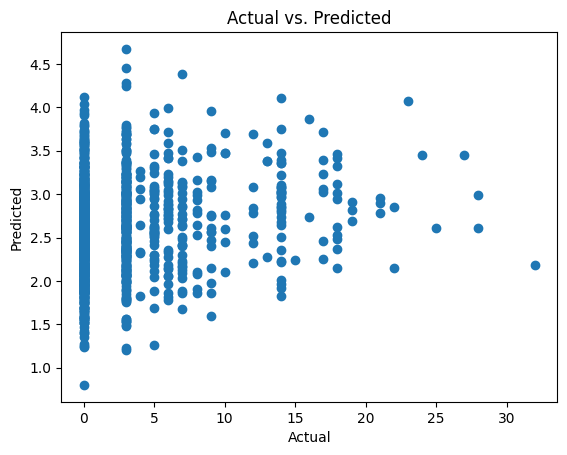

,week,batter,batter_fp,game_pk,pa,batting_order,est_slg,est_woba,batter_fp_25,batter_fp_75,WHIP,Stuff+,Location+,Pitching+,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,batter_fp_25_by_batter_handedness,batter_fp_75_by_batter_handedness,pitcher_fp_75_by_batter_handedness,opp_team_fp_75,pa_per_game
1885,19,592206,45.00,3,1392,4.33,0.43,0.32,0.00,11.00,1.30,87.67,100.67,97.33,0.16,0.06,0.20,0.06,1.27,9.32,17.23,83.17,464.00
5269,30,595879,40.00,4,1008,9.00,0.35,0.26,0.00,7.00,1.19,96.00,103.75,103.50,0.19,0.06,0.14,0.07,1.12,8.20,22.34,76.31,252.00
1976,19,656555,39.00,3,1044,5.33,0.42,0.31,3.00,13.00,1.12,97.67,103.67,102.67,0.13,0.06,0.15,0.07,1.16,8.56,21.54,73.42,348.00
297,14,595777,34.00,3,1350,6.00,0.47,0.37,3.00,12.00,1.31,103.33,103.33,104.33,0.19,0.07,0.18,0.07,1.07,8.67,16.70,76.08,450.00
4146,26,624424,33.00,3,990,6.33,0.44,0.32,0.00,10.00,1.24,97.00,100.33,98.67,0.18,0.05,0.14,0.07,0.68,8.44,15.83,80.00,330.00


In [11]:
# get batter results by week so we have a bigger sample size
weekly_results = game_model_outcome_data
weekly_results['game_date'] = pd.to_datetime(weekly_results['game_date'])
weekly_results['week'] = weekly_results['game_date'].dt.isocalendar().week
# divide week by 2 so we get biweekly info
weekly_results['week'] = weekly_results['week']
# round
weekly_results['week'] = weekly_results['week'].round()

# get sum of batter_fp and mean of everything else
aggregations = {
    'batter_fp': 'sum',
    'game_pk': 'count',
    'pa': 'sum',
    'batting_order': 'mean',
    'est_slg': 'mean',
    'est_woba': 'mean',
    'batter_fp_25': 'mean',
    'batter_fp_75': 'mean',
    'WHIP': 'mean',
    'Stuff+': 'mean',
    'Location+': 'mean',
    'Pitching+': 'mean',
    'hr_friendly_launch_speed_freq': 'mean',
    'hr_friendly_launch_angle_freq': 'mean',
    'hr_friendly_launch_speed_pitcher': 'mean',
    'hr_friendly_launch_angle_pitcher': 'mean',
    'batter_fp_25_by_batter_handedness': 'mean',
    'batter_fp_75_by_batter_handedness': 'mean',
    'pitcher_fp_75_by_batter_handedness': 'mean',
    'opp_team_fp_75': 'mean',
}
# get keys in clip_values
keys = list(aggregations.keys())
weekly_results = weekly_results[['week', 'batter'] + keys]
weekly_results = weekly_results.groupby(['week', 'batter']).agg(aggregations).reset_index()
# filter pa < 10
#weekly_results = weekly_results[weekly_results['pa'] >= 10]
# weekly_results['batter_fp_per_pa'] = weekly_results['batter_fp'] / weekly_results['pa'] # average by plate appearances
weekly_results['pa_per_game'] = weekly_results['pa'] / weekly_results['game_pk']
# weekly_results['batter_fp_per_game'] = weekly_results['batter_fp'] / weekly_results['game_pk']

# predict batter_fp based on the other aggregated factors
weekly_prediction_features = weekly_results.columns.drop(['week', 'batter', 'batter_fp', 'pa', 'game_pk'])
X_train, X_test, y_train, y_test = train_test_split(weekly_results[weekly_prediction_features], weekly_results['batter_fp'], test_size=0.2, random_state=0)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print('Model R2: ', r2)
print('Model RMSE: ', rmse)

# plot results
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()
weekly_results.sort_values(by='batter_fp', ascending=False).head()

In [12]:

def cluster_data(test_df=game_model_outcome_data, n_clusters=16):
  # remove non-numerics and batter_fp
  test_results = test_df[['batter_fp']]
  test_df = test_df[batter_predictive_pregame_features]
  test_model = KMeans(n_clusters=n_clusters)
  test_model.fit(test_df)
  test_df['cluster'] = test_model.labels_
  test_df['batter_fp'] = test_results

  # get number of times each cluster scores 0, 10+, and 20+
  test_df['zero_fp'] = np.where(test_df['batter_fp'] == 0, 1, 0)
  test_df['ten_fp'] = np.where(test_df['batter_fp'] >= 10, 1, 0)
  test_df['twenty_fp'] = np.where(test_df['batter_fp'] >= 20, 1, 0)

  # groupby cluster
  test_df = test_df.groupby('cluster').mean().reset_index()

  return test_df, test_model

clustered_data, clustered_model = cluster_data(game_model_outcome_data)


In [13]:
# identify best and worst clusters
best_clusters = clustered_data.sort_values(by='twenty_fp', ascending=False).head(round(len(clustered_data)*0.5))
best_clusters

,cluster,batter_fp_mean,batting_order_by_pitcher_handedness,est_slg,est_woba,batter_fp_25_by_pitcher_handedness,batter_fp_75_by_pitcher_handedness,WHIP,Stuff+,Location+,Pitching+,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,batter_fp_25_by_batter_handedness,batter_fp_75_by_batter_handedness,batter_fp,zero_fp,ten_fp,twenty_fp
14,14,7.53,3.55,0.44,0.34,2.43,11.10,1.35,84.16,99.97,96.03,0.18,0.06,0.16,0.06,1.19,8.72,1.87,0.68,0.06,0.00
6,6,5.27,6.35,0.37,0.29,0.52,7.40,1.42,93.01,95.10,93.03,0.14,0.06,0.15,0.07,1.00,8.33,1.73,0.69,0.04,0.00
9,9,6.17,5.27,0.40,0.31,1.10,8.81,1.18,96.02,105.09,104.15,0.15,0.06,0.16,0.06,1.02,8.64,1.55,0.74,0.04,0.00
4,4,5.00,6.64,0.36,0.29,0.28,6.95,1.28,99.10,98.80,99.01,0.13,0.06,0.14,0.06,1.02,8.47,1.38,0.71,0.03,0.00
13,13,7.73,3.61,0.45,0.34,2.49,11.46,1.29,93.09,99.25,97.30,0.18,0.07,0.15,0.07,1.17,8.79,1.56,0.69,0.04,0.00
5,5,6.06,5.47,0.40,0.31,1.12,8.68,1.16,116.84,99.94,104.33,0.15,0.06,0.13,0.06,1.12,8.68,1.31,0.75,0.04,0.00
11,11,4.82,6.87,0.36,0.29,0.16,6.66,1.26,91.87,100.18,98.18,0.13,0.06,0.15,0.07,1.01,8.46,1.21,0.75,0.02,0.00
0,0,6.23,5.26,0.40,0.31,1.21,8.98,1.11,107.77,103.75,105.86,0.15,0.06,0.14,0.06,1.12,8.71,1.38,0.72,0.03,0.00


In [14]:
def normalize_features(data):
    normalized_data = data.copy()
    features = []
    for feature in clip_values:
        if feature in normalized_data.columns:
            features.append(feature)
            normalized_data[feature] = normalized_data[feature].clip(clip_values[feature][0], clip_values[feature][1])
    normalized_data[features] = normalize(normalized_data[features])
    return normalized_data

# get batter and pitcher fp models using predictive features; make it a keras model
def get_normalized_model(data, target, features):
    normalized_data = data.copy()
    # clip values
    for feature in features:
        if feature in clip_values:
            normalized_data[feature] = normalized_data[feature].clip(clip_values[feature][0], clip_values[feature][1])

    # normalize data
    normalized_data[features] = normalize(normalized_data[features])

    return get_linear_model(normalized_data, target, features)



def get_linear_model(data, target, features):
    X = data[features]
    # standardize X
    X = (X - X.mean()) / X.std()
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print('Model R2: ', r2)
    print('Model RMSE: ', rmse)
    return model

def standardized_predict(model, df):
    
    df = (df - df.mean()) / df.std()
        # print standard deviations for each feature used in model_batter_payoff
    df.fillna(0, inplace=True)
    return model.predict(df)

In [15]:
game_model_outcome_data.head()

,game_pk,batter,batter_fp,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,total_ball_movement,batter_adjusted_plate_x,team,batting_order,year,year_pa,bip,ba,est_ba,est_ba_minus_ba_diff,slg,est_slg,est_slg_minus_slg_diff,woba,est_woba,est_woba_minus_woba_diff,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,batter_name,batter_fp_25,batter_fp_75,batter_fp_mean,pa,Name,WHIP,Stuff+,Location+,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,pitcher_fp_75,opp_team_fp_75,pitcher_fp,game_pk_by_batter_handedness,batter_by_batter_handedness,batter_fp_by_batter_handedness,release_speed_by_batter_handedness,release_pos_x_by_batter_handedness,release_pos_z_by_batter_handedness,pitcher_by_batter_handedness,zone_by_batter_handedness,balls_by_batter_handedness,strikes_by_batter_handedness,game_year_by_batter_handedness,pfx_x_by_batter_handedness,pfx_z_by_batter_handedness,plate_x_by_batter_handedness,plate_z_by_batter_handedness,outs_when_up_by_batter_handedness,inning_by_batter_handedness,fielder_2_by_batter_handedness,vx0_by_batter_handedness,vy0_by_batter_handedness,vz0_by_batter_handedness,ax_by_batter_handedness,ay_by_batter_handedness,az_by_batter_handedness,sz_top_by_batter_handedness,sz_bot_by_batter_handedness,pitcher.1_by_batter_handedness,fielder_2.1_by_batter_handedness,fielder_3_by_batter_handedness,fielder_4_by_batter_handedness,fielder_5_by_batter_handedness,fielder_6_by_batter_handedness,fielder_7_by_batter_handedness,fielder_8_by_batter_handedness,fielder_9_by_batter_handedness,release_pos_y_by_batter_handedness,woba_value_by_batter_handedness,babip_value_by_batter_handedness,iso_value_by_batter_handedness,at_bat_number_by_batter_handedness,pitch_number_by_batter_handedness,home_score_by_batter_handedness,away_score_by_batter_handedness,bat_score_by_batter_handedness,fld_score_by_batter_handedness,post_away_score_by_batter_handedness,post_home_score_by_batter_handedness,post_bat_score_by_batter_handedness,post_fld_score_by_batter_handedness,delta_home_win_exp_by_batter_handedness,delta_run_exp_by_batter_handedness,total_ball_movement_by_batter_handedness,batter_adjusted_plate_x_by_batter_handedness,batting_order_by_batter_handedness,year_by_batter_handedness,year_pa_by_batter_handedness,bip_by_batter_handedness,ba_by_batter_handedness,est_ba_by_batter_handedness,est_ba_minus_ba_diff_by_batter_handedness,slg_by_batter_handedness,est_slg_by_batter_handedness,est_slg_minus_slg_diff_by_batter_handedness,woba_by_batter_handedness,est_woba_by_batter_handedness,est_woba_minus_woba_diff_by_batter_handedness,hr_friendly_launch_speed_freq_by_batter_handedness,hr_friendly_launch_angle_freq_by_batter_handedness,batter_fp_25_by_batter_handedness,batter_fp_75_by_batter_handedness,batter_fp_mean_by_batter_handedness,pa_by_batter_handedness,WHIP_by_batter_handedness,Stuff+_by_batter_handedness,Location+_by_batter_handedness,Pitching+_by_batter_handedness,pitcher_fp_75_by_batter_handedness,opp_team_fp_75_by_batter_handedness,pitc

In [292]:
# # get draftkings salaries based on the date from "C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLBMMDDYYYY.csv"
# def get_pregame_info(df, year, month, day):
#     pregame_info = data_before_date(df, year, month, day)

#     pregame_batter_game_fp = get_batter_game_fp(pregame_info)
#     pregame_pitcher_exp = get_pitcher_exp(pregame_info)
#     pregame_batter_exp = get_batter_exp(pregame_info)

#     # summarize df
#     pregame_batter_summary = pregame_batter_game_fp.groupby(['game_pk','batter'])['batter_fp'].sum().reset_index()


#     pregame_batting_order = get_pregame_batting_order(pregame_info)

#     # get batter, game_pk, and batting order from pregame_batting_order
#     pregame_batting_order = get_pregame_batting_order(pregame_info)
#     pregame_batting_order = pregame_batting_order[['batter', 'game_pk', 'batting_order', 'player_name']]

#     # merge all pregame data
#     pregame_data = pd.merge(pregame_batter_summary, pregame_batting_order, on=['game_pk', 'batter'])
#     pregame_data = pd.merge(pregame_data, pregame_batter_exp, on='batter')

#     pregame_data = pd.merge(pregame_data, pregame_pitcher_exp, on='player_name')

#     # add pitcher_fp to pregame_data
#     pregame_data = pd.merge(pregame_data, pitcher_summary, on=['game_pk', 'player_name'])

#     pregame_batter_game_fp_mean = pregame_data[['batter_name', 'batting_order', 'batter_fp']]
#     pregame_batter_game_fp_mean = pregame_batter_game_fp_mean.groupby('batter_name').mean().reset_index()
#     pregame_batter_game_fp_mean = pregame_batter_game_fp_mean.rename(columns={'batting_order': 'avg_batting_order', 'batter_fp': 'avg_batter_fp'})
#     # merge the two dataframes
#     pregame_data = pd.merge(pregame_data, pregame_batter_game_fp_mean, on='batter_name')
#     # add a column for the change in batting order
#     pregame_data['batting_order_change'] = pregame_data['avg_batting_order'] - pregame_data['batting_order']

#     return pregame_data

def get_dk_salaries(year, month, day, optional=""):
    string = "C:\\Users\\jorda\\OneDrive\\Desktop\\DFS History\\MLB\\DKSalariesMLB" + month + day + year + optional + ".csv"
    salaries = pd.read_csv(string)
    salaries['Name'] = salaries['Name'].str.lower()
    return salaries

def get_fd_variables(all_variables):
    string = "C:\\Users\\jorda\\Downloads\\FDSalariesMLB.csv"
    salaries = pd.read_csv(string)
    salaries = fix_player_names(salaries, 'Nickname')
    # rename Salary to fd_salary
    salaries = salaries.rename(columns={'Nickname':'Name_lower', 'Salary': 'fd_salary', 'Id': 'fd_id', 'Position':'fd_position'})[['Name_lower', 'fd_salary', 'fd_id', 'fd_position']]
    # merge with all_variables
    all_variables = pd.merge(all_variables, salaries)
    return all_variables
    


# get contest standings based on the date from "C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandingsMMDDYYYY.csv"
def get_contest_standings(year, month, day):
    string = "C:\\Users\\jorda\\OneDrive\\Desktop\\DFS History\\MLB\\MLBContestStandings" + month + day + year + ".csv"
    print('Getting contest standings for ', month, '/', day, '/', year)
    contest_data = pd.read_csv(string)
    return contest_data

def get_contest_results(contest_data):
    contest_player_results = contest_data[['Player', '%Drafted', 'FPTS']]
    # drop nas
    # contest_player_results = contest_player_results.dropna()
    # convert %Drafted to a float
    contest_player_results['%Drafted'] = contest_player_results['%Drafted'].str.replace('%', '').astype(float)
    # convert FPTS to a float
    contest_player_results['FPTS'] = contest_player_results['FPTS'].astype(float)
    # fix player names
    contest_player_results = fix_player_names(contest_player_results, 'Player')
    # remove suffixes
    contest_player_results = remove_suffixes(contest_player_results, 'Player')
    return contest_player_results

def get_leaderboard(contest_data):
    leaderboard = contest_data[['Rank', 'Points', 'Lineup']]
    leaderboard = leaderboard.dropna()
    # convert Points to a float
    leaderboard['Points'] = leaderboard['Points'].astype(float)
    return leaderboard

# get files in folder "C:\\Users\\jorda\\OneDrive\\Desktop\\DFS History\\MLB\\" and return their names
def get_files():
    files = []
    for file in os.listdir("C:\\Users\\jorda\\OneDrive\\Desktop\\DFS History\\MLB\\"):
        if file.endswith(".csv"):
            files.append(file)
    return files

In [17]:
this_day_statcast = statcast(start_dt=year + '-' + month + '-' + day, end_dt=year + '-' + month + '-' + day)
this_day_statcast

This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length


In [18]:
get_dk_salaries(year, month, day, "")

,Position,Name + ID,Name,ID,Roster Position,Salary,Game Info,TeamAbbrev,AvgPointsPerGame
0,SP,Chris Sale (35327731),chris sale,35327731,P,10400,MIL@ATL 08/06/2024 07:20PM ET,ATL,24.55
1,RP,Tyler Glasnow (35328485),tyler glasnow,35328485,P,10400,PHI@LAD 08/06/2024 10:10PM ET,LAD,22.72
2,SP,Jack Flaherty (35328486),jack flaherty,35328486,P,10400,PHI@LAD 08/06/2024 10:10PM ET,LAD,22.57
3,SP,Justin Verlander (35328487),justin verlander,35328487,P,10100,HOU@TEX 08/06/2024 08:05PM ET,HOU,14.84
4,SP,Clarke Schmidt (35328488),clarke schmidt,35328488,P,9900,LAA@NYY 08/06/2024 07:05PM ET,NYY,19.23
...,...,...,...,...,...,...,...,...,...
1324,SS,Carson Williams (35328309),carson williams,35328309,SS,2000,TB@STL 08/06/2024 07:45PM ET,TB,0.00
1325,OF,Joshua Baez (35328311),joshua baez,35328311,OF,2000,TB@STL 08/06/2024 07:45PM ET,STL,0.00
1326,C,Rob Brantly (35328331),rob brantly,35328331,C,2000,TB@STL 08/06/2024 07:45PM ET,TB,0.00
1327,SS,Carlos Colmenares (35328345),carlos colmenares,35328345,SS,2000,TB@STL 08/06/2024 07:45PM ET,TB,0.00


In [19]:

def compile_data_from_date(df, year, month, day):
    # merge dk salaries with pregame_data by batter_name
    salaries = get_dk_salaries(year, month, day, "")
    # select Name, Roster Position, batter_salary, and TeamAbbrev from salaries
    salaries = salaries[['Name', 'Roster Position', 'Salary', 'TeamAbbrev']]

    # get all players who are not Roster Position P
    hitter_salaries = salaries[salaries['Roster Position'] != 'P']

    # get all players who are Roster Position P
    pitcher_salaries = salaries[salaries['Roster Position'] == 'P']

    # only keep Name and batter_salary for pitchers
    pitcher_salaries = pitcher_salaries[['Name', 'Salary', 'TeamAbbrev']]
    # rename salary to pitcher_salary
    pitcher_salaries = pitcher_salaries.rename(columns={'Salary': 'pitcher_salary', 'Name':'pitcher_name', 'TeamAbbrev':'pitcher_team'})

    # rename hitter_salaries Name to batter_name
    hitter_salaries = hitter_salaries.rename(columns={'Name': 'batter_name'})

    this_day_statcast = statcast(start_dt=year + '-' + month + '-' + day, end_dt=year + '-' + month + '-' + day)
    this_day_statcast['player_name'] = this_day_statcast['player_name'].str.lower()
    # set 'team' as home_team if inning_topbot is 'Bot', and away_team if 'Top'
    this_day_statcast['team'] = this_day_statcast.apply(team, axis=1)
    # get only the first at bat for each batter per game
    this_day_batting_order = this_day_statcast.sort_values(by=['game_pk', 'at_bat_number'])
    this_day_batting_order = this_day_batting_order.groupby(['game_pk', 'batter']).apply(lambda x: x.iloc[0]).reset_index(drop=True)
    this_day_batting_order["batting_order"] = this_day_batting_order.groupby(['game_pk', 'team'])['at_bat_number'].rank()
    this_day_batting_order = this_day_batting_order[this_day_batting_order['batting_order'] <= 9]

    # get batter_name for this_day_batting_order
    batter_ids = this_day_batting_order['batter'].unique()
    batter_name_id_pairs = playerid_reverse_lookup(batter_ids, key_type='mlbam')
    batter_name_id_pairs = batter_name_id_pairs.rename(columns={'key_mlbam':'batter'})
    batter_name_id_pairs['batter_name'] = batter_name_id_pairs['name_first'].str.lower() + ' ' + batter_name_id_pairs['name_last'].str.lower()

    this_day_batting_order
    # merge this_day_batting_order with batter_name_id_pairs
    this_day_batting_order = pd.merge(this_day_batting_order, batter_name_id_pairs)

    # get pitcher_name for this_day_batting_order based on player_name
    this_day_batting_order = fix_player_names(this_day_batting_order, 'player_name')
    this_day_batting_order= fix_player_names2(this_day_batting_order, 'player_name')
    # rename player_name to Name
    this_day_batting_order = this_day_batting_order.rename(columns={'player_name': 'Name'})
    # merge with pitcher_salaries
    bo_with_salaries = pd.merge(this_day_batting_order, hitter_salaries)
    # only keep Name, team, batting_order, batter_name, Roster Position, Salary
    bo_with_salaries = bo_with_salaries[['Name', 'team', 'batting_order', 'batter_name', 'Roster Position', 'Salary']]
    bo_with_salaries = bo_with_salaries.rename(columns={'Salary': 'batter_salary'})
    bo_with_salaries = bo_with_salaries.rename(columns={'Name': 'pitcher_name'})
    # trim pitcher_name in bo_with_salaries
    bo_with_salaries['pitcher_name'] = trim(bo_with_salaries['pitcher_name'])
    # merge with pitcher_salaries
    new_merge = pd.merge(bo_with_salaries, pitcher_salaries)


    # use historic data to determine hitter and pitcher quality, with the goal of predicting batter_fp and pitcher_fp
    pregame_data = get_pregame_info(df, year, month, day)

    # get pitcher names, plus WHIP, Pitching+
    pitcher_names = pregame_data[['player_name', 'WHIP', 'Pitching+', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher']]
    # rename player_name to pitcher_name
    pitcher_names = pitcher_names.rename(columns={'player_name': 'pitcher_name'})
    # fix names
    pitcher_names = fix_player_names(pitcher_names, 'pitcher_name')
    pitcher_names = fix_player_names2(pitcher_names, 'pitcher_name')
    # trim names
    pitcher_names['pitcher_name'] = trim(pitcher_names['pitcher_name'])
    # drop duplicates
    pitcher_names = pitcher_names.drop_duplicates()
    # get batter names, plus 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq', 'avg_batting_order', 'avg_batter_fp'
    batter_names = pregame_data[['batter_name', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']]
    # trim names
    batter_names['batter_name'] = trim(batter_names['batter_name'])
    # drop duplicates
    batter_names = batter_names.drop_duplicates()

    new_merge['pitcher_name'] = new_merge['pitcher_name'].str.lower()
    pitcher_names['pitcher_name'] = pitcher_names['pitcher_name'].str.lower()
    batter_names['batter_name'] = batter_names['batter_name'].str.lower()

    # merge with new_merge by names to set up predictions
    all_data = pd.merge(new_merge, pitcher_names)
    all_data = pd.merge(all_data, batter_names)
    
    cols_allowed = all_data.columns
    # remove cols_allowed which are not in pregame_data
    cols_allowed = [col for col in cols_allowed if col in pregame_data.columns]
    # establish a model for each batter depending on the quality of pitchers they are facing
    target = pregame_data['batter_fp']
    # select only the relevant columns
    batter_model_features, batter_model_data = select_best_features(pregame_data[cols_allowed], target)
    batter_model = get_linear_model(pregame_data, ['batter_fp'], batter_model_features)
    # predict batter_fp and pitcher_fp for all_data
    all_data['batter_fp_pred'] = standardized_predict(batter_model, all_data[batter_model_features])

    
    pitcher_data = all_data.groupby('pitcher_name').mean(numeric_only=True).reset_index()

    # establish a model for each pitcher depending on the quality of batters they are facing
    
    target = pregame_data['pitcher_fp']
    # select only the relevant columns
    pitcher_model_features, pitcher_model_data = select_best_features(pregame_data[cols_allowed], target)
    pitcher_model = get_linear_model(pregame_data, ['pitcher_fp'], pitcher_model_features)
    # predict batter_fp and pitcher_fp for all_data
    pitcher_data['pitcher_fp_pred'] = standardized_predict(pitcher_model, pitcher_data[pitcher_model_features])

    # all_players_plus_data['teams_in_game_pk'] = teams_in_game_pk.size
    teams_in_game_pk = all_data['team'].unique()
    all_data['teams_in_game_pk'] = teams_in_game_pk.size
    # get is_of
    all_data['is_of'] = all_data['Roster Position'].apply(lambda x: 1 if x == 'OF' else 0)
    # get team_batter_fp_pred
    team_batter_fp_pred = all_data.groupby('team')['batter_fp_pred'].mean().reset_index()
    team_batter_fp_pred = team_batter_fp_pred.rename(columns={'batter_fp_pred': 'team_batter_fp_pred'})
    all_data = pd.merge(all_data, team_batter_fp_pred, on='team')

    # select only pitcher_name and pitcher_fp_pred, then merge with all_data
    pitcher_data = pitcher_data[['pitcher_name', 'pitcher_fp_pred']]
    all_data = pd.merge(all_data, pitcher_data)

    # use leaderboard and results to determine the success of each player
    contest_data = get_contest_standings(year, month, day)
    contest_player_results = get_contest_results(contest_data)
    leaderboard = get_leaderboard(contest_data)
    leaderboard['payoff'] = leaderboard.apply(lambda x: get_payoff(x['Rank']), axis=1)

    # Establish payoffs for each player based on their performance as well as their appearance in the leaderboard's top 100
    # get the top 20 lineups
    #top_20 = leaderboard.head(20)
    # get all players in the all_data dataframe
    all_players = all_data['batter_name'].unique()
    # get pitchers as well
    pitchers = all_data['pitcher_name'].unique()
    # combine those vectors
    all_players = np.concatenate((all_players, pitchers))

    # enumerate payoffs for placements in the top 20
    #payoffs = [50000, 20000, 8000, 5000, 4000, 3000, 2000, 2000, 1000, 1000, 700, 700, 500, 500, 500, 500, 500, 400, 400, 400]

    # create a dictionary for player payoffs
    player_payoffs = {}

    # for each lineup in top_20, look for each player in all_players and increase their payoff by the corresponding value in payoffs if found
    for row in leaderboard.iterrows():
        lineup = row[1]['Lineup']
        payoff = row[1]['payoff']
        for player in lineup.split(','):
            if player in all_players:
                if player in player_payoffs:
                    player_payoffs[player] += payoff
                else:
                    player_payoffs[player] = payoff

    # for each player in all_players, if they are not in player_payoffs, set their payoff to 0
    for player in all_players:
        if player not in player_payoffs:
            player_payoffs[player] = 0

    # add player payoffs to all_data
    all_data['payoff'] = all_data['batter_name'].map(player_payoffs)

    # add pitcher payoffs to all_data
    all_data['pitcher_payoff'] = all_data['pitcher_name'].map(player_payoffs)


    # add contest results to all_data
    all_data_with_results = pd.merge(all_data, contest_player_results, left_on='batter_name', right_on='Player', how='left')
    # rename %drafted to batter_drafted and FPTS to batter_fpts
    all_data_with_results = all_data_with_results.rename(columns={'%Drafted': 'batter_drafted', 'FPTS': 'batter_fpts'})
    # drop Player column
    all_data_with_results = all_data_with_results.drop(columns=['Player'])

    # do the same for pitchers
    all_data_with_results = pd.merge(all_data_with_results, contest_player_results, left_on='pitcher_name', right_on='Player', how='left')
    all_data_with_results = all_data_with_results.rename(columns={'%Drafted': 'pitcher_drafted', 'FPTS': 'pitcher_fpts'})
    all_data_with_results = all_data_with_results.drop(columns=['Player'])

    # divide payoff and pitcher_payoff by (leaderboard_size * percent_drafted) to get payoff per usage
    leaderboard_size = leaderboard.shape[0]
    all_data_with_results['payoff'] = all_data_with_results['payoff'] / (leaderboard_size * all_data_with_results['batter_drafted']/100)
    all_data_with_results['pitcher_payoff'] = all_data_with_results['pitcher_payoff'] / (leaderboard_size * all_data_with_results['pitcher_drafted']/100)

    # get mean drafted % by team for pitchers
    team_pitcher_drafted = all_data_with_results.groupby('team')['pitcher_drafted'].mean().reset_index()
    team_pitcher_drafted = team_pitcher_drafted.rename(columns={'pitcher_drafted': 'opp_pitcher_drafted_mean'})
    all_data_with_results = pd.merge(all_data_with_results, team_pitcher_drafted)

    # get mean drafted % by pitcher_team for batters
    team_batter_drafted = all_data_with_results.groupby('pitcher_team')['batter_drafted'].mean().reset_index()
    team_batter_drafted = team_batter_drafted.rename(columns={'batter_drafted': 'opp_batter_drafted_mean'})
    all_data_with_results = pd.merge(all_data_with_results, team_batter_drafted)

    # add a column for team_batter_fp_pred
    team_batter_fp_pred = all_data_with_results.groupby('team')['batter_fp_pred'].sum().reset_index()
    team_batter_fp_pred = team_batter_fp_pred.rename(columns={'batter_fp_pred': 'team_batter_fp_pred'})
    all_data_with_results = all_data_with_results.drop(columns=['team_batter_fp_pred'])
    all_data_with_results = pd.merge(all_data_with_results, team_batter_fp_pred)
    
    # X = all_data_with_results[['avg_batter_fp', 'teams_in_game_pk', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq', 'hr_friendly_launch_angle_pitcher', 'hr_friendly_launch_speed_pitcher', 'is_of','team_batter_fp_pred']]
    # y = all_data_with_results['batter_drafted']
    
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # # build a linear regression model to predict the ownership of each batter
    # model_batter_drafted = LinearRegression()
    # model_batter_drafted.fit(X_train, y_train)
    # y_pred = model_batter_drafted.predict(X_test)
    # r2 = r2_score(y_test, y_pred)
    # rmse = sqrt(mean_squared_error(y_test, y_pred))
    # print('Ownership Model R2: ', r2)
    # print('Ownership Model RMSE: ', rmse)

    return all_data_with_results


def get_opposing_team(team, game_info):
    # if game info includes Postponed or game_info dtype is float return None
    if game_info == 'Postponed':
        return None
    if type(game_info) == float:
        return None
    # get the opposing team from the game_info
    matchup = game_info.split(' ')[0]
    teams = matchup.split('@')
    if teams[0] == team:
        return teams[1]
    else:
        return teams[0]


In [20]:
# def get_all_data_from_draftkings():
    # run compile_data_from_date for all dates and combine the results into a single dataframe
if True:
    all_data = pd.DataFrame()
    files = get_files()

    for file in files:
        # proceed if file name is like 'MLBContestStandingsMMDDYYYY.csv' and 'DKSalariesMLBMMDDYYYY.csv'
        if 'MLBContestStandings' in file:
            date = file[-12:-4]
            m = str(date[0:2])
            d = str(date[2:4])
            y = str(date[4:8])
            new_data = compile_data_from_date(df, y, m, d)
            new_data['game_date'] = y + '-' + m + '-' + d
            all_data = pd.concat([all_data, new_data])
            print(all_data.shape)

    # drop NaNs
    all_data = all_data.dropna()
    # add a column with value 1 if Roster Position contains OF or /
    all_data['is_of'] = all_data['Roster Position'].str.contains('OF|/').astype(int)

    # save all_data to csv in case of loss
    all_data.to_csv('C:\\Users\\jorda\\Downloads\\all_data.csv', index=False)


This is a large query, it may take a moment to complete


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


Model R2:  0.005074886423533598
Model RMSE:  3.0565908878338095
Model R2:  0.2031241159567969
Model RMSE:  8.08232278285874
Getting contest standings for  05 / 23 / 2024
(32, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Model R2:  0.0005197431644418105
Model RMSE:  3.0753822985778854
Model R2:  0.16926725118084018
Model RMSE:  8.465921963695617
Getting contest standings for  05 / 24 / 2024
(214, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Model R2:  0.012377347053898258
Model RMSE:  3.1507882595655867
Model R2:  0.15929941182231666
Model RMSE:  8.28924866886402
Getting contest standings for  05 / 27 / 2024
(316, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Model R2:  0.013555692983318712
Model RMSE:  2.9575948019700333
Model R2:  0.18242406967291214
Model RMSE:  8.39280796260861
Getting contest standings for  05 / 28 / 2024
(452, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


Model R2:  0.003141055504522372
Model RMSE:  3.2536987426734574
Model R2:  0.19452745540721017
Model RMSE:  7.81270032151989
Getting contest standings for  05 / 29 / 2024
(556, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


Model R2:  0.0066858162427428924
Model RMSE:  3.332937054293685
Model R2:  0.15898057254106468
Model RMSE:  8.449852190748325
Getting contest standings for  05 / 30 / 2024
(579, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Model R2:  -0.005539823845433167
Model RMSE:  2.923250189211839
Model R2:  0.14910334541128822
Model RMSE:  8.184379334301248
Getting contest standings for  05 / 31 / 2024
(775, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Model R2:  0.00802161942920887
Model RMSE:  3.3304506548700625
Model R2:  0.13159320969060329
Model RMSE:  8.099816941696147
Getting contest standings for  06 / 02 / 2024
(930, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Model R2:  0.014350491251784114
Model RMSE:  2.892973171674674
Model R2:  0.15337463254637074
Model RMSE:  8.482340527066976
Getting contest standings for  06 / 03 / 2024
(1046, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


Model R2:  0.004474237440380668
Model RMSE:  3.249838555133113
Model R2:  0.17225095995457074
Model RMSE:  8.40947212667388
Getting contest standings for  06 / 04 / 2024
(1185, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Model R2:  0.020910486958755636
Model RMSE:  3.118075982178146
Model R2:  0.14814523125587598
Model RMSE:  8.289106003040201
Getting contest standings for  06 / 05 / 2024
(1299, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Model R2:  0.013879686921779877
Model RMSE:  3.22316042757221
Model R2:  0.14783482251372126
Model RMSE:  8.399812430941646
Getting contest standings for  06 / 06 / 2024
(1408, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Model R2:  0.011175977799829595
Model RMSE:  3.038654953145339
Model R2:  0.1824555868695653
Model RMSE:  8.320025932026432
Getting contest standings for  06 / 07 / 2024
(1568, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


Model R2:  0.015306216505055925
Model RMSE:  3.3566088473727063
Model R2:  0.146637746408958
Model RMSE:  8.315620647579783
Getting contest standings for  06 / 08 / 2024
(1716, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Model R2:  0.007435951440760924
Model RMSE:  3.3785110714866984
Model R2:  0.15893043680793872
Model RMSE:  8.288482297743254
Getting contest standings for  06 / 09 / 2024
(1852, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


Model R2:  0.01528694231559058
Model RMSE:  2.9053301722365266
Model R2:  0.16981900928543048
Model RMSE:  8.341580640935947
Getting contest standings for  06 / 10 / 2024
(1938, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Model R2:  0.012706672560903631
Model RMSE:  2.962787307686401
Model R2:  0.14983628219599054
Model RMSE:  8.504790987148567
Getting contest standings for  06 / 11 / 2024
(2093, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


Model R2:  0.012597852503366425
Model RMSE:  2.9315959394919004
Model R2:  0.1604103702807882
Model RMSE:  8.296904836561167
Getting contest standings for  06 / 12 / 2024
(2152, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Model R2:  0.023142038452248714
Model RMSE:  3.062331943985602
Model R2:  0.17748738807041864
Model RMSE:  8.351563581171328
Getting contest standings for  06 / 13 / 2024
(2212, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


Model R2:  0.004273018513631044
Model RMSE:  3.039055002120117
Model R2:  0.15708215910326218
Model RMSE:  8.110796597722484
Getting contest standings for  06 / 14 / 2024
(2407, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Model R2:  0.014909610526796957
Model RMSE:  2.9438057004733214
Model R2:  0.18926198936746286
Model RMSE:  8.452044887152464
Getting contest standings for  06 / 15 / 2024
(2516, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


Model R2:  0.014830886894017348
Model RMSE:  3.1820807921626835
Model R2:  0.1489981789111472
Model RMSE:  8.719015397381662
Getting contest standings for  06 / 16 / 2024
(2665, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Model R2:  0.004546311860833097
Model RMSE:  3.1935538161640395
Model R2:  0.1387863052251901
Model RMSE:  8.580424765919881
Getting contest standings for  06 / 17 / 2024
(2793, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


Model R2:  0.014235416176817561
Model RMSE:  3.2442474462734237
Model R2:  0.18212365144113984
Model RMSE:  7.974520494916628
Getting contest standings for  06 / 18 / 2024
(2950, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


Model R2:  0.015246033039841289
Model RMSE:  3.1237603445071387
Model R2:  0.1582363872524979
Model RMSE:  8.430487343926652
Getting contest standings for  06 / 19 / 2024
(3013, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


Model R2:  0.011612356958396353
Model RMSE:  3.1413604061535394
Model R2:  0.16391502044834427
Model RMSE:  8.598919544952588
Getting contest standings for  06 / 20 / 2024
(3128, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Model R2:  0.00997054051063373
Model RMSE:  3.1254572942474916
Model R2:  0.16140817112041717
Model RMSE:  8.511405544256785
Getting contest standings for  06 / 21 / 2024
(3272, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Model R2:  0.0069203342688013425
Model RMSE:  3.225973294303003
Model R2:  0.13541703580292896
Model RMSE:  8.541130975242904
Getting contest standings for  06 / 22 / 2024
(3393, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Model R2:  0.010422540103478428
Model RMSE:  3.2342397318938967
Model R2:  0.15248129184778547
Model RMSE:  8.41229710370895
Getting contest standings for  07 / 14 / 2024
(3517, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Model R2:  0.00707884251041524
Model RMSE:  2.9452741906389712
Model R2:  0.1637853482206506
Model RMSE:  8.164410094803733
Getting contest standings for  07 / 19 / 2024
(3666, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


Model R2:  0.007453192719200086
Model RMSE:  3.146951690332584
Model R2:  0.1837149648479235
Model RMSE:  8.386022096251184
Getting contest standings for  07 / 20 / 2024
(3821, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Model R2:  0.001469336180868086
Model RMSE:  3.000881551244243
Model R2:  0.16648524013559018
Model RMSE:  8.543785635933029
Getting contest standings for  07 / 21 / 2024
(3986, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Model R2:  0.010761071529901911
Model RMSE:  3.112061878867908
Model R2:  0.1531874600337816
Model RMSE:  8.448846660217644
Getting contest standings for  07 / 22 / 2024
(4119, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Model R2:  0.006225060331471632
Model RMSE:  2.824445363054132
Model R2:  0.1601705918582399
Model RMSE:  8.60205993444234
Getting contest standings for  07 / 23 / 2024
(4252, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Model R2:  0.015893911300119967
Model RMSE:  2.9697222873006615
Model R2:  0.18308383679227336
Model RMSE:  8.568638768103792
Getting contest standings for  07 / 24 / 2024
(4351, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


Model R2:  0.002586188392874278
Model RMSE:  2.8733505673139037
Model R2:  0.16126849065467908
Model RMSE:  8.298982668817649
Getting contest standings for  07 / 25 / 2024
(4430, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Model R2:  0.006214512943354067
Model RMSE:  3.2964076528077437
Model R2:  0.17118300425786148
Model RMSE:  8.508352180039717
Getting contest standings for  07 / 26 / 2024
(4597, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Model R2:  0.005472591329214627
Model RMSE:  2.8406003025118935
Model R2:  0.15958101014849913
Model RMSE:  8.399977472290555
Getting contest standings for  07 / 27 / 2024
(4738, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Model R2:  0.002752589744832168
Model RMSE:  3.2964915068227434
Model R2:  0.1833019259680102
Model RMSE:  8.544286086462153
Getting contest standings for  07 / 28 / 2024
(4863, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Model R2:  0.012036190526913182
Model RMSE:  2.9548105371778535
Model R2:  0.17617282754795882
Model RMSE:  8.475973681499967
Getting contest standings for  07 / 29 / 2024
(4973, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Model R2:  0.01185289102980669
Model RMSE:  3.1992298858410226
Model R2:  0.164393697083573
Model RMSE:  8.567686307223413
Getting contest standings for  07 / 30 / 2024
(5140, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Model R2:  0.007691158247051466
Model RMSE:  3.1702420970556204
Model R2:  0.15732167565670907
Model RMSE:  8.44012310415961
Getting contest standings for  07 / 31 / 2024
(5228, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


Model R2:  0.007400049165006695
Model RMSE:  3.1040831893655736
Model R2:  0.16380377167308202
Model RMSE:  8.730512717514289
Getting contest standings for  08 / 01 / 2024
(5309, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Model R2:  0.010890318372770547
Model RMSE:  3.1064978384449056
Model R2:  0.15236640389691147
Model RMSE:  8.644283523023223
Getting contest standings for  08 / 02 / 2024
(5461, 31)
This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Model R2:  0.006538378055194083
Model RMSE:  3.1896229708812753
Model R2:  0.18531806110108506
Model RMSE:  8.457310690235397
Getting contest standings for  08 / 03 / 2024
(5510, 31)


Below, use to get all old contest data; should not be run more than once per day as all data can be read from CSV

In [21]:
# uncomment the line below to get all data from DraftKings
#get_all_data_from_draftkings()

In [22]:
# read from all_data to save time
all_data = pd.read_csv('C:\\Users\\jorda\\Downloads\\all_data.csv')
all_data

,pitcher_name,team,batting_order,batter_name,Roster Position,batter_salary,pitcher_salary,pitcher_team,WHIP,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,est_woba,est_slg,est_ba,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,batter_fp_pred,teams_in_game_pk,is_of,pitcher_fp_pred,payoff,pitcher_payoff,batter_drafted,batter_fpts,pitcher_drafted,pitcher_fpts,opp_pitcher_drafted_mean,opp_batter_drafted_mean,team_batter_fp_pred,game_date
0,jack flaherty,TOR,6.00,george springer,OF,4000,8400,DET,0.96,104.00,0.12,0.06,0.34,0.43,0.26,0.16,0.08,1.42,4,1,18.42,0.00,0.00,15.20,2.00,57.42,21.45,57.42,21.56,7.47,2024-05-23
1,kevin gausman,DET,5.00,gio urshela,3B,3000,8000,TOR,1.26,105.00,0.18,0.08,0.31,0.39,0.27,0.10,0.04,1.37,4,0,15.09,0.00,0.00,26.74,0.00,52.82,32.50,52.82,23.11,10.49,2024-05-23
2,jack flaherty,TOR,9.00,kevin kiermaier,OF,2800,8400,DET,0.96,104.00,0.12,0.06,0.23,0.28,0.19,0.10,0.05,0.82,4,1,18.42,0.00,0.00,20.57,10.00,57.42,21.45,57.42,21.56,7.47,2024-05-23
3,kevin gausman,DET,9.00,carson kelly,C,2700,8000,TOR,1.26,105.00,0.18,0.08,0.33,0.43,0.24,0.16,0.02,1.75,4,0,15.09,0.00,0.00,19.03,3.00,52.82,32.50,52.82,23.11,10.49,2024-05-23
4,jack flaherty,TOR,2.00,danny jansen,C,4700,8400,DET,0.96,104.00,0.12,0.06,0.30,0.37,0.22,0.18,0.15,1.00,4,0,18.42,0.00,0.00,32.82,16.00,57.42,21.45,57.42,21.56,7.47,2024-05-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5465,jameson taillon,STL,2.00,alec burleson,OF,4200,8600,CHC,1.17,103.00,0.14,0.05,0.34,0.47,0.29,0.18,0.06,1.22,6,1,20.44,0.00,0.00,18.28,18.00,25.53,15.90,25.53,12.59,11.09,2024-08-03
5466,jameson taillon,STL,5.00,brendan donovan,2B/OF,3800,8600,CHC,1.17,103.00,0.14,0.05,0.33,0.41,0.27,0.14,0.08,1.30,6,1,20.44,0.00,0.00,16.20,11.00,25.53,15.90,25.53,12.59,11.09,2024-08-03
5467,kyle gibson,CHC,2.00,michael busch,1B,3800,7400,STL,1.34,94.00,0.14,0.07,0.33,0.43,0.23,0.13,0.09,1.53,6,0,12.86,0.00,0.00,14.07,19.00,37.68,18.15,37.68,12.19,14.08,2024-08-03
5468,jameson taillon,STL,1.00,masyn winn,SS,4300,8600,CHC,1.17,103.00,0.14,0.05,0.29,0.35,0.26,0.13,0.06,0.92,6,0,20.44,0.00,0.00,13.26,0.00,25.53,15.90,25.53,12.59,11.09,2024-08-03


In [23]:
# for each date after 4/7, get avg batter_fpts for the previous 10 days
def get_avg_batter_fpts(df):
    df['game_date'] = pd.to_datetime(df['game_date'])
    df = df.sort_values(by='game_date')
    df['avg_batter_fpts_last_10'] = df['batter_fpts'].rolling(window=10).mean()
    # fill NaNs with 0
    df['avg_batter_fpts_last_10'] = df['avg_batter_fpts_last_10'].fillna(0)
    return df

all_data = get_avg_batter_fpts(all_data)


In [24]:
# by batter name, how often do they score 14+ fpts
def get_batter_14_plus(df):
    df['batter_14_plus'] = np.where(df['batter_fpts'] >= 14, 1, 0)
    df = df.groupby('batter_name')['batter_14_plus'].mean().reset_index()
    return df

# by pitcher name, how often do they score 20+ fpts
def get_pitcher_20_plus(df):
    df['pitcher_20_plus'] = np.where(df['pitcher_fpts'] >= 20, 1, 0)
    df = df.groupby('pitcher_name')['pitcher_20_plus'].mean().reset_index()
    return df

batter_14_plus = get_batter_14_plus(all_data)
pitcher_20_plus = get_pitcher_20_plus(all_data)
batter_14_plus

,batter_name,batter_14_plus
0,aaron judge,0.57
1,aaron schunk,0.00
2,abraham toro,0.06
3,adael amador,0.00
4,adam duvall,0.10
...,...,...
422,yasmani grandal,0.00
423,zach mckinstry,0.08
424,zach neto,0.24
425,zack gelof,0.23


In [25]:

# merge all_data with each of the above
all_data = pd.merge(all_data, batter_14_plus, how='left')
all_data = pd.merge(all_data, pitcher_20_plus, how='left')
all_data

,pitcher_name,team,batting_order,batter_name,Roster Position,batter_salary,pitcher_salary,pitcher_team,WHIP,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,est_woba,est_slg,est_ba,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,batter_fp_pred,teams_in_game_pk,is_of,pitcher_fp_pred,payoff,pitcher_payoff,batter_drafted,batter_fpts,pitcher_drafted,pitcher_fpts,opp_pitcher_drafted_mean,opp_batter_drafted_mean,team_batter_fp_pred,game_date,avg_batter_fpts_last_10,batter_14_plus,pitcher_20_plus
0,jack flaherty,TOR,6.00,george springer,OF,4000,8400,DET,0.96,104.00,0.12,0.06,0.34,0.43,0.26,0.16,0.08,1.42,4,1,18.42,0.00,0.00,15.20,2.00,57.42,21.45,57.42,21.56,7.47,2024-05-23,0.00,0,1
1,grayson rodriguez,CWS,7.00,korey lee,C,3700,9400,BAL,1.23,107.00,0.13,0.06,0.27,0.36,0.22,0.19,0.06,1.18,4,0,18.06,0.00,0.00,11.89,0.00,63.93,19.85,63.93,16.06,11.46,2024-05-23,0.00,0,0
2,grayson rodriguez,CWS,3.00,andrew vaughn,1B,3300,9400,BAL,1.23,107.00,0.13,0.06,0.33,0.45,0.25,0.22,0.08,1.39,4,0,18.06,0.00,0.00,12.79,7.00,63.93,19.85,63.93,16.06,11.46,2024-05-23,0.00,0,0
3,mike clevinger,BAL,1.00,gunnar henderson,SS,6200,5000,CWS,1.94,100.00,0.11,0.11,0.38,0.52,0.29,0.24,0.06,2.19,4,0,10.56,0.00,0.00,49.80,11.00,23.55,4.50,23.55,28.87,18.77,2024-05-23,0.00,0,0
4,mike clevinger,BAL,6.00,colton cowser,OF,4500,5000,CWS,1.94,100.00,0.11,0.11,0.36,0.49,0.25,0.21,0.05,2.27,4,1,10.56,0.00,0.00,20.29,0.00,23.55,4.50,23.55,28.87,18.77,2024-05-23,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5465,jose berrios,NYY,9.00,trent grisham,OF,2400,8000,TOR,1.19,98.00,0.18,0.07,0.31,0.39,0.20,0.13,0.07,1.42,6,1,15.98,0.00,0.00,9.93,16.00,12.75,7.25,12.75,26.32,12.23,2024-08-03,6.60,1,0
5466,jose berrios,NYY,2.00,juan soto,OF,6200,8000,TOR,1.19,98.00,0.18,0.07,0.47,0.67,0.33,0.27,0.07,1.99,6,1,15.98,0.00,0.00,38.09,5.00,12.75,7.25,12.75,26.32,12.23,2024-08-03,7.10,0,0
5467,jose berrios,NYY,4.00,austin wells,C,4000,8000,TOR,1.19,98.00,0.18,0.07,0.36,0.45,0.26,0.17,0.06,1.46,6,0,15.98,0.00,0.00,27.97,10.00,12.75,7.25,12.75,26.32,12.23,2024-08-03,8.10,0,0
5468,dj herz,MIL,1.00,jackson chourio,OF,3400,6900,WSH,1.33,97.00,0.14,0.06,0.31,0.40,0.27,0.19,0.05,1.38,6,1,14.29,0.00,0.00,20.89,10.00,32.58,24.85,32.58,15.14,12.53,2024-08-03,8.20,0,1


In [26]:
# check for NaNs in batter_fp_model_data
all_data[~all_data.isna()]

,pitcher_name,team,batting_order,batter_name,Roster Position,batter_salary,pitcher_salary,pitcher_team,WHIP,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,est_woba,est_slg,est_ba,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,batter_fp_pred,teams_in_game_pk,is_of,pitcher_fp_pred,payoff,pitcher_payoff,batter_drafted,batter_fpts,pitcher_drafted,pitcher_fpts,opp_pitcher_drafted_mean,opp_batter_drafted_mean,team_batter_fp_pred,game_date,avg_batter_fpts_last_10,batter_14_plus,pitcher_20_plus
0,jack flaherty,TOR,6.00,george springer,OF,4000,8400,DET,0.96,104.00,0.12,0.06,0.34,0.43,0.26,0.16,0.08,1.42,4,1,18.42,0.00,0.00,15.20,2.00,57.42,21.45,57.42,21.56,7.47,2024-05-23,0.00,0,1
1,grayson rodriguez,CWS,7.00,korey lee,C,3700,9400,BAL,1.23,107.00,0.13,0.06,0.27,0.36,0.22,0.19,0.06,1.18,4,0,18.06,0.00,0.00,11.89,0.00,63.93,19.85,63.93,16.06,11.46,2024-05-23,0.00,0,0
2,grayson rodriguez,CWS,3.00,andrew vaughn,1B,3300,9400,BAL,1.23,107.00,0.13,0.06,0.33,0.45,0.25,0.22,0.08,1.39,4,0,18.06,0.00,0.00,12.79,7.00,63.93,19.85,63.93,16.06,11.46,2024-05-23,0.00,0,0
3,mike clevinger,BAL,1.00,gunnar henderson,SS,6200,5000,CWS,1.94,100.00,0.11,0.11,0.38,0.52,0.29,0.24,0.06,2.19,4,0,10.56,0.00,0.00,49.80,11.00,23.55,4.50,23.55,28.87,18.77,2024-05-23,0.00,0,0
4,mike clevinger,BAL,6.00,colton cowser,OF,4500,5000,CWS,1.94,100.00,0.11,0.11,0.36,0.49,0.25,0.21,0.05,2.27,4,1,10.56,0.00,0.00,20.29,0.00,23.55,4.50,23.55,28.87,18.77,2024-05-23,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5465,jose berrios,NYY,9.00,trent grisham,OF,2400,8000,TOR,1.19,98.00,0.18,0.07,0.31,0.39,0.20,0.13,0.07,1.42,6,1,15.98,0.00,0.00,9.93,16.00,12.75,7.25,12.75,26.32,12.23,2024-08-03,6.60,1,0
5466,jose berrios,NYY,2.00,juan soto,OF,6200,8000,TOR,1.19,98.00,0.18,0.07,0.47,0.67,0.33,0.27,0.07,1.99,6,1,15.98,0.00,0.00,38.09,5.00,12.75,7.25,12.75,26.32,12.23,2024-08-03,7.10,0,0
5467,jose berrios,NYY,4.00,austin wells,C,4000,8000,TOR,1.19,98.00,0.18,0.07,0.36,0.45,0.26,0.17,0.06,1.46,6,0,15.98,0.00,0.00,27.97,10.00,12.75,7.25,12.75,26.32,12.23,2024-08-03,8.10,0,0
5468,dj herz,MIL,1.00,jackson chourio,OF,3400,6900,WSH,1.33,97.00,0.14,0.06,0.31,0.40,0.27,0.19,0.05,1.38,6,1,14.29,0.00,0.00,20.89,10.00,32.58,24.85,32.58,15.14,12.53,2024-08-03,8.20,0,1


Model R2:  0.7056912845872616
Model RMSE:  3.883016522394756


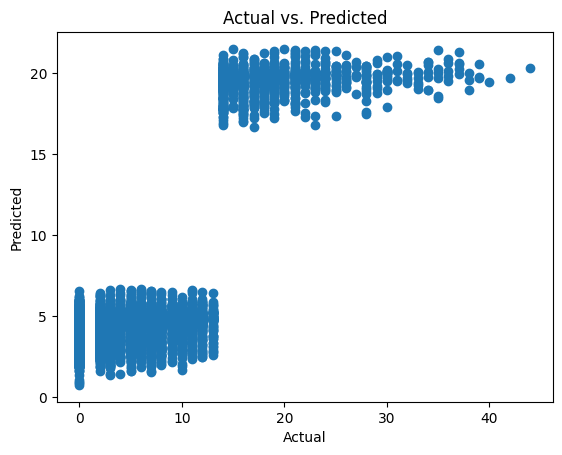

In [27]:

# batter_fp_model = get_normalized_model(game_model_outcome_data, 'batter_fp', batter_predictive_pregame_features)
# pitcher_fp_model = get_normalized_model(game_model_outcome_data, 'pitcher_fp', pitcher_predictive_pregame_features)
all_data=all_data.rename(columns={'batter_fpts':'batter_fp', 'pitcher_fpts':'pitcher_fp'})
batter_fp_model_data = all_data.drop(columns=['batter_fp_pred', 'pitcher_fp_pred', 'team_batter_fp_pred'])

# create models by selecting best features via function
target = batter_fp_model_data['batter_fp']
batter_fp_features, batter_fp_data = select_best_features(batter_fp_model_data.drop(columns='batter_fp'), target)

batter_fp_model = get_linear_model(batter_fp_model_data, ['batter_fp'], batter_fp_features)

# plot predicted vs actual
y_pred = standardized_predict(batter_fp_model, batter_fp_model_data[batter_fp_features])
plt.scatter(batter_fp_model_data['batter_fp'], y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

In [28]:
target = batter_fp_model_data['pitcher_fp']
pitcher_fp_features, pitcher_fp_data = select_best_features(batter_fp_model_data.drop(columns='pitcher_fp'), target)

pitcher_fp_model = get_linear_model(batter_fp_model_data, ['pitcher_fp'], pitcher_fp_features)

Model R2:  0.566511170419671
Model RMSE:  7.308014650526324


In [29]:


# # get team_batter_fp_pred
# team_batter_fp_pred = all_data.groupby(['team', 'pitcher_name'])['batter_fp_pred'].mean().reset_index()
# team_batter_fp_pred = team_batter_fp_pred.rename(columns={'batter_fp_pred': 'team_batter_fp_pred'})
# all_data = pd.merge(all_data, team_batter_fp_pred, on=['team', 'pitcher_name'])

# # multiply by 9 for team_batter_fp_pred
# all_data['team_batter_fp_pred'] = all_data['team_batter_fp_pred'] * 9
# drop payoff and pitcher_payoff
all_data = all_data.drop(columns=['payoff', 'pitcher_payoff'], axis=1)


In [30]:
# remove duplicates from all_data
# all_data = all_data.drop_duplicates(keep='first', subset=['batter_name', 'pitcher_name', 'game_date'])
# # change team from AZ to ARI
# all_data['team'] = all_data['team'].replace('AZ', 'ARI')
# all_data.shape

In [31]:
# get other needed data for models
# batter_fp_mean
batter_fp_mean = all_data.groupby('batter_name')['batter_fp'].mean().reset_index()
batter_fp_mean = batter_fp_mean.rename(columns={'batter_fp': 'batter_fp_mean'})
all_data = pd.merge(all_data, batter_fp_mean)

In [32]:
# get team_avg_drafted to plug into the model
team_avg_drafted_pred = all_data.groupby(['team'])['batter_drafted'].mean().reset_index()
team_avg_drafted_pred = team_avg_drafted_pred.rename(columns={'batter_drafted': 'team_avg_drafted'})
all_data = pd.merge(all_data, team_avg_drafted_pred)

In [33]:
# get team_against_pitcher_avg_drafted to plug into the model
team_against_pitcher_avg_drafted = all_data.groupby(['pitcher_name'])['batter_drafted'].mean().reset_index()
team_against_pitcher_avg_drafted = team_against_pitcher_avg_drafted.rename(columns={'batter_drafted': 'team_against_pitcher_avg_drafted'})
all_data = pd.merge(all_data, team_against_pitcher_avg_drafted)
all_data.head()

,pitcher_name,team,batting_order,batter_name,Roster Position,batter_salary,pitcher_salary,pitcher_team,WHIP,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,est_woba,est_slg,est_ba,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,batter_fp_pred,teams_in_game_pk,is_of,pitcher_fp_pred,batter_drafted,batter_fp,pitcher_drafted,pitcher_fp,opp_pitcher_drafted_mean,opp_batter_drafted_mean,team_batter_fp_pred,game_date,avg_batter_fpts_last_10,batter_14_plus,pitcher_20_plus,batter_fp_mean,team_avg_drafted,team_against_pitcher_avg_drafted
0,jack flaherty,TOR,6.00,george springer,OF,4000,8400,DET,0.96,104.00,0.12,0.06,0.34,0.43,0.26,0.16,0.08,1.42,4,1,18.42,15.20,2.00,57.42,21.45,57.42,21.56,7.47,2024-05-23,0.00,0,1,6.73,5.50,7.10
1,grayson rodriguez,CWS,7.00,korey lee,C,3700,9400,BAL,1.23,107.00,0.13,0.06,0.27,0.36,0.22,0.19,0.06,1.18,4,0,18.06,11.89,0.00,63.93,19.85,63.93,16.06,11.46,2024-05-23,0.00,0,0,4.30,3.47,4.41
2,grayson rodriguez,CWS,3.00,andrew vaughn,1B,3300,9400,BAL,1.23,107.00,0.13,0.06,0.33,0.45,0.25,0.22,0.08,1.39,4,0,18.06,12.79,7.00,63.93,19.85,63.93,16.06,11.46,2024-05-23,0.00,0,0,7.46,3.47,4.41
3,mike clevinger,BAL,1.00,gunnar henderson,SS,6200,5000,CWS,1.94,100.00,0.11,0.11,0.38,0.52,0.29,0.24,0.06,2.19,4,0,10.56,49.80,11.00,23.55,4.50,23.55,28.87,18.77,2024-05-23,0.00,0,0,10.48,7.06,28.87
4,mike clevinger,BAL,6.00,colton cowser,OF,4500,5000,CWS,1.94,100.00,0.11,0.11,0.36,0.49,0.25,0.21,0.05,2.27,4,1,10.56,20.29,0.00,23.55,4.50,23.55,28.87,18.77,2024-05-23,0.00,0,0,8.56,7.06,28.87


Batter Drafted % Linear Regression model

In [34]:


# create a model to predict batter_drafted; select features with function
target = all_data['batter_drafted']
batter_drafted_features, batter_drafted_data = select_best_features(all_data.drop(columns='batter_drafted'), target)

model_batter_drafted = get_linear_model(all_data, 'batter_drafted', batter_drafted_features)


# # model batter_drafted from all_data
# X = all_data[batter_drafted_features]
# y = all_data['batter_drafted']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# # build a linear regression model to predict the ownership of each batter
# model_batter_drafted = LinearRegression()
# model_batter_drafted.fit(X_train, y_train)
# y_pred = model_batter_drafted.predict(X_test)
# r2 = r2_score(y_test, y_pred)
# rmse = sqrt(mean_squared_error(y_test, y_pred))
# print('Ownership Model R2: ', r2)
# print('Ownership Model RMSE: ', rmse)

# get normalized model
# model_batter_drafted = get_normalized_model(all_data, 'batter_drafted', batter_drafted_features)


Model R2:  0.5391233712954813
Model RMSE:  3.2219388299009686


In [35]:
all_data[all_data.isna().any(axis=1)]

,pitcher_name,team,batting_order,batter_name,Roster Position,batter_salary,pitcher_salary,pitcher_team,WHIP,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,est_woba,est_slg,est_ba,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,batter_fp_pred,teams_in_game_pk,is_of,pitcher_fp_pred,batter_drafted,batter_fp,pitcher_drafted,pitcher_fp,opp_pitcher_drafted_mean,opp_batter_drafted_mean,team_batter_fp_pred,game_date,avg_batter_fpts_last_10,batter_14_plus,pitcher_20_plus,batter_fp_mean,team_avg_drafted,team_against_pitcher_avg_drafted


In [36]:
# def add_batter_ownership(all_data=all_data, model_batter_drafted=model_batter_drafted, X=X):
#     # create a copy of all_data and add the predicted ownership to it
#     all_data_with_ownership = all_data.copy()
#     all_data_with_ownership['batter_drafted_pred'] = model_batter_drafted.predict(X)
#     all_data_with_ownership['batter_drafted_pred'] = all_data_with_ownership['batter_drafted_pred']
#     all_data_with_ownership.head()
#     return all_data_with_ownership

all_data_with_ownership = all_data.copy()
all_data_with_ownership['batter_drafted_pred'] = standardized_predict(model_batter_drafted, all_data[batter_drafted_features])

In [37]:
# get pitcher_against_team_avg_drafted and pitcher_average_drafted to plug into the model
pitcher_against_team_avg_drafted = all_data_with_ownership.groupby(['team'])['pitcher_drafted'].mean().reset_index()
pitcher_against_team_avg_drafted = pitcher_against_team_avg_drafted.rename(columns={'pitcher_drafted': 'pitcher_against_team_avg_drafted'})
all_data_with_ownership = pd.merge(all_data_with_ownership, pitcher_against_team_avg_drafted, on='team')

pitcher_avg_drafted = all_data_with_ownership.groupby(['pitcher_name'])['pitcher_drafted'].mean().reset_index()
pitcher_avg_drafted = pitcher_avg_drafted.rename(columns={'pitcher_drafted': 'pitcher_avg_drafted'})
all_data_with_ownership = pd.merge(all_data_with_ownership, pitcher_avg_drafted)

In [38]:
all_data_with_ownership['team'].unique()

array(['TOR', 'CWS', 'BAL', 'DET', 'LAD', 'CIN', 'COL', 'LAA', 'PHI',
       'CLE', 'BOS', 'MIL', 'AZ', 'MIA', 'OAK', 'HOU', 'NYM', 'SF', 'SD',
       'NYY', 'TEX', 'MIN', 'STL', 'WSH', 'ATL', 'CHC', 'KC', 'SEA', 'TB',
       'PIT'], dtype=object)

In [39]:
# reduce df to pitcher name, batter_salary, pitcher_salary, WHIP, Pitching+, team, pitcher_fp_pred, pitcher_drafted, team_batter_fp_pred, and teams_in_game_pk; get sum of batter_salary and mean of everything else
pitcher_avg_drafted_pred = all_data_with_ownership[['pitcher_name', 'batter_salary', 'pitcher_salary', 'WHIP', 'Pitching+', 'team', 'pitcher_fp_pred', 'pitcher_drafted', 'team_batter_fp_pred', 'teams_in_game_pk', 'pitcher_avg_drafted', 'pitcher_against_team_avg_drafted']]
pitcher_avg_drafted_pred = pitcher_avg_drafted_pred.groupby(['pitcher_name', 'pitcher_drafted']).agg({'batter_salary': 'sum', 'pitcher_salary': 'mean', 'WHIP': 'mean', 'Pitching+': 'mean', 'pitcher_fp_pred': 'mean', 'team_batter_fp_pred': 'mean', 'teams_in_game_pk': 'mean', 'pitcher_avg_drafted':'mean', 'pitcher_against_team_avg_drafted':'mean'}).reset_index()
# merge this with unique pitcher_name and pitcher_drafted
pitcher_avg_drafted_pred.head()

,pitcher_name,pitcher_drafted,batter_salary,pitcher_salary,WHIP,Pitching+,pitcher_fp_pred,team_batter_fp_pred,teams_in_game_pk,pitcher_avg_drafted,pitcher_against_team_avg_drafted
0,aaron civale,0.81,34500,"7,800.00",1.39,100.00,13.67,13.96,20.00,13.83,9.74
1,aaron civale,1.95,37600,"7,200.00",1.39,100.00,14.34,14.24,26.00,13.83,7.49
2,aaron civale,17.69,31700,"6,400.00",1.39,100.00,14.14,13.31,21.00,13.83,9.74
3,aaron civale,20.20,20900,"6,200.00",1.39,100.00,13.26,11.54,18.00,13.83,19.97
4,aaron civale,31.52,24900,"6,200.00",1.39,100.00,11.78,11.98,6.00,13.83,13.54


In [40]:
# # create a model to predict pitcher_drafted; select features with function
target = pitcher_avg_drafted_pred['pitcher_drafted']
pitcher_drafted_features, pitcher_drafted_data = select_best_features(pitcher_avg_drafted_pred.drop(columns='pitcher_drafted'), target)

model_pitcher_drafted = get_linear_model(pitcher_avg_drafted_pred, 'pitcher_drafted', pitcher_drafted_features)

# linear regression model to predict pitcher_drafted
# # rename batter_salary to team_batter_salary
# pitcher_avg_drafted_pred = pitcher_avg_drafted_pred.rename(columns={'batter_salary': 'team_batter_salary'})
# pitcher_drafted_features = ['team_batter_salary', 'pitcher_salary', 'WHIP', 'Pitching+', 'pitcher_fp_pred', 'team_batter_fp_pred', 'teams_in_game_pk', 'pitcher_avg_drafted', 'pitcher_against_team_avg_drafted']
# X = pitcher_avg_drafted_pred[pitcher_drafted_features]
# y = pitcher_avg_drafted_pred['pitcher_drafted']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# model_pitcher_drafted = LinearRegression()
# model_pitcher_drafted.fit(X_train, y_train)
# y_pred = model_pitcher_drafted.predict(X_test)
# r2 = r2_score(y_test, y_pred)
# rmse = sqrt(mean_squared_error(y_test, y_pred))
# print('Pitcher Ownership Model R2: ', r2)
# print('Pitcher Ownership Model RMSE: ', rmse)

# get normalized model
# model_pitcher_drafted = get_normalized_model(pitcher_avg_drafted_pred, 'pitcher_drafted', pitcher_drafted_features)

Model R2:  0.6498523536647269
Model RMSE:  7.675991552029644


In [41]:

# get team_batter_salary for all_data_with_ownership
team_batter_salary = all_data_with_ownership.groupby('team')['batter_salary'].sum().reset_index()
team_batter_salary = team_batter_salary.rename(columns={'batter_salary': 'team_batter_salary'})
all_data_with_ownership = pd.merge(all_data_with_ownership, team_batter_salary)



In [42]:

# add pitcher_drafted_pred to all_data_with_ownership
all_data_with_ownership['pitcher_drafted_pred'] = standardized_predict(model_pitcher_drafted, all_data_with_ownership[pitcher_drafted_features])

In [43]:
# fix payoffs; previous function made them all 0 so we will simulate them as a function of the player's performance and drafted percentage
all_data_with_ownership['payoff'] = all_data_with_ownership['batter_fp'] * (1-all_data_with_ownership['batter_drafted']/100)
all_data_with_ownership['pitcher_payoff'] = all_data_with_ownership['pitcher_fp'] * (1-all_data_with_ownership['pitcher_drafted']/100)
all_data_with_ownership.sort_values(by='payoff', ascending=False).head()

,pitcher_name,team,batting_order,batter_name,Roster Position,batter_salary,pitcher_salary,pitcher_team,WHIP,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,est_woba,est_slg,est_ba,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,batter_fp_pred,teams_in_game_pk,is_of,pitcher_fp_pred,batter_drafted,batter_fp,pitcher_drafted,pitcher_fp,opp_pitcher_drafted_mean,opp_batter_drafted_mean,team_batter_fp_pred,game_date,avg_batter_fpts_last_10,batter_14_plus,pitcher_20_plus,batter_fp_mean,team_avg_drafted,team_against_pitcher_avg_drafted,batter_drafted_pred,pitcher_against_team_avg_drafted,pitcher_avg_drafted,team_batter_salary,pitcher_drafted_pred,payoff,pitcher_payoff
3476,jose quintana,COL,7.00,michael toglia,1B,3900,7900,NYM,1.26,93.00,0.16,0.04,0.35,0.54,0.25,0.20,0.07,1.87,18,0,15.18,1.34,42.00,37.03,14.55,37.03,1.58,12.96,2024-07-14,18.20,1,0,8.91,5.04,4.97,5.08,20.45,10.40,964700,15.75,41.44,9.16
2413,spencer arrighetti,DET,3.00,riley greene,OF,5200,7800,HOU,1.54,99.00,0.10,0.07,0.35,0.48,0.25,0.19,0.06,1.70,14,1,13.24,8.30,44.00,27.71,-11.80,27.71,5.41,12.47,2024-06-15,13.10,1,0,9.33,4.98,6.18,8.30,21.09,22.53,493300,29.43,40.35,-8.53
3475,jose quintana,COL,2.00,ezequiel tovar,SS,4000,7900,NYM,1.26,93.00,0.16,0.04,0.29,0.40,0.24,0.12,0.06,1.14,18,0,15.18,2.65,39.00,37.03,14.55,37.03,1.58,12.96,2024-07-14,14.00,1,0,11.52,5.04,4.97,7.53,20.45,10.40,964700,15.71,37.97,9.16
3252,corbin burnes,HOU,9.00,chas mccormick,OF,3300,9100,BAL,1.04,108.00,0.12,0.03,0.29,0.37,0.23,0.11,0.07,1.38,16,1,18.18,0.22,38.00,20.15,14.75,20.15,2.45,6.58,2024-06-22,7.70,1,0,5.93,4.19,1.50,-1.29,9.14,19.37,507300,17.32,37.92,11.78
4611,marcus stroman,BOS,5.00,tyler o'neill,OF,5300,7600,NYY,1.35,94.00,0.15,0.07,0.34,0.50,0.23,0.20,0.07,1.90,18,1,11.05,4.34,39.00,0.87,-4.50,0.87,7.21,16.03,2024-07-27,13.20,1,0,13.81,6.98,4.15,6.42,8.65,3.63,890800,-0.62,37.31,-4.46


In [44]:
# create a model to predict payoff for each player, select features with function

target = all_data_with_ownership['payoff']
batter_payoff_features, batter_payoff_data = select_best_features(all_data_with_ownership.drop(columns=['payoff', 'teams_in_game_pk', 'is_of']), target)

model_batter_payoff = get_linear_model(all_data_with_ownership, 'payoff', batter_payoff_features)

# batter_payoff_features = ['teams_in_game_pk', 'batting_order',  'est_woba',  'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq','team_batter_fp_pred', 'team_batter_fp_pred']
# # create a tensorflow model to predict payoff for each player
# X = all_data_with_ownership[batter_payoff_features]
# y = all_data_with_ownership['payoff'] / (all_data_with_ownership['batter_drafted']/100)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


# model_batter_payoff = LinearRegression()
# model_batter_payoff.fit(X_train, y_train)

# y_pred = model_batter_payoff.predict(X_test)
# r2 = r2_score(y_test, y_pred)
# rmse = sqrt(mean_squared_error(y_test, y_pred))
# print('Payoff Model R2: ', r2)
# print('Payoff Model RMSE: ', rmse)

# get normalized model
# model_batter_payoff = get_normalized_model(all_data_with_ownership, 'payoff', batter_payoff_features)



Model R2:  0.7043784557416672
Model RMSE:  3.646765208677926


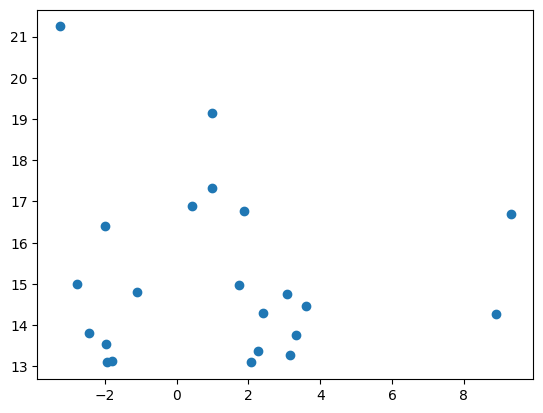

In [45]:
player_historic_payoffs = all_data_with_ownership[['pitcher_name', 'team', 'payoff', 'team_batter_fp_pred', 'batter_drafted', 'batter_drafted_pred']]
team_avg_drafted = player_historic_payoffs.groupby('team')[['batter_drafted', 'batter_drafted_pred']].mean().reset_index()
team_avg_drafted = team_avg_drafted.rename(columns={'batter_drafted': 'team_avg_drafted', 'batter_drafted_pred': 'team_avg_drafted_pred'})
team_against_pitcher_avg_drafted = player_historic_payoffs.groupby(['pitcher_name'])[['batter_drafted', 'batter_drafted_pred']].mean().reset_index()
team_against_pitcher_avg_drafted = team_against_pitcher_avg_drafted.rename(columns={'batter_drafted': 'team_against_pitcher_avg_drafted', 'batter_drafted_pred': 'team_against_pitcher_avg_drafted_pred'})
player_historic_payoffs = player_historic_payoffs.groupby(['pitcher_name', 'team']).agg({'payoff':'mean', 'team_batter_fp_pred':'mean', 'batter_drafted':'mean', 'batter_drafted_pred':'mean'}).reset_index()
player_historic_payoffs = pd.merge(player_historic_payoffs, team_avg_drafted)
player_historic_payoffs = pd.merge(player_historic_payoffs, team_against_pitcher_avg_drafted)
player_historic_payoffs['batter_drafted_pred_delta'] = player_historic_payoffs['batter_drafted_pred'] - ( player_historic_payoffs['team_avg_drafted_pred'])
top_historic_payoffs = player_historic_payoffs.sort_values(by='payoff', ascending=False).head(22)

# plot payoff vs batter_drafted_pred_delta
plt.scatter(top_historic_payoffs['batter_drafted_pred_delta'], top_historic_payoffs['payoff'])

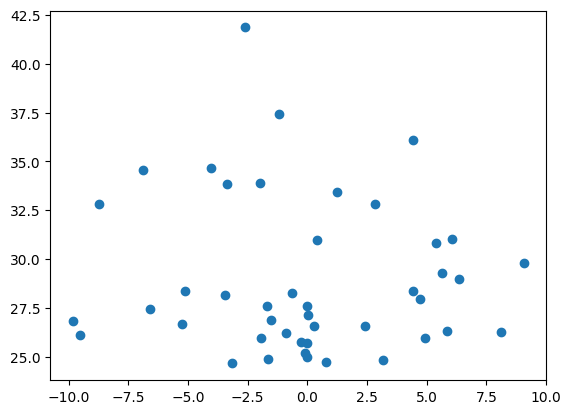

In [46]:
pitcher_historic_payoffs = all_data_with_ownership[['pitcher_name', 'team', 'pitcher_payoff', 'pitcher_drafted', 'pitcher_drafted_pred']]
pitcher_avg_drafted = pitcher_historic_payoffs.groupby('pitcher_name')[['pitcher_drafted', 'pitcher_drafted_pred']].mean().reset_index()
pitcher_avg_drafted = pitcher_avg_drafted.rename(columns={'pitcher_drafted': 'pitcher_avg_drafted', 'pitcher_drafted_pred': 'pitcher_avg_drafted_pred'})
pitcher_against_team_avg_drafted = pitcher_historic_payoffs.groupby(['team'])[['pitcher_drafted', 'pitcher_drafted_pred']].mean().reset_index()
pitcher_against_team_avg_drafted = pitcher_against_team_avg_drafted.rename(columns={'pitcher_drafted': 'pitcher_against_team_avg_drafted', 'pitcher_drafted_pred': 'pitcher_against_team_avg_drafted_pred'})
pitcher_historic_payoffs = pitcher_historic_payoffs.groupby(['pitcher_name', 'team']).agg({'pitcher_payoff':'mean', 'pitcher_drafted':'mean', 'pitcher_drafted_pred':'mean'}).reset_index()
pitcher_historic_payoffs = pd.merge(pitcher_historic_payoffs, pitcher_avg_drafted)
pitcher_historic_payoffs = pd.merge(pitcher_historic_payoffs, pitcher_against_team_avg_drafted)
pitcher_historic_payoffs['pitcher_drafted_pred_delta'] = pitcher_historic_payoffs['pitcher_drafted_pred'] - ( pitcher_historic_payoffs['pitcher_avg_drafted_pred'])
top_pitcher_historic_payoffs = pitcher_historic_payoffs.sort_values(by='pitcher_payoff', ascending=False).head(44)

# plot payoff vs pitcher_drafted_pred_delta
plt.scatter(top_pitcher_historic_payoffs['pitcher_drafted_pred_delta'], top_pitcher_historic_payoffs['pitcher_payoff'])

In [47]:
team_avg_drafted_pred = player_historic_payoffs.groupby('team')[['team_avg_drafted_pred', 'team_avg_drafted',]].first().reset_index()
# change AZ to ARI and WSH to WAS
#team_avg_drafted_pred = team_avg_drafted_pred.replace({'team': {'AZ': 'ARI', 'WAS': 'WSH'}})

team_against_pitcher_avg_drafted_pred = player_historic_payoffs.groupby('pitcher_name')[['team_against_pitcher_avg_drafted', 'team_against_pitcher_avg_drafted_pred']].first().reset_index()

In [48]:
# create a model to predict pitcher_payoff; select features with function
target = all_data_with_ownership['pitcher_payoff']
pitcher_payoff_features, pitcher_payoff_data = select_best_features(all_data_with_ownership.drop(columns=['pitcher_payoff', 'teams_in_game_pk', 'is_of']), target)

model_pitcher_payoff = get_linear_model(all_data_with_ownership, 'pitcher_payoff', pitcher_payoff_features)

# # build a model for pitcher payoffs
# pitcher_payoff_features = ['pitcher_fp_pred', 'pitcher_drafted_pred', 'pitcher_salary', 'opp_batter_drafted_mean', 'team_batter_fp_pred', 'team_batter_salary', 'WHIP', 'teams_in_game_pk', 'opp_pitcher_drafted_mean']
# just_pitcher_payoff_data = all_data_with_ownership[pitcher_payoff_features + ['pitcher_payoff', 'pitcher_drafted']]
# just_pitcher_payoff_data = just_pitcher_payoff_data.drop_duplicates()
# X = just_pitcher_payoff_data[pitcher_payoff_features]
# y = just_pitcher_payoff_data['pitcher_payoff'] / (just_pitcher_payoff_data['pitcher_drafted']/100)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# # build a linear regression model to predict the payoff of each pitcher
# model_pitcher_payoff = LinearRegression()
# model_pitcher_payoff.fit(X_train, y_train)
# y_pred = model_pitcher_payoff.predict(X_test)
# r2 = r2_score(y_test, y_pred)
# rmse = sqrt(mean_squared_error(y_test, y_pred))
# print('Pitcher Payoff Model R2: ', r2)
# print('Pitcher Payoff Model RMSE: ', rmse)

# get normalized model
# model_pitcher_payoff = get_normalized_model(all_data_with_ownership, 'pitcher_payoff', pitcher_payoff_features)

Model R2:  0.5037530088902151
Model RMSE:  6.555153219998268


In [49]:
# show which players correspond to the highest predicted payoffs
all_data_with_payoff_pred  = all_data_with_ownership.copy()
all_data_with_payoff_pred['batter_payoff_pred'] = standardized_predict(model_batter_payoff, all_data_with_payoff_pred[batter_payoff_features])
all_data_with_payoff_pred = all_data_with_payoff_pred.sort_values(by='batter_payoff_pred', ascending=False)
all_data_with_payoff_pred[batter_payoff_features]

,batter_salary,WHIP,est_woba,est_slg,batter_14_plus,pitcher_20_plus,batter_fp_mean,team_against_pitcher_avg_drafted,pitcher_against_team_avg_drafted,pitcher_avg_drafted,pitcher_drafted_pred
4859,2300,1.69,0.33,0.25,1,0,15.33,4.41,13.54,2.24,5.18
5453,2600,1.39,0.33,0.25,1,0,15.33,4.09,13.54,13.83,23.15
4317,3400,1.04,0.33,0.37,1,0,14.20,1.50,19.97,19.37,30.81
3430,2500,1.11,0.33,0.37,1,0,14.20,5.27,19.97,14.45,20.41
4515,3500,1.60,0.35,0.47,1,0,16.29,9.79,8.16,4.75,-0.37
...,...,...,...,...,...,...,...,...,...,...,...
2476,3000,1.33,0.32,0.39,0,1,0.00,9.07,19.97,14.89,23.59
277,2700,1.04,0.27,0.29,0,1,0.00,6.28,13.30,6.80,14.34
2575,3200,1.04,0.27,0.40,0,1,1.00,1.50,6.78,19.37,16.82
2981,3100,1.15,0.27,0.40,0,1,1.00,3.96,6.78,13.64,18.03


In [50]:

# get avg_batter_fp, avg_batting_order, and for pregame_data
# pregame_data = get_pregame_info(df, year, month, day)

In [51]:
features_from_batters = ['batting_order_by_pitcher_handedness',
    'est_slg',
    'est_woba',
    'batter_fp_25_by_pitcher_handedness',
    'batter_fp_75_by_pitcher_handedness',
    'hr_friendly_launch_speed_freq',
    'hr_friendly_launch_angle_freq'
 ]

features_from_pitchers = ['WHIP','Stuff+',
    'Location+',
    'Pitching+','hr_friendly_launch_speed_pitcher',
    'hr_friendly_launch_angle_pitcher',
    'pitcher_fp_75_by_batter_handedness',
    'opp_team_fp_75','batter_fp_25_by_batter_handedness', 'batter_fp_75_by_batter_handedness']

In [52]:
game_model_outcome_data.head(2)

,game_pk,batter,batter_fp,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,total_ball_movement,batter_adjusted_plate_x,team,batting_order,year,year_pa,bip,ba,est_ba,est_ba_minus_ba_diff,slg,est_slg,est_slg_minus_slg_diff,woba,est_woba,est_woba_minus_woba_diff,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,batter_name,batter_fp_25,batter_fp_75,batter_fp_mean,pa,Name,WHIP,Stuff+,Location+,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,pitcher_fp_75,opp_team_fp_75,pitcher_fp,game_pk_by_batter_handedness,batter_by_batter_handedness,batter_fp_by_batter_handedness,release_speed_by_batter_handedness,release_pos_x_by_batter_handedness,release_pos_z_by_batter_handedness,pitcher_by_batter_handedness,zone_by_batter_handedness,balls_by_batter_handedness,strikes_by_batter_handedness,game_year_by_batter_handedness,pfx_x_by_batter_handedness,pfx_z_by_batter_handedness,plate_x_by_batter_handedness,plate_z_by_batter_handedness,outs_when_up_by_batter_handedness,inning_by_batter_handedness,fielder_2_by_batter_handedness,vx0_by_batter_handedness,vy0_by_batter_handedness,vz0_by_batter_handedness,ax_by_batter_handedness,ay_by_batter_handedness,az_by_batter_handedness,sz_top_by_batter_handedness,sz_bot_by_batter_handedness,pitcher.1_by_batter_handedness,fielder_2.1_by_batter_handedness,fielder_3_by_batter_handedness,fielder_4_by_batter_handedness,fielder_5_by_batter_handedness,fielder_6_by_batter_handedness,fielder_7_by_batter_handedness,fielder_8_by_batter_handedness,fielder_9_by_batter_handedness,release_pos_y_by_batter_handedness,woba_value_by_batter_handedness,babip_value_by_batter_handedness,iso_value_by_batter_handedness,at_bat_number_by_batter_handedness,pitch_number_by_batter_handedness,home_score_by_batter_handedness,away_score_by_batter_handedness,bat_score_by_batter_handedness,fld_score_by_batter_handedness,post_away_score_by_batter_handedness,post_home_score_by_batter_handedness,post_bat_score_by_batter_handedness,post_fld_score_by_batter_handedness,delta_home_win_exp_by_batter_handedness,delta_run_exp_by_batter_handedness,total_ball_movement_by_batter_handedness,batter_adjusted_plate_x_by_batter_handedness,batting_order_by_batter_handedness,year_by_batter_handedness,year_pa_by_batter_handedness,bip_by_batter_handedness,ba_by_batter_handedness,est_ba_by_batter_handedness,est_ba_minus_ba_diff_by_batter_handedness,slg_by_batter_handedness,est_slg_by_batter_handedness,est_slg_minus_slg_diff_by_batter_handedness,woba_by_batter_handedness,est_woba_by_batter_handedness,est_woba_minus_woba_diff_by_batter_handedness,hr_friendly_launch_speed_freq_by_batter_handedness,hr_friendly_launch_angle_freq_by_batter_handedness,batter_fp_25_by_batter_handedness,batter_fp_75_by_batter_handedness,batter_fp_mean_by_batter_handedness,pa_by_batter_handedness,WHIP_by_batter_handedness,Stuff+_by_batter_handedness,Location+_by_batter_handedness,Pitching+_by_batter_handedness,pitcher_fp_75_by_batter_handedness,opp_team_fp_75_by_batter_handedness,pitc

In [53]:
dupe_cols = all_data_with_payoff_pred.columns
pitcher_data = game_model_outcome_data[['Name', 'p_throws', 'stand'] + features_from_pitchers].drop_duplicates(subset=['Name', 'p_throws', 'stand'], keep='last')
pitcher_data = fix_player_names(pitcher_data, 'Name')
pitcher_data = pitcher_data.rename(columns={'Name': 'pitcher_name'})

batter_data = game_model_outcome_data[['batter_name', 'p_throws', 'stand'] + features_from_batters].drop_duplicates(subset=['batter_name', 'p_throws', 'stand'], keep='last')
batter_data = fix_player_names(batter_data, 'batter_name')

for col in dupe_cols:
    if col in all_data_with_payoff_pred.columns:
        if col in pitcher_data.columns and col not in ['pitcher_name', 'p_throws', 'stand']:
            pitcher_data = pitcher_data.drop(columns=col)
        if col in batter_data.columns and col not in ['batter_name', 'p_throws', 'stand']:
            batter_data = batter_data.drop(columns=col)

In [54]:
all_data_with_payoff_pred.sort_values(by="batter_payoff_pred", ascending=False).head()#[all_data_with_payoff_pred.isna().any(axis=1)]

,pitcher_name,team,batting_order,batter_name,Roster Position,batter_salary,pitcher_salary,pitcher_team,WHIP,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,est_woba,est_slg,est_ba,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,batter_fp_pred,teams_in_game_pk,is_of,pitcher_fp_pred,batter_drafted,batter_fp,pitcher_drafted,pitcher_fp,opp_pitcher_drafted_mean,opp_batter_drafted_mean,team_batter_fp_pred,game_date,avg_batter_fpts_last_10,batter_14_plus,pitcher_20_plus,batter_fp_mean,team_avg_drafted,team_against_pitcher_avg_drafted,batter_drafted_pred,pitcher_against_team_avg_drafted,pitcher_avg_drafted,team_batter_salary,pitcher_drafted_pred,payoff,pitcher_payoff,batter_payoff_pred
4859,jordan montgomery,WSH,6.00,alex call,OF,2300,7200,ARI,1.69,95.00,0.17,0.05,0.33,0.25,0.20,0.05,0.00,2.18,14,1,6.60,1.47,25.00,4.52,-8.20,4.52,4.06,16.17,2024-07-29,10.70,1,0,15.33,4.65,4.41,3.84,13.54,2.24,602100,5.18,24.63,-7.83,22.65
5453,aaron civale,WSH,7.00,alex call,OF,2600,6200,MIL,1.39,100.00,0.15,0.07,0.33,0.25,0.20,0.06,0.03,1.88,6,1,11.78,6.27,16.00,31.52,0.20,31.52,9.56,11.98,2024-08-03,5.60,1,0,15.33,4.65,4.09,6.38,13.54,13.83,602100,23.15,15.00,0.14,22.52
4317,corbin burnes,MIA,2.00,xavier edwards,SS,3400,9500,BAL,1.04,108.00,0.13,0.04,0.33,0.37,0.27,0.02,0.12,1.19,10,0,20.00,4.42,17.00,37.64,16.30,37.64,2.57,7.75,2024-07-25,10.70,1,0,14.20,3.65,1.50,5.37,19.97,19.37,514500,30.81,16.25,10.16,21.46
3430,nick lodolo,MIA,5.00,xavier edwards,SS,2500,9800,CIN,1.11,97.00,0.14,0.05,0.33,0.37,0.27,0.02,0.16,1.42,18,0,18.90,5.51,22.00,25.40,10.30,25.40,6.45,6.82,2024-07-14,9.50,1,0,14.20,3.65,5.27,3.57,19.97,14.45,514500,20.41,20.79,7.68,21.46
4515,kyle freeland,SF,2.00,tyler fitzgerald,2B/SS,3500,5500,COL,1.60,97.00,0.16,0.05,0.35,0.47,0.27,0.13,0.06,1.83,21,1,10.27,18.47,37.00,5.89,7.60,5.89,6.98,17.02,2024-07-26,12.90,1,0,16.29,6.02,9.79,11.71,8.16,4.75,733300,-0.37,30.17,7.15,21.42


In [55]:
# define all_data_plus
all_data_plus = pd.merge(all_data_with_payoff_pred, pitcher_data, on='pitcher_name')
all_data_plus = pd.merge(all_data_plus, batter_data)
all_data_plus.head()




,pitcher_name,team,batting_order,batter_name,Roster Position,batter_salary,pitcher_salary,pitcher_team,WHIP,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,est_woba,est_slg,est_ba,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,batter_fp_pred,teams_in_game_pk,is_of,pitcher_fp_pred,batter_drafted,batter_fp,pitcher_drafted,pitcher_fp,opp_pitcher_drafted_mean,opp_batter_drafted_mean,team_batter_fp_pred,game_date,avg_batter_fpts_last_10,batter_14_plus,pitcher_20_plus,batter_fp_mean,team_avg_drafted,team_against_pitcher_avg_drafted,batter_drafted_pred,pitcher_against_team_avg_drafted,pitcher_avg_drafted,team_batter_salary,pitcher_drafted_pred,payoff,pitcher_payoff,batter_payoff_pred,p_throws,stand,Stuff+,Location+,pitcher_fp_75_by_batter_handedness,opp_team_fp_75,batter_fp_25_by_batter_handedness,batter_fp_75_by_batter_handedness,batting_order_by_pitcher_handedness,batter_fp_25_by_pitcher_handedness,batter_fp_75_by_pitcher_handedness
0,jordan montgomery,WSH,6.00,alex call,OF,2300,7200,ARI,1.69,95.00,0.17,0.05,0.33,0.25,0.20,0.05,0.00,2.18,14,1,6.60,1.47,25.00,4.52,-8.20,4.52,4.06,16.17,2024-07-29,10.70,1,0,15.33,4.65,4.41,3.84,13.54,2.24,602100,5.18,24.63,-7.83,22.65,L,R,94.00,98.00,12.76,104.25,0.88,8.08,7.00,0.00,8.00
1,aaron civale,WSH,7.00,alex call,OF,2600,6200,MIL,1.39,100.00,0.15,0.07,0.33,0.25,0.20,0.06,0.03,1.88,6,1,11.78,6.27,16.00,31.52,0.20,31.52,9.56,11.98,2024-08-03,5.60,1,0,15.33,4.65,4.09,6.38,13.54,13.83,602100,23.15,15.00,0.14,22.52,R,R,98.00,100.00,14.40,86.75,0.99,8.48,7.50,0.00,8.00
2,corbin burnes,MIA,2.00,xavier edwards,SS,3400,9500,BAL,1.04,108.00,0.13,0.04,0.33,0.37,0.27,0.02,0.12,1.19,10,0,20.00,4.42,17.00,37.64,16.30,37.64,2.57,7.75,2024-07-25,10.70,1,0,14.20,3.65,1.50,5.37,19.97,19.37,514500,30.81,16.25,10.16,21.46,R,L,116.00,104.00,20.45,66.00,0.75,8.60,6.00,5.75,9.25
3,nick lodolo,MIA,5.00,xavier edwards,SS,2500,9800,CIN,1.11,97.00,0.14,0.05,0.33,0.37,0.27,0.02,0.16,1.42,18,0,18.90,5.51,22.00,25.40,10.30,25.40,6.45,6.82,2024-07-14,9.50,1,0,14.20,3.65,5.27,3.57,19.97,14.45,514500,20.41,20.79,7.68,21.46,L,R,106.00,99.00,20.20,64.00,1.08,8.42,7.00,5.75,9.25
4,kyle freeland,SF,2.00,tyler fitzgerald,2B/SS,3500,5500,COL,1.60,97.00,0.16,0.05,0.35,0.47,0.27,0.13,0.06,1.83,21,1,10.27,18.47,37.00,5.89,7.60,5.89,6.98,17.02,2024-07-26,12.90,1,0,16.29,6.02,9.79,11.71,8.16,4.75,733300,-0.37,30.17,7.15,21.42,L,R,82.00,101.00,19.00,108.00,0.84,7.96,7.00,3.00,15.00


In [56]:
# use a single predictor to fill in missing values in a dataframe
def predict_nas(df, features, predictor):
    # for each feature in features
    for feature in features:
        # get the rows with missing values for that feature
        missing = df[df[feature].isna()]
        keep = df[df[feature].notna()]  
        # if there are missing values
        if missing.shape[0] > 0:
            # get a linear model from 'keep' using 'predictor' to predict 'feature'
            model = LinearRegression()
            model.fit(keep[[predictor]], keep[feature])

            # predict the missing values
            missing[feature] = model.predict(missing[[predictor]])
            
            # concatenate the missing and non-missing values
            df = pd.concat([keep, missing])
    return df


In [57]:
test = get_dk_salaries(year, month, day, optional)
test.head()

,Position,Name + ID,Name,ID,Roster Position,Salary,Game Info,TeamAbbrev,AvgPointsPerGame
0,SP,Chris Sale (35327731),chris sale,35327731,P,10400,MIL@ATL 08/06/2024 07:20PM ET,ATL,24.55
1,RP,Tyler Glasnow (35328485),tyler glasnow,35328485,P,10400,PHI@LAD 08/06/2024 10:10PM ET,LAD,22.72
2,SP,Jack Flaherty (35328486),jack flaherty,35328486,P,10400,PHI@LAD 08/06/2024 10:10PM ET,LAD,22.57
3,SP,Justin Verlander (35328487),justin verlander,35328487,P,10100,HOU@TEX 08/06/2024 08:05PM ET,HOU,14.84
4,SP,Clarke Schmidt (35328488),clarke schmidt,35328488,P,9900,LAA@NYY 08/06/2024 07:05PM ET,NYY,19.23


Get data for today, and apply knowledge from the past to predict payoffs

In [58]:
def get_todays_data(year, month, day, optional='', pregame_data=all_data_plus, df=df, team_avg_drafted_pred=team_avg_drafted_pred, pitcher_avg_drafted_pred=pitcher_avg_drafted_pred, team_against_pitcher_avg_drafted_pred=team_against_pitcher_avg_drafted_pred, pitcher_against_team_avg_drafted=pitcher_against_team_avg_drafted):
# get salaries for today
    todays_salaries = get_dk_salaries(year, month, day, optional)
    df['team'] = np.where(df['inning_topbot'] == 'Top', df['away_team'], df['home_team'])
    df = df.replace({'team': {'WAS': 'WSH', 'AZ': 'ARI'}})
    team_avg_drafted_pred = team_avg_drafted_pred.replace({'team': {'WAS': 'WSH', 'AZ': 'ARI'}})
    pitcher_against_team_avg_drafted = pitcher_against_team_avg_drafted.replace({'team': {'WAS': 'WSH', 'AZ': 'ARI'}})
    pregame_data = pregame_data.replace({'team': {'WAS': 'WSH', 'AZ': 'ARI'}})
    pitcher_avg_drafted_pred = pitcher_avg_drafted_pred.replace({'team': {'WAS': 'WSH', 'AZ': 'ARI'}})
    team_against_pitcher_avg_drafted_pred = team_against_pitcher_avg_drafted_pred.replace({'team': {'WAS': 'WSH', 'AZ': 'ARI'}})
    

    # select Name, Roster Position, Salary, and TeamAbbrev from salaries
    salaries = todays_salaries[['Name', 'Roster Position', 'Salary', 'TeamAbbrev']]
    # fixnames
    salaries = fix_player_names(salaries, 'Name')

    # remove Jr., Sr., II, and III from names
    salaries = remove_suffixes(salaries, 'Name')

    # get all players who are not Roster Position P
    hitter_salaries = salaries[salaries['Roster Position'] != 'P']

    # get all players who are Roster Position P
    pitcher_salaries = salaries[salaries['Roster Position'] == 'P']

    # rename salary to pitcher_salary
    pitcher_salaries = pitcher_salaries.rename(columns={'Salary': 'pitcher_salary', 'Name':'pitcher_name'})

    # rename hitter_salaries Name to batter_name
    hitter_salaries = hitter_salaries.rename(columns={'Name': 'batter_name'})
    hitter_salaries.reset_index(drop=True, inplace=True)

    # get batting orders from get_starters, or by using the last game_pk for the team in df
    starters = get_starters(year+'-'+month+'-'+day)

    # rename starters to batter_name
    starters = starters.rename(columns={0: 'batter_name'})

    # trim hitter_salaries
    hitter_salaries['batter_name'] = trim(hitter_salaries['batter_name'])
    hitter_salaries = fix_player_names(hitter_salaries, 'batter_name')
    hitter_salaries = remove_suffixes(hitter_salaries, 'batter_name')
    # trim starters
    starters['batter_name'] = trim(starters['batter_name'])

    # remove Jr., Sr., II, and III from names
    starters = remove_suffixes(starters, 'batter_name')
    starters['batter_name'] = starters['batter_name'].str.lower()

    starting_hitters_salaries = hitter_salaries[hitter_salaries['batter_name'].isin(starters['batter_name'])]
    starting_hitters_bo = starters[starters['batter_name'].isin(hitter_salaries['batter_name'])]
    starting_hitters_bo = starting_hitters_bo.reset_index(drop=True)

    # add a row to starting_hitters_bo that equals index mod 9 + 1
    starting_hitters_bo['batting_order'] = (starting_hitters_bo.index % 9) + 1

    # merge starting_hitters_bo with starting_hitters_salaries
    starting_hitters = pd.merge(starting_hitters_bo, starting_hitters_salaries, on='batter_name')

    # get hitters for teams which are in hitter_salaries but not in starting_hitters
    missing_hitters = hitter_salaries[~hitter_salaries['TeamAbbrev'].isin(starting_hitters['TeamAbbrev'])]['TeamAbbrev'].unique()

    # team_ga
    # if there are missing hitters
    if len(missing_hitters) > 0:
        starting_hitters = starting_hitters[~starting_hitters['TeamAbbrev'].isin(missing_hitters)]
        # first at bats for each team in their last recorded game:
        last_game_pks = df.groupby('team').first().reset_index()[['team', 'game_pk']]
        last_game_pks['tgp'] = last_game_pks['team'] + last_game_pks['game_pk'].astype(str)

        # remove teams not in missing_hitters
        last_game_pks = last_game_pks[last_game_pks['team'].isin(missing_hitters)]

        # get df rows where game_pk is in last_game_pks
        missing_hitters_df = df[df['game_pk'].isin(last_game_pks['game_pk'])]
        missing_hitters_df.loc[:,'tgp'] = missing_hitters_df.loc[:,'team'] + missing_hitters_df.loc[:,'game_pk'].astype(str)

        # remove teams not in missing_hitters
        missing_hitters_df = missing_hitters_df[missing_hitters_df['tgp'].isin(last_game_pks['tgp'])]
        # get the first at bat for each batter in missing_hitters_df
        missing_hitters_df = missing_hitters_df.sort_values(by=['game_pk','at_bat_number'])
        missing_hitters_df["batting_order"] = missing_hitters_df.groupby(['team'])['at_bat_number'].rank()
        missing_hitters_df = missing_hitters_df[missing_hitters_df['batting_order'] <= 9]

        # drop tgp
        missing_hitters_df = missing_hitters_df.drop(columns='tgp')


        # get batter_name for missing_hitters_df
        batter_ids = missing_hitters_df['batter'].unique()
        batter_name_id_pairs = playerid_reverse_lookup(batter_ids, key_type='mlbam')
        batter_name_id_pairs = batter_name_id_pairs.rename(columns={'key_mlbam':'batter'})
        batter_name_id_pairs['batter_name'] = batter_name_id_pairs['name_first'].str.capitalize() + ' ' + batter_name_id_pairs['name_last'].str.capitalize()

        # treat batter_name_id_pairs['batter_name'] the same as starters above
        batter_name_id_pairs = fix_player_names(batter_name_id_pairs, 'batter_name')
        batter_name_id_pairs = remove_suffixes(batter_name_id_pairs, 'batter_name')
        batter_name_id_pairs['batter_name'] = trim(batter_name_id_pairs['batter_name'])

        # apply formula adjust_player_name to batter_name_id_pairs by row, which will fix the names which are not formatted the same as the other dataframes
        batter_name_id_pairs['batter_name'] = batter_name_id_pairs.apply(lambda row: adjust_player_name(row), axis=1)


        # merge batter_name_id_pairs and missing_hitters_df on batter
        missing_hitters_salaries = pd.merge(missing_hitters_df, batter_name_id_pairs)

        # get name and batting order
        missing_hitters_salaries = missing_hitters_salaries[['batter_name', 'batting_order']]

        # convert batter_name to lowercase for merge
        missing_hitters_salaries['batter_name_lower'] = missing_hitters_salaries['batter_name'].str.lower()
        # drop batter_name
        missing_hitters_salaries = missing_hitters_salaries.drop(columns='batter_name')
        hitter_salaries['batter_name_lower'] = hitter_salaries['batter_name'].str.lower()

        # merge missing_hitters_salaries with hitter_salaries on batter_name
        missing_hitters_salaries = pd.merge(missing_hitters_salaries, hitter_salaries).drop_duplicates()

        #remove batter_name_lower
        missing_hitters_salaries = missing_hitters_salaries.drop(columns='batter_name_lower')
        # concat with starting_hitters
        starting_hitters = pd.concat([starting_hitters, missing_hitters_salaries])

    starting_hitters = starting_hitters.drop_duplicates(subset='batter_name', keep='first')
    # rename Salary to batter_salary
    starting_hitters = starting_hitters.rename(columns={'Salary': 'batter_salary', 'Name':'batter_name'})
    # get all players who are Roster Position P
    pitcher_salaries = todays_salaries[todays_salaries['Roster Position'] == 'P']

    # rename salary to pitcher_salary
    pitcher_salaries = pitcher_salaries.rename(columns={'Salary': 'pitcher_salary', 'Name':'pitcher_name'})



    # get opposing team from Game Info as team that is not TeamAbbrev
    pitcher_salaries['opp_team'] = pitcher_salaries.apply(lambda row: get_opposing_team(row['TeamAbbrev'], row['Game Info']), axis=1)

    # keep pitcher_name, pitcher_salary, opp_team
    pitcher_salaries = pitcher_salaries[['pitcher_name', 'pitcher_salary', 'opp_team']]

    # rename opp_team to team
    pitcher_salaries = pitcher_salaries.rename(columns={'opp_team': 'TeamAbbrev'})
    # only keep pitchers who are in starters['batter_name']
    pitcher_salaries = pitcher_salaries[pitcher_salaries['pitcher_name'].isin(starters['batter_name'])]
    # drop duplicates by team keep first
    pitcher_salaries = pitcher_salaries.drop_duplicates(subset='TeamAbbrev', keep='first')
    # merge starting_hitters with pitcher_salaries on TeamAbbrev

    all_players = pd.merge(starting_hitters, pitcher_salaries)
    # get only the last instance of pregame_data for each batter_name and pitcher_name
    batter_data = pregame_data[['batter_name', 'p_throws', 'stand', 'batter_fp_mean', 'batter_14_plus'] + features_from_batters].drop_duplicates(subset=['batter_name', 'p_throws', 'stand', 'batter_fp_mean'], keep='last')
    pitcher_data = pregame_data[['pitcher_name', 'p_throws', 'stand', 'pitcher_20_plus'] + features_from_pitchers].drop_duplicates(subset=['pitcher_name', 'p_throws', 'stand'], keep='last')

    # drop nas
    batter_data = batter_data.dropna().drop_duplicates(subset='batter_name', keep='last')
    pitcher_data = pitcher_data.dropna().drop_duplicates(subset='pitcher_name', keep='last')



    # trim names
    batter_data = fix_player_names(batter_data, 'batter_name')
    batter_data['batter_name'] = trim(batter_data['batter_name'])
    # pitcher_data = fix_player_names(pitcher_data, 'player_name')
    # pitcher_data = fix_player_names2(pitcher_data, 'player_name')
    # pitcher_data['player_name'] = trim(pitcher_data['player_name'])

    pitcher_data = fix_player_names(pitcher_data, 'pitcher_name')

    # remove Jr., Sr., II, and III from names
    batter_data = remove_suffixes(batter_data, 'batter_name')
    pitcher_data = remove_suffixes(pitcher_data, 'pitcher_name')

    # for pitchers who are not in pregame_data, use the range defined below for the columns times their salary/10000 to get a prediction for their stats
    pitcher_salaries_not_in_pregame_data = pitcher_salaries[~pitcher_salaries['pitcher_name'].isin(pitcher_data['pitcher_name'])][['pitcher_name', 'pitcher_salary']]
    # pitcher_salaries_not_in_pregame_data = pitcher_salaries_not_in_pregame_data.rename(columns={'pitcher_name': 'player_name'})

    # merge both with pitcher_salaries
    pitcher_data = pd.merge(pitcher_data, pitcher_salaries)#, left_on='player_name', right_on='pitcher_name')
    # drop na rows
    pitcher_data = pitcher_data.dropna().drop_duplicates().drop(columns=['TeamAbbrev'])
    
    if len(pitcher_salaries_not_in_pregame_data) > 0:
        # get numeric columns from pitcher_data
        numeric_cols = pitcher_data.select_dtypes(include=[np.number]).columns.tolist()
        # model = LinearRegression() for stands L and R separately using salary as the only feature to predict the numeric columns
        pitcher_salaries_not_in_pregame_data['p_throws'] = 'R' 
        dupe = pitcher_salaries_not_in_pregame_data.copy()
        pitcher_salaries_not_in_pregame_data['stand'] = 'R'
        dupe['stand'] = 'L'
        pitcher_salaries_not_in_pregame_data = pd.concat([pitcher_salaries_not_in_pregame_data, dupe])

        for col in numeric_cols:
            for stand in ['L', 'R']:
                model = LinearRegression()
                model.fit(pitcher_data[(pitcher_data['stand'] == stand)][['pitcher_salary']], pitcher_data[(pitcher_data['stand'] == stand)][col])
                pitcher_salaries_not_in_pregame_data.loc[pitcher_salaries_not_in_pregame_data['stand'] == stand, col] = model.predict(pitcher_salaries_not_in_pregame_data[pitcher_salaries_not_in_pregame_data['stand'] == stand][['pitcher_salary']])


        need_avg_drafted = pitcher_salaries_not_in_pregame_data[(~pitcher_salaries_not_in_pregame_data['pitcher_name'].isin(pitcher_avg_drafted_pred['pitcher_name']))][['pitcher_name', 'pitcher_salary']]
        others_needed = pitcher_data[(~pitcher_data['pitcher_name'].isin(pitcher_avg_drafted_pred['pitcher_name']))][['pitcher_name']]
        # get names and salaries for others_needed from pitcher_salaries
        others_needed = pd.merge(others_needed, pitcher_salaries, how="left", on="pitcher_name")[['pitcher_name', 'pitcher_salary']]  

        need_avg_drafted = pd.concat([need_avg_drafted, others_needed])
        # need_avg_drafted = need_avg_drafted.rename(columns={'player_name': 'pitcher_name'})
        need_avg_drafted['pitcher_avg_drafted'] = 0.0001*need_avg_drafted['pitcher_salary']*2.7
        # drop pitcher_salary
        # pitcher_salaries_not_in_pregame_data = pitcher_salaries_not_in_pregame_data.drop(columns='pitcher_salary')
        # add pitcher_salaries_not_in_pregame_data to pitcher_data
        pitcher_data = pd.concat([pitcher_data, pitcher_salaries_not_in_pregame_data])
    else:
        need_avg_drafted = pd.DataFrame(columns=['pitcher_name', 'pitcher_salary', 'pitcher_avg_drafted'])
    # pitcher_data = pitcher_data.rename(columns={'player_name': 'pitcher_name'})
    # rename pitcher_name to player_name in pitcher_avg_drafted_pred.rename(columns={'pitcher_name': 'player_name'})
    pitcher_avg_drafted_pred = pitcher_avg_drafted_pred[['pitcher_name', 'pitcher_avg_drafted']]
    pitcher_avg_drafted_pred = pd.concat([pitcher_avg_drafted_pred, need_avg_drafted[['pitcher_name', 'pitcher_avg_drafted']]])

    all_pitcher_names = all_players['pitcher_name'].unique()
    pitchers_in_data = pitcher_avg_drafted_pred['pitcher_name'].unique()
    missing_pitchers = [p for p in all_pitcher_names if p not in pitchers_in_data]

    # get teams missing_pitchers are facing
    missing_pitchers_teams = pitcher_salaries[pitcher_salaries['pitcher_name'].isin(missing_pitchers)]['TeamAbbrev'].unique()

    # get pitchers_against_team_avg_drafted for missing_pitchers_teams
    missing_pitchers_against_team_avg_drafted = pitcher_against_team_avg_drafted.replace({'team': {'WAS': 'WSH', 'AZ': 'ARI'}})[pitcher_against_team_avg_drafted['team'].isin(missing_pitchers_teams)]

    # create dataframe for missing_pitchers and their pitcher_avg_drafted based on the team they are facing
    missing_pitchers_avg_drafted_pred = pd.DataFrame({'pitcher_name': missing_pitchers, 'pitcher_avg_drafted':missing_pitchers_against_team_avg_drafted['pitcher_against_team_avg_drafted']})
    
    # add missing_pitchers_avg_drafted_pred to pitcher_avg_drafted_pred
    pitcher_avg_drafted_pred = pd.concat([pitcher_avg_drafted_pred, missing_pitchers_avg_drafted_pred])
    pitcher_avg_drafted_pred = pitcher_avg_drafted_pred.drop_duplicates(subset='pitcher_name', keep='first')
    #print(pitcher_avg_drafted_pred)
    # merge with pitcher_avg_drafted_pred
    pitcher_data = pd.merge(pitcher_data, pitcher_avg_drafted_pred)

    all_players_plus_data = pd.merge(all_players, batter_data, how="left")

    all_players_plus_data = pd.merge(all_players_plus_data, pitcher_data.drop(columns=['p_throws', 'stand']), how="left")
    # fix NaNs
# # print all_players_plus_data with nas
    if len(all_players_plus_data.isna().any(axis=1)) > 0:
       
        # get a list of factors being predicted by pitcher_salary
        pitching_factors = ['Pitching+', 'Stuff+', 'Location+', 'WHIP', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher', 'pitcher_fp_75_by_batter_handedness', 'opp_team_fp_75', 'pitcher_avg_drafted', 'pitcher_20_plus']
        # get a list of factors being predicted by batter_salary
        batting_factors = ['batter_fp_mean', 'batting_order_by_pitcher_handedness', 'est_slg', 'est_woba', 'batter_fp_25_by_pitcher_handedness', 'batter_fp_75_by_pitcher_handedness', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq'
                           , 'batter_fp_25_by_batter_handedness', 'batter_fp_75_by_batter_handedness', 'batter_14_plus'] 
        all_players_plus_data = predict_nas(all_players_plus_data, pitching_factors, 'pitcher_salary')
        all_players_plus_data = predict_nas(all_players_plus_data, batting_factors, 'batter_salary')
        
        all_players_plus_data['p_throws'] = np.where(all_players_plus_data['p_throws'].isna(), 'R', all_players_plus_data['p_throws'])
        all_players_plus_data['stand'] = np.where(all_players_plus_data['stand'].isna(), 'R', all_players_plus_data['stand'])
        if all_players_plus_data.isna().any(axis=1).sum() > 0:
            print(all_players_plus_data[all_players_plus_data.isna().any(axis=1)])
        all_players_plus_data = all_players_plus_data.dropna()

    # get teams in game_pk
    teams_in_game_pk = all_players_plus_data['TeamAbbrev'].unique()
    all_players_plus_data['teams_in_game_pk'] = teams_in_game_pk.size

    # add is_of column
    all_players_plus_data['is_of'] = all_players_plus_data['Roster Position'].str.contains('OF|/').astype(int)

    # predict batter_fp and pitcher_fp for all_players_plus_data
    all_players_plus_data['batter_fp_pred'] = standardized_predict(batter_fp_model, all_players_plus_data[batter_fp_features])
    all_players_plus_data['pitcher_fp_pred'] = standardized_predict(pitcher_fp_model, all_players_plus_data[pitcher_fp_features])

    # clip to >0
    all_players_plus_data['batter_fp_pred'] = all_players_plus_data['batter_fp_pred'].clip(0)
    all_players_plus_data['pitcher_fp_pred'] = all_players_plus_data['pitcher_fp_pred'].clip(0)

    # get team_batter_fp_pred
    # team_batter_fp_pred = all_players_plus_data.groupby('TeamAbbrev')['batter_fp_pred'].sum().reset_index()
    # team_batter_fp_pred = team_batter_fp_pred.rename(columns={'batter_fp_pred': 'team_batter_fp_pred'})
    # print(all_players_plus_data.head())
    # print(team_batter_fp_pred.head())

    # all_players_plus_data = pd.merge(all_players_plus_data, team_batter_fp_pred)

    # get teams_in_game_pk
    teams_in_game_pk = all_players_plus_data['TeamAbbrev'].unique()
    all_players_plus_data['teams_in_game_pk'] = teams_in_game_pk.size

    # add is_of column
    all_players_plus_data['is_of'] = all_players_plus_data['Roster Position'].str.contains('OF|/').astype(int)

    # add column for sum of batter_salary for each team
    # rename Salary to batter_salary
    # all_players_plus_data = all_players_plus_data.rename(columns={'Salary': 'batter_salary'})
    # team_batter_salary = all_players_plus_data.groupby('TeamAbbrev')['batter_salary'].sum().reset_index()
    # team_batter_salary = team_batter_salary.rename(columns={'batter_salary': 'team_batter_salary'})
    # print(all_players_plus_data.head())
    # print(team_batter_salary.head())
    # all_players_plus_data = pd.merge(all_players_plus_data, team_batter_salary)

    team_avg_drafted_pred = team_avg_drafted_pred.rename(columns={'team': 'TeamAbbrev'})
    

    # merge with team_avg_drafted_pred & pitcher_avg_drafted_pred
    all_players_plus_data = pd.merge(all_players_plus_data, team_avg_drafted_pred, how="left")
    pitcher_avg_drafted_pred = pitcher_avg_drafted_pred[['pitcher_name', 'pitcher_avg_drafted']]

    all_players_plus_data = pd.merge(all_players_plus_data, pitcher_avg_drafted_pred, how="left")

    # get all pitchers names which are not in team_against_pitcher_avg_drafted_pred
    pitchers_not_in_team_against_pitcher_avg_drafted_pred = all_players_plus_data[~all_players_plus_data['pitcher_name'].isin(team_against_pitcher_avg_drafted_pred['pitcher_name'])][['pitcher_name']].drop_duplicates()
    for p in pitchers_not_in_team_against_pitcher_avg_drafted_pred['pitcher_name']:
        pred = all_players_plus_data[all_players_plus_data['pitcher_name'] == p]['team_avg_drafted_pred'].mean()
        temp = pd.DataFrame({'pitcher_name': [p], 'team_against_pitcher_avg_drafted': [pred], 'team_against_pitcher_avg_drafted_pred': [pred]})
        team_against_pitcher_avg_drafted_pred = pd.concat([team_against_pitcher_avg_drafted_pred, temp])
    all_players_plus_data = pd.merge(all_players_plus_data, team_against_pitcher_avg_drafted_pred, how='left')

    # add pitcher_against_team_avg_drafted to all_players_plus_data
    pitcher_against_team_avg_drafted = pitcher_against_team_avg_drafted.rename(columns={'team': 'TeamAbbrev'})
    # pitcher_against_team_avg_drafted = pitcher_against_team_avg_drafted.replace({'TeamAbbrev': {'AZ': 'ARI', 'WSH': 'WAS'}})

    all_players_plus_data = pd.merge(all_players_plus_data, pitcher_against_team_avg_drafted, how="left")

    all_players_plus_data['team_batter_fp_pred'] = all_players_plus_data.groupby('TeamAbbrev')['batter_fp_pred'].transform('sum')
    all_players_plus_data['team_batter_salary'] = all_players_plus_data.groupby('TeamAbbrev')['batter_salary'].transform('sum')
    # print(all_players_plus_data[all_players_plus_data.isna().any(axis=1)])

    # predict batter_drafted and pitcher_drafted for all_players_plus_data
    all_players_plus_data['batter_drafted_pred'] = standardized_predict(model_batter_drafted, all_players_plus_data[batter_drafted_features])

    all_players_plus_data['pitcher_drafted_pred'] = standardized_predict(model_pitcher_drafted, all_players_plus_data[pitcher_drafted_features])

    # make sure batter_drafted_pred and pitcher_drafted_pred are between 0 and 100
    all_players_plus_data['batter_drafted_pred'] = all_players_plus_data['batter_drafted_pred'].clip(0, 100)
    all_players_plus_data['pitcher_drafted_pred'] = all_players_plus_data['pitcher_drafted_pred'].clip(0, 100)
    # predict payoff for all_players_plus_data
    all_players_plus_data['batter_payoff_pred'] = standardized_predict(model_batter_payoff, all_players_plus_data[batter_payoff_features])

    all_players_plus_data = all_players_plus_data.sort_values(by='batter_payoff_pred', ascending=False)
    # get opp_pitcher_drafted_mean and opp_batter_drafted_mean
    team_pitcher_drafted = all_players_plus_data.groupby('TeamAbbrev')['pitcher_drafted_pred'].mean().reset_index()
    team_pitcher_drafted = team_pitcher_drafted.rename(columns={'pitcher_drafted_pred': 'opp_pitcher_drafted_mean'})
    all_players_plus_data = pd.merge(all_players_plus_data, team_pitcher_drafted)

    team_batter_drafted = all_players_plus_data.groupby('pitcher_name')['batter_drafted_pred'].mean().reset_index()
    team_batter_drafted = team_batter_drafted.rename(columns={'batter_drafted_pred': 'opp_batter_drafted_mean'})
    all_players_plus_data = pd.merge(all_players_plus_data, team_batter_drafted)
    # predict pitcher_payoff for all_players_plus_data

    all_players_plus_data['pitcher_payoff_pred'] = standardized_predict(model_pitcher_payoff, all_players_plus_data[pitcher_payoff_features])

    # change pitcher_payoff_pred to the average payoff by pitcher_name
    pitcher_payoff_data = all_players_plus_data[['pitcher_name', 'pitcher_payoff_pred']]
    pitcher_payoff_data = pitcher_payoff_data.groupby('pitcher_name').mean().reset_index()

    # unselect pitcher_payoff_pred from all_players_plus_data
    all_players_plus_data = all_players_plus_data.drop(columns='pitcher_payoff_pred')

    # merge pitcher_payoff_data with all_players_plus_data
    all_players_plus_data = pd.merge(all_players_plus_data, pitcher_payoff_data, how="left")

    # get first instance of all_players_plus_data for each batter_name
    all_players_plus_data = all_players_plus_data.drop_duplicates(subset='batter_name', keep='last')
    # remove rows with batter_name 'Julio Rodriguez' and team 'DET' and rows with batter_name 'Max Muncy' and team 'OAK'
    all_players_plus_data = all_players_plus_data[~((all_players_plus_data['batter_name'] == 'Julio Rodriguez') & (all_players_plus_data['TeamAbbrev'] == 'DET'))]
    all_players_plus_data = all_players_plus_data[~((all_players_plus_data['batter_name'] == 'Max Muncy') & (all_players_plus_data['TeamAbbrev'] == 'OAK'))]

    # export to csv
    all_players_plus_data.to_csv('C:\\Users\\jorda\\Downloads\\all_players_plus_data.csv', index=False)
    return all_players_plus_data

In [59]:
# optional= ''
# year = '2024'
# month = '07'
# day = '14'

In [60]:
all_data_plus[model_batter_payoff.feature_names_in_].head()

,batter_salary,WHIP,est_woba,est_slg,batter_14_plus,pitcher_20_plus,batter_fp_mean,team_against_pitcher_avg_drafted,pitcher_against_team_avg_drafted,pitcher_avg_drafted,pitcher_drafted_pred
0,2300,1.69,0.33,0.25,1,0,15.33,4.41,13.54,2.24,5.18
1,2600,1.39,0.33,0.25,1,0,15.33,4.09,13.54,13.83,23.15
2,3400,1.04,0.33,0.37,1,0,14.20,1.50,19.97,19.37,30.81
3,2500,1.11,0.33,0.37,1,0,14.20,5.27,19.97,14.45,20.41
4,3500,1.60,0.35,0.47,1,0,16.29,9.79,8.16,4.75,-0.37


In [61]:
all_players_plus_data= get_todays_data(year, month, day, optional, pregame_data = all_data_plus, df = df)
#all_players_plus_data = pd.read_csv('C:\\Users\\jorda\\Downloads\\all_players_plus_data.csv')
#pitcher_salaries_not_in_pregame_data #[pitcher_data['pitcher_name'].str.contains('Carson')]
#pitcher_data[pitcher_data['pitcher_name'].str.contains('Sonny')]
#all_players_plus_data[all_players_plus_data['TeamAbbrev'] == 'PIT']


In [62]:
all_players_plus_data.head()


,batter_name,batting_order,Roster Position,batter_salary,TeamAbbrev,pitcher_name,pitcher_salary,p_throws,stand,batter_fp_mean,batter_14_plus,batting_order_by_pitcher_handedness,est_slg,est_woba,batter_fp_25_by_pitcher_handedness,batter_fp_75_by_pitcher_handedness,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,pitcher_20_plus,WHIP,Stuff+,Location+,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,pitcher_fp_75_by_batter_handedness,opp_team_fp_75,batter_fp_25_by_batter_handedness,batter_fp_75_by_batter_handedness,pitcher_avg_drafted,teams_in_game_pk,is_of,batter_fp_pred,pitcher_fp_pred,team_avg_drafted_pred,team_avg_drafted,team_against_pitcher_avg_drafted,team_against_pitcher_avg_drafted_pred,pitcher_against_team_avg_drafted,pitcher_against_team_avg_drafted_pred,team_batter_fp_pred,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,batter_payoff_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred
0,ezequiel tovar,1.00,SS,4300,COL,luis severino,6800,R,R,11.52,0.00,2.19,0.40,0.29,0.00,11.00,0.14,0.06,0.00,1.20,104.00,99.00,100.00,0.12,0.05,19.00,93.00,0.75,7.83,6.51,22,0,8.61,0.00,5.80,5.04,3.16,2.84,20.45,18.01,74.25,32300,7.03,9.36,9.84,9.59,4.03,-1.47
1,jorge polanco,4.00,2B,4000,SEA,keider montero,5400,L,R,9.89,0.00,5.29,0.41,0.31,1.50,7.00,0.13,0.03,0.00,1.45,97.00,98.00,99.00,0.14,0.03,10.38,111.00,0.60,7.30,3.52,22,0,8.83,0.00,4.86,5.17,7.84,7.24,20.22,18.85,78.28,32500,9.61,9.51,9.19,9.63,8.60,-2.63
2,brandon nimmo,3.00,OF,5000,NYM,kyle freeland,6000,R,L,10.05,0.00,1.71,0.45,0.36,3.00,13.00,0.18,0.04,0.00,1.60,82.00,101.00,97.00,0.16,0.05,19.00,108.00,0.84,7.96,4.75,22,1,9.38,0.00,3.39,3.43,9.79,9.21,8.66,8.50,80.85,38900,10.08,4.18,9.17,4.40,9.17,-1.76
3,dylan moore,8.00,3B/SS,3700,SEA,keider montero,5400,R,R,9.32,0.00,8.05,0.36,0.30,0.00,7.00,0.14,0.06,0.00,1.45,97.00,98.00,99.00,0.14,0.03,10.38,111.00,0.60,7.30,3.52,22,1,8.25,0.00,4.86,5.17,7.84,7.24,20.22,18.85,78.28,32500,6.28,9.61,9.14,9.63,8.60,-2.63
4,randy arozarena,2.00,OF,4800,SEA,keider montero,5400,R,R,9.53,0.00,3.22,0.42,0.34,2.25,10.00,0.15,0.04,0.00,1.45,97.00,98.00,99.00,0.14,0.03,10.38,111.00,0.60,7.30,3.52,22,1,9.25,0.00,4.86,5.17,7.84,7.24,20.22,18.85,78.28,32500,9.92,9.25,9.13,9.63,8.60,-2.63


In [63]:
teams_in_set = all_players_plus_data['TeamAbbrev'].unique()
for team in teams_in_set:
    team_data = all_players_plus_data[all_players_plus_data['TeamAbbrev'] == team]
    print(team, team_data.shape)

COL (9, 48)
SEA (9, 48)
NYM (9, 48)
NYY (9, 48)
CWS (9, 48)
KC (9, 48)
BAL (9, 48)
LAD (8, 48)
BOS (9, 48)
LAA (9, 48)
MIN (9, 48)
TOR (9, 48)
HOU (9, 48)
PHI (9, 48)
STL (9, 48)
TB (9, 48)
MIL (9, 48)
TEX (9, 48)
CHC (9, 48)
OAK (9, 48)
ATL (9, 48)
DET (9, 48)


In [64]:
# Start here if you have already run the above code
all_players_plus_data = pd.read_csv('C:\\Users\\jorda\\Downloads\\all_players_plus_data.csv')

def remove_non_matching_players(salaries, all_players_plus_data, salaries_name, all_players_name):
    salaries_name_lower = salaries_name + '_lower'
    all_players_name_lower = all_players_name + '_lower'
    salaries[salaries_name_lower] = salaries[salaries_name].str.lower()
    all_players_plus_data[all_players_name_lower] = all_players_plus_data[all_players_name].str.lower()
    salaries = salaries[salaries[salaries_name_lower].isin(all_players_plus_data[all_players_name_lower])]
    return salaries
# show all_variables with numeric values formatted to 2 decimal places
def format_floats(floats):
    all_nums = []
    # Set the desired number of decimal places
    desired_decimal_places = 2

    # Convert the floats to strings with the desired number of decimal places
    modified_floats = [f"{num:.{desired_decimal_places}f}" for num in floats]

    # Print the modified floats
    for num in modified_floats:
        all_nums.append(num)
    return all_nums

def get_all_variables(year, month, day, optional='', df=df):
    # get rows from today's DKSalariesMLB which include player names in all_players_plus_data['batter_name'] or all_players_plus_data['pitcher_name']
    todays_salaries = get_dk_salaries(year, month, day, optional)
    todays_salaries = fix_player_names(todays_salaries, 'Name')
    todays_salaries = remove_suffixes(todays_salaries, 'Name')
    todays_salaries.loc[:,'Name'] = todays_salaries.loc[:,'Name'].str.strip()

    # pregame_data = get_pregame_info(df, year, month, day)
    all_players_plus_data = get_todays_data(year, month, day, optional=optional, pregame_data=all_data_plus, df=df)

    # get all players who are not Roster Position P
    hitter_salaries = todays_salaries[todays_salaries['Roster Position'] != 'P']

    # get all players who are Roster Position P
    pitcher_salaries = todays_salaries[todays_salaries['Roster Position'] == 'P']

    # remove players who are not in all_players_plus_data
    hitter_salaries = remove_non_matching_players(hitter_salaries, all_players_plus_data, 'Name', 'batter_name')
    pitcher_salaries = remove_non_matching_players(pitcher_salaries, all_players_plus_data, 'Name', 'pitcher_name')

    # merge all_players_plus_data with hitter_salaries on batter_name
    variables = pd.merge(all_players_plus_data, hitter_salaries, left_on='batter_name', right_on='Name', how='left')
    # merge variables with pitcher_salaries on pitcher_name
    pitcher_variables = pd.merge(all_players_plus_data, pitcher_salaries, left_on='pitcher_name', right_on='Name', how='left')

    # drop mismatched col from variables and pitcher_variables
    variables = variables.drop(columns=['batter_name', 'pitcher_name'])
    pitcher_variables = pitcher_variables.drop(columns=['batter_name', 'pitcher_name'])

    # concat
    all_variables = pd.concat([variables, pitcher_variables])

    # get Name_lower and fp_pred from all_players_plus_data for hitters and pitchers
    hitters_fp_pred = all_players_plus_data[['batter_name_lower', 'batter_fp_pred', 'batter_drafted_pred']]
    pitchers_fp_pred = all_players_plus_data[['pitcher_name_lower', 'pitcher_fp_pred', 'pitcher_drafted_pred']]

    # for pitchers, get the mean of pitcher_fp_pred for each pitcher_name
    pitchers_fp_pred = pitchers_fp_pred.groupby('pitcher_name_lower').mean().reset_index()

    # set column names as the same and concatenate, then merge to all_variables
    hitters_fp_pred = hitters_fp_pred.rename(columns={'batter_name_lower': 'Name_lower', 'batter_fp_pred': 'player_fp_pred', 'batter_drafted_pred': 'player_drafted_pred'})
    pitchers_fp_pred = pitchers_fp_pred.rename(columns={'pitcher_name_lower': 'Name_lower', 'pitcher_fp_pred': 'player_fp_pred', 'pitcher_drafted_pred': 'player_drafted_pred'})
    fp_pred = pd.concat([hitters_fp_pred, pitchers_fp_pred])
    all_variables = pd.merge(all_variables, fp_pred, on='Name_lower', how='left')

    # drop batter_salary and pitcher_salary
    all_variables = all_variables.drop(columns=['batter_salary', 'pitcher_salary'])

    # add a column for payoff which is pitcher_payoff_pred if Roster Position is 'P' otherwise payoff_pred
    all_variables['payoff'] = np.where(all_variables['Position'] == 'SP', all_variables['pitcher_payoff_pred'], all_variables['batter_payoff_pred'])

    # remove TeamAbbrev_x and rename TeamAbbrev_y to team
    all_variables = all_variables.drop(columns='TeamAbbrev_x')
    all_variables = all_variables.rename(columns={'TeamAbbrev_y': 'team'})

    # add opponent based on team and Game Info
    all_variables['opp_team'] = all_variables.apply(lambda row: get_opposing_team(row['team'], row['Game Info']), axis=1)

    # keep only necessary info
    # all_variables = all_variables[['Name', 'ID', 'Roster Position_y', 'Salary', 'team', 'payoff', 'opp_team', 'player_fp_pred', 'player_drafted_pred']]
    all_variables = all_variables.rename(columns={'Roster Position_y':'position'})

    all_variables = all_variables.drop_duplicates()

    all_variables = all_variables.groupby('Name').first().reset_index()

    # get sum of player_fp_pred for opposing batters and add to all_variables as opp_sum_pred for pitchers
    # also get sum of player_fp_pred for opposing pitchers and add to all_variables as opp_sum_pred for batters
    # do this without using a for loop:
    # all_variables['opp_mean_pred'] = 0
    # for i in range(len(all_variables)):
    #     if all_variables.iloc[i]['position'] == 'P':
    #         all_variables.at[i, 'opp_mean_pred'] = all_variables[(all_variables['team'] == all_variables.iloc[i]['opp_team']) & (all_variables['position'] != 'P')]['player_fp_pred'].mean()
    #     else:
    #         # get the mean for opposing pitcher mean for i's pitcher_name_lower when position is P
    #         all_variables.at[i, 'opp_mean_pred'] = all_variables[(all_variables['pitcher_name_lower'] == all_variables.iloc[i]['pitcher_name_lower']) & (all_variables['position'] == 'P')]['player_fp_pred'].mean()

    all_variables['opp_mean_pred'] = all_variables.apply(lambda row: all_variables[(all_variables['team'] == row['opp_team']) & (all_variables['position'] != 'P')]['player_fp_pred'].mean() if row['position'] == 'P' else all_variables[(all_variables['pitcher_name_lower'] == row['pitcher_name_lower']) & (all_variables['position'] == 'P')]['player_fp_pred'].mean(), axis=1)
    # format floats to 2 decimal places
    # all_variables = all_variables.apply(lambda x: format_floats(x) if x.dtype == 'float64' else x)
    
    return all_variables



In [359]:
# comment out the following lines if you have already run the above code
year = '2024'
month = '08'
day = '07'
optional = ''
all_variables = get_all_variables(year, month, day, optional, df=df)


In [66]:
test = all_variables
test['batter_14_plus'] = test['batter_14_plus'].astype(float)*100
test['pitcher_20_plus'] = test['pitcher_20_plus'].astype(float)*100
test[['Name', 'batter_14_plus']].head()

,Name,batter_14_plus
0,aaron judge,0.00
1,addison barger,0.00
2,adley rutschman,0.00
3,adolis garcia,0.00
4,alejandro kirk,0.00


In [67]:
best_plays = all_variables[['Name_lower', 'position', 'team', 'Salary', 'player_fp_pred', 'player_drafted_pred', 'payoff']]
best_plays['build_pred'] = best_plays['player_fp_pred'] + best_plays['player_drafted_pred'] + best_plays['payoff']

best_plays.sort_values(by='build_pred', ascending=False).head(20)

,Name_lower,position,team,Salary,player_fp_pred,player_drafted_pred,payoff,build_pred
141,paul skenes,P,PIT,10300,21.42,30.46,14.62,66.50
67,gerrit cole,P,NYY,8600,19.35,28.68,13.08,61.11
127,max fried,P,ATL,9000,20.85,25.93,9.16,55.93
152,simeon woods richardson,P,MIN,7100,20.16,18.25,16.46,54.88
129,michael wacha,P,KC,8400,20.24,17.34,15.63,53.21
157,tobias myers,P,MIL,8200,19.84,13.66,16.68,50.18
134,nick pivetta,P,BOS,8500,20.00,12.73,17.43,50.16
149,ryne nelson,P,ARI,5900,18.42,12.07,16.23,46.72
131,mitchell parker,P,WSH,6100,19.04,9.80,17.42,46.26
132,nathan eovaldi,P,TEX,9200,20.07,7.67,17.34,45.09


In [68]:
# simulate a game for players in model_vars
def simulate_game_batters(model_vars):
    # determine # of at bats for each player based on their team and batting order
    model_vars['at_bats'] = 0
    teams = model_vars['team'].unique()
    for team in teams:
        # randomize at bats for each team between 4 and 5
        at_bats = random.randint(3,6)
        model_vars.loc[(model_vars['team'] == team) & (model_vars['position'] != 'P'), 'at_bats'] = at_bats
        # subtract 1 for batters 7 or later
        model_vars.loc[(model_vars['team'] == team) & (model_vars['position'] != 'P') & (model_vars['batting_order'] >= 7), 'at_bats'] -= 1

    # simulate at bats for each player
    build_preds = []
    for i in range(len(model_vars)):
        score = 0
        for j in range(model_vars.iloc[i]['at_bats']):
            score += simulate_at_bat(model_vars.iloc[i]['build_pred'])

        build_preds.append(score)
    model_vars['build_pred'] = build_preds

    return model_vars

# simulate a single at bat based on the player's median prediction
def simulate_at_bat(fp_pred):
    hr_chance = 0.008 * fp_pred
    single_chance = 0.12 * fp_pred
    double_chance = 0.07 * fp_pred
    out = 1 - (hr_chance + single_chance + double_chance)
    # give 14 for a hr, 5 for a double, 3 for a single or 0 for an out
    outcomes = [14, 5, 3, 0]
    get_run_rbi = 0.05 * fp_pred
    no_run_rbi = 1 - get_run_rbi
    run_rbi = random.choices([0, 2], weights=[no_run_rbi, get_run_rbi])[0]
    return random.choices(outcomes, weights=[hr_chance, double_chance, single_chance, out])[0] + run_rbi

In [421]:
# create a linear solver for a draftkings lineup with the highest possible payoff using all_variables


# convert players to stacks
def convert_players_to_stacks(model_vars, teams, big_stack_size):
    # add a column for stack
    model_vars['stack'] = 0
    # add a column for players_in_stack equal to name
    model_vars['players_in_stack'] = model_vars['Name']

    valid_players = model_vars[model_vars['position'] != 'P']

    # stack sizes should be between 2 and 5
    if(big_stack_size == 5): 
        stack_sizes = [2, 3, 5]
    else:
        stack_sizes = [3, 4]
    # for each team
    all_stacks = []
    for team in teams:
        # get the players from the team
        team_players = valid_players[valid_players['team'] == team]
        # for each stack size
        for stack_size in stack_sizes:
            # if team_players is less than stack_size, continue
            if len(team_players) < stack_size:
                continue
            
            # get the players in the stack
            keep = team_players.nlargest(stack_size, 'build_pred') # 'Utility')
            # create a stack row for model_vars for team and stack_size summing all other columns
            stack_row = keep.sum()
            stack_row['team'] = team
            stack_row['Name'] = f'{team} Stack {stack_size}'
            stack_row['stack'] = stack_size
            stack_row['players_in_stack'] = ', '.join(keep['Name'])

            # add to all_stacks
            all_stacks.append(stack_row)

    all_stacks_df = pd.DataFrame(all_stacks)

    model_vars = pd.concat([model_vars, all_stacks_df], ignore_index=True)
    return model_vars

# convert stacks back to players
def convert_stacks_to_players(lineup, model_vars):
    lineup_stacks = lineup[lineup['Name'].str.contains('Stack')]
    single_players = lineup[~lineup['Name'].str.contains('Stack')]
    while(lineup_stacks.shape[0] > 0):
        stack = lineup_stacks.iloc[0]
        players = stack['players_in_stack'].split(', ')
        for player in players:
            # if player is in model_vars, add to single_players
            if player in model_vars['Name'].values:
                player_row = model_vars[model_vars['Name'] == player]

                # add to single players if not a stack
                if player_row['stack'].values[0] == 0:
                    single_players = pd.concat([single_players, player_row])
                else:
                    # add to lineup_stacks if a stack
                    lineup_stacks = pd.concat([lineup_stacks, player_row])
            else:
                #print(f'{player} not in model_vars')
                # break loop if player is not in model_vars
                return single_players
        lineup_stacks = lineup_stacks.iloc[1:]

    return single_players

def calculate_likelihood(model_vars):
    # map sum of payoffs by position
    position_payoffs = model_vars.groupby('position')['payoff'].sum().reset_index()
    payoff_map = dict(zip(position_payoffs['position'], position_payoffs['payoff']))
    # for odds to hit, divide payoff by position payoff sum based on player's position; multiply by 2 for pitchers and 3 for OF
    model_vars['likelihood'] = model_vars.apply(lambda row: row['payoff']/payoff_map[row['position']]*100, axis=1)
    model_vars['likelihood'] = np.where(model_vars['position'] == 'P', model_vars['likelihood']*2, model_vars['likelihood'])
    model_vars['likelihood'] = np.where(model_vars['position'] == 'OF', model_vars['likelihood']*3, model_vars['likelihood'])
    # # first, get payoff sums for each position
    # position_payoff_sums = model_vars.groupby('position')['build_pred'].sum().reset_index()
    # # rename to position payoff sum
    # position_payoff_sums = position_payoff_sums.rename(columns={'build_pred': 'position_payoff_sum'})

    # # add a column for likelihood of being in the top lineup, which is player's payoff pred / sum of payoff pred for that position
    # model_vars = pd.merge(model_vars, position_payoff_sums, on='position')
    # model_vars['likelihood'] = model_vars['build_pred'] / model_vars['position_payoff_sum']

    # # if likelihood is less than 0, set to 0
    # model_vars['likelihood'] = model_vars['likelihood'].clip(0, 1)

    # # add a column for likelihood %, which is likelihood - (1 - likelihood) / (1/player_drafted_pred - 1)
    # model_vars['kelly'] = model_vars['likelihood'] - (1 - model_vars['likelihood']) / (1/(model_vars['player_drafted_pred'] / 100)- 1)

    # get sum of likelihood for each team (except pitchers), then set sum of team likelihood to 1
    team_likelihood = model_vars[model_vars['position'] != 'P'].groupby('team')['likelihood'].sum().reset_index()
    # convert to float64
    team_likelihood['likelihood'] = team_likelihood['likelihood'].astype('float64')
    team_likelihood['team_likelihood'] = team_likelihood['likelihood'] / team_likelihood['likelihood'].sum()
    team_likelihood['team_likelihood'] = fix_p(team_likelihood['team_likelihood'])

    return model_vars, team_likelihood

def fix_p( p):
    p = p.astype('float64')
    # replace any negative values or NaN with 0.01
    p = p.fillna(0.01)
    p = p.clip(0.01, 0.99)
    # if sum of p is not 1, normalize
    if p.sum() != 1.0:
        p = p.clip(0.01, 0.99)
        p /= p.sum()
        if p.sum() != 1.0:
            p[-1] = 1.0 - p[:-1].sum()
        
    return p

def build_one_lineup(model_vars, bans = [], stdev = .28, num_pitchers = 9, num_batters = 90, easing = 1, num_teams = 3, fd = False):
    if not fd:
        # Constraints:
        max_salary = 50000
        min_salary = 49700
        max_batters_per_team = 5
    else:
        max_salary = 35000
        min_salary = 34500
        max_batters_per_team = 4

    req_stacking = True
    
    # remove banned players
    model_vars = model_vars[~model_vars['Name'].isin(bans)]
    model_vars = model_vars[~model_vars['team'].isin(bans)]

    if fd:
        model_vars['position'] = model_vars['fd_position']
        model_vars['Salary'] = model_vars['fd_salary']
        model_vars['ID'] = model_vars['fd_id']

    # ensure position only contains 1 option; if includes a '/', randomly select one of them
    model_vars.loc[:,'position'] = model_vars.loc[:,'position'].apply(lambda x: random.choice(x.split('/')))

    # if fd, change C or 1B to C/1B
    if fd:
        model_vars.loc[:,'position'] = model_vars.loc[:,'position'].apply(lambda x: 'C/1B' if x in ['C', '1B'] else x)

    # model_vars['batter_drafted_delta'] = np.where(model_vars['position'] != 'P', model_vars['player_drafted_pred'] - model_vars['team_avg_drafted_pred'], 0)
    # model_vars['pitcher_drafted_delta'] = np.where(model_vars['position'] == 'P', model_vars['player_drafted_pred'] - model_vars['pitcher_avg_drafted'], 0)

    # convert variables to floats if possible
    for i in ['Salary', 'player_fp_pred', 'batter_payoff_pred', 'player_drafted_pred', 'opp_mean_pred']:#, 'Utility']: #, 'net_sqrt_pred']:
        model_vars[i] = model_vars[i].astype(float)


    for i in ['P', 'C', '1B', '2B', '3B', 'SS', 'OF']:
        # give each variable a 1 if Roster Position contains i
        model_vars[i] = model_vars['position'].str.contains(i).astype(int)

    model_vars['build_pred'] =( model_vars['player_fp_pred']*2 +  model_vars['player_drafted_pred'] + model_vars['payoff']) # * (1 - model_vars['player_drafted_pred']/100) #+ model_vars['player_fp_pred']

    # add column equal to 1 for top 3 drafted pitchers, 0 for everyone else
    top_pitcher_drafted = model_vars[(model_vars['position'] == 'P')].nlargest(3, 'player_drafted_pred')['Name']
    model_vars['top_drafted_pitcher'] = np.where(model_vars['Name'].isin(top_pitcher_drafted), 1, 0)


    model_vars, team_likelihood = calculate_likelihood(model_vars)

    keep_pitchers = model_vars[(model_vars['position'] == 'P')].nlargest(round(num_pitchers * easing), 'likelihood')
    keep_batters = model_vars[model_vars['position'] != 'P'].nlargest(round(num_batters * easing), 'likelihood')
    model_vars = pd.concat([keep_batters, keep_pitchers])

    # count of players in model_vars by team
    team_counts = model_vars.groupby('team')['Name'].count().reset_index()
    # remove teams with less than 4 players
    team_counts = team_counts[team_counts['Name'] >= 4]
    # remove teams with less than 4 players from team_likelihood
    team_likelihood = team_likelihood[team_likelihood['team'].isin(team_counts['team'])]

    # if team_likelihood does not sum to 1, set all values to 1/len(team_likelihood)
    if team_likelihood['team_likelihood'].sum() != 1.0:
        team_likelihood['team_likelihood'] = team_likelihood['likelihood'] / team_likelihood['likelihood'].sum()
    #print(team_likelihood['team_likelihood'])
    # choose 2 teams based on team_kelly
    selected_team = np.random.choice(team_likelihood['team'], size=num_teams, replace=False, p=team_likelihood['team_likelihood'])

    # select pitchers based on who is facing the worst teams; taking 4 in case it would select pitchers facing the stacked team
    keep_pitchers = model_vars[(model_vars['position'] == 'P')]
    # if likelihood < 0, set to 0
    keep_pitchers['likelihood'] = fix_p(keep_pitchers['player_drafted_pred']/100)
    #print(keep_pitchers['likelihood'])
    # if likelihood does not sum to 1, set all values to 1/len(keep_pitchers)
    if keep_pitchers['likelihood'].sum() != 1.0:
        keep_pitchers['likelihood'] = 1/len(keep_pitchers)
    p_size = 4
    if len(keep_pitchers) < p_size:
        p_size = len(keep_pitchers)

    selected_pitchers = np.random.choice(keep_pitchers['Name'], size=p_size, replace=False, p=keep_pitchers["likelihood"])
    # add top_pitcher_drafted to selected_pitchers
    selected_pitchers = np.concatenate([selected_pitchers, top_pitcher_drafted])

    # get all teams
    teams = model_vars['team'].unique()


    # randomly require either a 4 or 5 stack
    #big_stack_size = 5 #np.random.choice([4, 5])
    # model_vars = simulate_game_batters(model_vars)
    model_vars['team_build_pred_avg'] = model_vars.groupby('team')['build_pred'].transform('mean')
    # randomize build_pred for pitchers based on stdev
    model_vars['build_pred'] = model_vars['build_pred'] + (model_vars['team_build_pred_avg'] * np.random.normal(0, stdev, len(model_vars))) # np.where(model_vars['position'] == 'P', model_vars['player_fp_pred'] + np.random.normal(0, 1.0, None)*stdev, model_vars['player_fp_pred'] + np.random.normal(0, 0.5, None)*stdev)
    # add variance and constraint for each player based on teams
    for team in teams:
        model_vars[team] = np.where((model_vars['team'] == team) & (model_vars['position'] != 'P'), 1, 0)
        model_vars[team] = np.where((model_vars['opp_team'] == team) & (model_vars['position'] == 'P'), max_batters_per_team, model_vars[team])
        #model_vars['build_pred'] = np.where(model_vars['team'] == team, model_vars['build_pred'] * (1 + np.random.normal(0, stdev*2, None)), model_vars['build_pred'])

    model_vars['opp_team'] = model_vars.apply(lambda row: get_opposing_team(row['team'], row['Game Info']), axis=1)

    model_vars['is_stacked'] = np.where((model_vars['position'] != 'P') & (model_vars['team'].isin(selected_team)), 1, 0)
    model_vars['is_selected_pitcher'] = np.where((model_vars['position'] == 'P') & (model_vars['Name'].isin(selected_pitchers)), 1, 0)

    # add a 1 for players batting 8 or 9 and 0 for all others
    model_vars['end_of_lineup'] = np.where((model_vars['position'] != 'P') & (model_vars['batting_order'] >= 8), 1, 0)

    prob = LpProblem("lineup", LpMaximize)

    # create a unique variable for each player 
    model_vars['var'] = [LpVariable("var{}".format(i), 0, 1, LpInteger) for i in range(model_vars.shape[0])]

    # drop nas
    model_vars = model_vars.dropna()

    # add objective function
    prob += lpSum(model_vars['build_pred'] * model_vars['var']), "Total build_pred"

    # add salary constraint
    prob += lpSum(model_vars['Salary'] * model_vars['var']) <= max_salary, "Max Salary"
    prob += lpSum(model_vars['Salary'] * model_vars['var']) >= min_salary, "Min Salary"

    # add constraint for number of pitchers
    if fd:
        prob += lpSum(model_vars['P'] * model_vars['var']) == 1, "Pitchers"
    else:
        prob += lpSum(model_vars['P'] * model_vars['var']) == 2, "Pitchers"

    # add constraint for number of batters
    if fd:
        model_vars['C/1B'] = model_vars['1B'] + model_vars['C']
        prob += lpSum(model_vars['C/1B'] * model_vars['var']) >= 1, "C/1Bs"
        prob += lpSum(model_vars['2B'] * model_vars['var']) >= 1, "2Bs"
        prob += lpSum(model_vars['3B'] * model_vars['var'])>= 1, "3Bs"
        prob += lpSum(model_vars['SS'] * model_vars['var']) >= 1, "SSs"
        prob += lpSum(model_vars['OF'] * model_vars['var']) >= 3, "OFs"
        model_vars['is_batter'] = np.where(model_vars['position'] != 'P', 1, 0)
        prob += lpSum(model_vars['is_batter'] * model_vars['var']) == 8, "Batters"
    else:
        prob += lpSum(model_vars['C'] * model_vars['var']) == 1, "Catchers"
        prob += lpSum(model_vars['1B'] * model_vars['var']) == 1, "1Bs"
        prob += lpSum(model_vars['2B'] * model_vars['var']) == 1, "2Bs"
        prob += lpSum(model_vars['3B'] * model_vars['var']) == 1, "3Bs"
        prob += lpSum(model_vars['SS'] * model_vars['var']) == 1, "SSs"
        prob += lpSum(model_vars['OF'] * model_vars['var']) == 3, "OFs"


    req_in_stack = 8# np.random.choice([7, 8])

    # # add constraint for stacks required
    if req_stacking:
        prob += lpSum(model_vars['is_stacked'] * model_vars['var']) >= req_in_stack, "Stacks"

    if fd:
        prob += lpSum(model_vars['is_selected_pitcher'] * model_vars['var']) == 1, "Selected Pitchers"
    else:
        prob += lpSum(model_vars['is_selected_pitcher'] * model_vars['var']) == 2, "Selected Pitchers"

    # add constraint such that no more than 5 batters can be from the same team
    for team in model_vars['team'].unique():
        prob += lpSum(model_vars[team] * model_vars['var']) <= max_batters_per_team, f"Max Batters from {team}"

    # add constraint max 1 of end_of_lineup
    prob += lpSum(model_vars['end_of_lineup'] * model_vars['var']) <= 1, "End of Lineup"
    # prob += lpSum(model_vars['payoff'] * model_vars['var']) >= 16 - easing ** 2, "Min payoff"
    # add constraint so that catchers and 2nd basemen are in stacks
    # if easing < 1.5:
    #     model_vars['C_in_stack'] = model_vars['C'] * model_vars['is_stacked']
    #     model_vars['2B_in_stack'] = model_vars['2B'] * model_vars['is_stacked']
    #     prob += lpSum(model_vars['C_in_stack'] * model_vars['var']) >= 1, "C in stack"
    #     prob += lpSum(model_vars['2B_in_stack'] * model_vars['var']) >= 1, "2B in stack"

    #     # get the 50th percentile of value
    #     high_value = model_vars['value'].quantile(0.5)
    #     # min value of 18
    #     prob += lpSum(model_vars['value'] * model_vars['var']) >= high_value * 8, "Min value"

    # constraint that sum of player_drafted_delta is less than -4
    # prob += lpSum(model_vars['batter_drafted_delta'] * model_vars['var']) <= -5 +10*(easing-1), "Batter drafted Delta"
    # # constraint that sum of player_drafted_delta is less than -4
    # prob += lpSum(model_vars['pitcher_drafted_delta'] * model_vars['var']) <= 10 +5*(easing-1), "Pitcher drafted Delta"

    # min 1 top_drafted_pitcher
    prob += lpSum(model_vars['top_drafted_pitcher'] * model_vars['var']) >= 1, "Top drafted pitcher"

    # solve the problem
    prob.solve()

    # if solve failed, try again
    if LpStatus[prob.status] != 'Optimal':
        easing += 0.02
        if fd:
            return build_one_lineup(get_fd_variables(all_variables), bans=bans, easing=easing, fd=True)
        else:
            return build_one_lineup(all_variables, bans=bans, easing=easing, fd=False)
    # # get the lineup
    lineup = model_vars[model_vars['var'].apply(value) == 1]
    # lineup = convert_stacks_to_players(lineup, model_vars)

    # remove duplicates by ID column
    lineup = lineup.drop_duplicates(subset='ID')
    
    # if result is invalid, try again
    teams_in_lineup = lineup['team'].unique()
    if len(teams_in_lineup) < 3 or len(lineup) < 8:
        easing += 0.01
        if fd:
            return build_one_lineup(get_fd_variables(all_variables), bans=bans, easing=easing, fd=True)
        else:
            return build_one_lineup(all_variables, bans=bans, easing=easing, fd=False)
    else:
        # order the lineup so that position is in order of P, C, 1B, 2B, 3B, SS, OF
        

        if fd:
            lineup = lineup.sort_values(by='position', key=lambda x: x.map({'P': 0, 'C/1B': 1, '2B': 2, '3B': 3, 'SS': 4, 'OF': 5})).reset_index()

            # change position of extra player to UTIL
            if len(lineup[lineup['position'] == 'OF']) > 3:
                util = 6
            elif len(lineup[lineup['position'] == 'C/1B']) > 1:
                util = 2
            elif len(lineup[lineup['position'] == '2B']) > 1:
                util = 3
            elif len(lineup[lineup['position'] == '3B']) > 1:
                util = 4
            elif len(lineup[lineup['position'] == 'SS']) > 1:
                util = 5
            # change position at index util to UTIL
            lineup.loc[util, 'position'] = 'UTIL'

            lineup = lineup.sort_values(by='position', key=lambda x: x.map({'P': 0, 'C/1B': 1, '2B': 2, '3B': 3, 'SS': 4, 'OF': 5, 'UTIL': 6}))
        else:
            lineup = lineup.sort_values(by='position', key=lambda x: x.map({'P': 0, 'C': 1, '1B': 2, '2B': 3, '3B': 4, 'SS': 5, 'OF': 6})).reset_index()
    # get the lineup
    return lineup




In [379]:
# profile the function
# cProfile.run('build_one_lineup(all_variables)', sort='cumtime')
# build_variables = preprocess_all_variables(all_variables)
lineup = build_one_lineup(model_vars = all_variables)

print(lineup[['Name', 'position', 'team', 'Salary', 'player_fp_pred', 'player_drafted_pred', 'payoff']])#, 'Utility']])
# print('Total Salary: ', lineup['Salary'].sum())
# print('Total Projection: ', lineup['player_fp_pred'].sum())
# print('Total Utility: ', lineup['Utility'].sum())


              Name position team  Salary  player_fp_pred  player_drafted_pred  \
16  brandon pfaadt        P  ARI    8400              18                   11   
43        joe ryan        P  MIN   10300              20                   28   
60   logan o'hoppe        C  LAA    4300               7                    5   
7    andrew vaughn       1B  CWS    3200               7                   10   
96      zack gelof       2B  OAK    3100               6                    4   
59      lenyn sosa       3B  CWS    2100               7                    8   
95       zach neto       SS  LAA    4100               6                    0   
71  miguel andujar       OF  OAK    4000               7                    7   
57    kevin pillar       OF  LAA    4800               7                    3   
18    brent rooker       OF  OAK    5700               8                    7   

    payoff  
16      16  
43      14  
60       7  
7        6  
96       6  
59       6  
95       6  
71  

In [427]:
lineup = build_one_lineup(model_vars = get_fd_variables(all_variables), fd=True)
print(lineup[['Name', 'position', 'team', 'Salary', 'player_fp_pred', 'player_drafted_pred', 'payoff', 'ID']])#, 'Utility']])


                Name position team  Salary  player_fp_pred  \
0           joe ryan        P  MIN   10300              20   
1   chuckie robinson     C/1B  CWS    2000               5   
2        jose altuve       2B  HOU    3600               7   
3       jose ramirez       3B  CLE    4300               7   
4        nicky lopez       SS  CWS    2300               6   
5        lane thomas       OF  CLE    3400               7   
7        luis robert       OF  CWS    3200               7   
8  andrew benintendi       OF  CWS    2500               7   
6        steven kwan     UTIL  CLE    3200               8   

   player_drafted_pred  payoff             ID  
0                   28      14  105669-119430  
1                    5       4  105669-176937  
2                    9       7   105669-14562  
3                    5       7   105669-38976  
4                    6       6  105669-102331  
5                    3       7  105669-101844  
7                   10       6   105669-827

In [231]:
all_variables.sort_values(by='player_drafted_pred', ascending=False).head(20)

,Name,batting_order,Roster Position_x,p_throws,stand,batter_fp_mean,batter_14_plus,batting_order_by_pitcher_handedness,est_slg,est_woba,batter_fp_25_by_pitcher_handedness,batter_fp_75_by_pitcher_handedness,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,pitcher_20_plus,WHIP,Stuff+,Location+,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,pitcher_fp_75_by_batter_handedness,opp_team_fp_75,batter_fp_25_by_batter_handedness,batter_fp_75_by_batter_handedness,pitcher_avg_drafted,teams_in_game_pk,is_of,batter_fp_pred,pitcher_fp_pred,team_avg_drafted_pred,team_avg_drafted,team_against_pitcher_avg_drafted,team_against_pitcher_avg_drafted_pred,pitcher_against_team_avg_drafted,pitcher_against_team_avg_drafted_pred,team_batter_fp_pred,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,batter_payoff_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred,batter_name_lower,pitcher_name_lower,Position,Name + ID,ID,position,Salary,Game Info,team,AvgPointsPerGame,Name_lower,player_fp_pred,player_drafted_pred,payoff,opp_team,opp_mean_pred
11,carlos rodon,3,1B/3B,R,R,9,0,3,0,0,3,13,0,0,1,1,123,97,103,0,0,20,72,1,8,26,6,1,7,22,5,6,5,6,9,9,56,30200,4,23,6,24,2,17,vladimir guerrero,carlos rodon,SP,Carlos Rodon (35295993),35295993,P,9100,TOR@NYY 08/03/2024 01:05PM ET,NYY,17,carlos rodon,23,24,17,TOR,6
34,kyle gibson,9,OF,R,L,8,0,4,0,0,3,9,0,0,0,1,93,97,94,0,0,18,79,1,8,19,6,1,8,4,6,6,6,7,13,14,69,35100,2,18,8,18,4,4,ian happ,kyle gibson,SP,Kyle Gibson (35295996),35295996,P,7400,STL@CHC 08/03/2024 02:20PM ET,STL,15,kyle gibson,5,18,4,CHC,8
16,dj herz,9,OF,L,R,9,0,6,0,0,0,10,0,0,1,1,93,99,97,0,0,21,83,1,9,15,6,1,6,20,5,5,9,10,14,15,56,32800,5,18,6,18,7,17,jackson chourio,dj herz,SP,DJ Herz (35295997),35295997,P,6900,MIL@WSH 08/03/2024 04:05PM ET,WSH,14,dj herz,21,18,17,MIL,6
0,aaron civale,6,OF,R,R,15,0,8,0,0,0,8,0,0,0,1,98,100,100,0,0,14,87,1,8,14,6,1,8,4,5,5,4,4,14,14,64,29300,1,13,12,12,3,4,alex call,aaron civale,SP,Aaron Civale (35295998),35295998,P,6200,MIL@WSH 08/03/2024 04:05PM ET,MIL,12,aaron civale,4,12,4,WSH,8
2,alec burleson,1,OF,L,L,9,0,4,0,0,0,10,0,0,0,1,87,108,103,0,0,19,70,2,9,12,6,1,8,8,8,6,9,10,12,15,68,36200,10,5,8,5,7,8,alec burleson,jameson taillon,OF,Alec Burleson (35296019),35296019,OF,4200,STL@CHC 08/03/2024 02:20PM ET,STL,7,alec burleson,8,10,8,CHC,7
1,aaron judge,3,OF,R,R,15,0,3,1,0,3,22,0,0,1,1,91,102,98,0,0,20,67,1,9,7,6,1,8,20,7,8,8,7,5,7,52,34800,10,0,8,0,8,20,aaron judge,jose berrios,OF,Aaron Judge (35295999),35295999,OF,6700,TOR@NYY 08/03/2024 01:05PM ET,NYY,12,aaron judge,8,10,8,TOR,22
55,william contreras,2,C,L,R,7,0,2,0,0,3,11,0,0,1,1,93,99,97,0,0,21,83,1,9,15,6,0,6,21,5,5,9,10,14,15,56,32800,9,18,5,18,7,17,william contreras,dj herz,C,William Contreras (35296011),35296011,C,4700,MIL@WSH 08/03/2024 04:05PM ET,MIL,8,william contreras,6,9,5,WSH,21
5,alex verdugo,1,OF,R,L,5,0,4,0,0,2,10,0,0,1,1,91,102,98,0,0,20,67,1,9,7,6,1,6,24,7,8,8,7,5,7,52,34800,9,0,5,0,8,20,alex verdugo,jose berrios,OF,Alex Verdugo (35296049),35296049,OF,3100,TOR@NYY 08/03/2024 01:05PM ET,NYY,6,alex verdugo,6,9,5,TOR,22
8,blake perkins,1,OF,L,R,8,0,6,0,0,0,9,0,0,1,1,93,99,97,0,0,21,83,1,9,15,6,1,7,22,5,5,9,10,14,15,56,32800,9,19,6,18,7,17,blake perkins,dj herz,OF,Blake Perkins (35296057),35296057,OF,2900,MIL@WSH 08/03/2024 04:05PM ET,MIL,7,blake perkins,7,9,6,WSH,21
31,juan soto,2,OF,R,L,9,0,2,1,0,3,18,0,0,1,1,91,102,98,0,0,20,67,1,9,7,6,1,8,21,7,8,8,7,5,7,52,34800,9,0,6,0,8,20,juan soto,jose berrios,OF,Juan Soto (35296000),35296000,OF,6200,TOR@NYY 08/03/2024 01:05PM ET,NYY,11,juan soto,8,9,6,TOR,22


In [232]:
### Original code for checking build_one_lineup over 150 iterations on historic contests ###

# Identify lineup trends for larger payoffs based on historic data and pre-contest data

# commenting out due to other code below doing more but keeping for reference        

# files = get_files()
# all_sum_fpts = []
# all_lineup_ranks = []
# all_lineup_payoffs = []
# all_lineup_utilities = []
# all_drafted_sum = []
# # create a table for earnings per day
# earnings = pd.DataFrame(columns=['Date', 'Earnings', 'GeneratedAt'])
# all_lineups = pd.DataFrame(columns=['Date', 'FPTS', 'Rank', 'Payoff', 'Utility', 'fp_pred', 'batter_payoff_pred', 'drafted_pred'])

# for file in files:
#     # proceed if file name is like 'MLBContestStandingsMMDDYYYY.csv' and 'DKSalariesMLBMMDDYYYY.csv'
#     if 'MLBContestStandings' in file:
#         date = file[-12:-4]
#         m = str(date[0:2])
#         d = str(date[2:4])
#         y = str(date[4:8])
#         # break if day is not 29
#         if True:
            
#             print('Getting data for ', m, d, y)
#             contest_data = get_contest_standings(y, m, d)
#             contest_player_results = get_contest_results(contest_data)
#             leaderboard = get_leaderboard(contest_data)
#             # skip if leaderboard has > 20000 rows or < 13000 rows
#             if leaderboard.shape[0] < 20000 and leaderboard.shape[0] > 13000:
                
#                 # change 'Player' to 'Name' in contest_player_results
#                 contest_player_results = contest_player_results.rename(columns={'Player': 'Name'})

#                 # convert contest_player_results to a dictionary with 'Name' as key and 'FPTS' as value
#                 contest_player_results = contest_player_results.set_index('Name')['FPTS'].to_dict()
                
#                 all_variables = get_all_variables(y, m, d, optional='', df=df)
#                 build_variables = preprocess_all_variables(all_variables)
#                 payoff_total = 0
#                 max_fpts = 0
#                 max_lineup_rank = 100000
#                 # build 150 lineups; get fpts for each player in lineup; compare sum of lineup fpts to leaderboard lineups' fpts; increase payoff based on where lineup ranks in leaderboard; subtract 15 from payoff if lineup is not in top 100
#                 for i in range(150):
#                     lineup = build_one_lineup(build_variables)
#                     # get players fpts based on contest_player_results
#                     lineup['fpts'] = lineup['Name'].map(contest_player_results)
#                     # get sum of lineup fpts
#                     lineup_fpts = lineup['fpts'].sum()
#                     # get rank of lineup in leaderboard
#                     lineup_rank = get_leaderboard_rank(leaderboard, lineup_fpts)
#                     # add to payoff based on rank
#                     this_payoff = get_payoff(lineup_rank)
#                     payoff_total += this_payoff
#                     if lineup_fpts < 10:
#                         print("check for blips:")
#                         print(lineup)
#                     else:
#                         # add current results to arrays
#                         all_sum_fpts.append(lineup['player_fp_pred'].sum())
#                         all_drafted_sum.append(lineup['player_drafted_pred'].sum())
#                         all_lineup_ranks.append(lineup_rank)
#                         all_lineup_payoffs.append(lineup['payoff'].sum())
#                         all_lineup_utilities.append(lineup['Utility'].sum())
#                         #convert fpts to string
#                         if lineup_fpts > max_fpts:
#                             max_fpts = lineup_fpts
#                         if lineup_rank < max_lineup_rank:
#                             max_lineup_rank = lineup_rank
#                         lineup_fpts = str(lineup_fpts)

#                         # record date, fpts, rank, payoff, and utility of lineup in dataframe
#                         all_lineups = pd.concat([all_lineups, pd.DataFrame({'Date': [date], 'FPTS': [lineup_fpts], 'Rank': [lineup_rank], 'Payoff': [this_payoff], 'Utility': [lineup['Utility'].sum()], 'fp_pred': [lineup['player_fp_pred'].sum()], 'batter_payoff_pred': [lineup['payoff'].sum()], 'drafted_pred': [lineup['player_drafted_pred'].sum()]})])

                    

#                 # add to earnings table
#                 timestamp = datetime.datetime.now().time()
#                 earnings = pd.concat([earnings, pd.DataFrame({'Date': [date], 'Earnings': [payoff_total], 'GeneratedAt': [timestamp]})])

# print(earnings)





In [233]:
def update_rank_model(rank_model_data):
    # function to add new criteria to rank_model_data which has been tested to improve the model
    rank_model_data['total_fp_pred'] = 8*rank_model_data['player_fp_pred'] + 2*rank_model_data['player_fp_pred_pitcher']
    #rank_model_data['drafted_product'] = rank_model_data['player_drafted_pred']**8 * rank_model_data['player_drafted_pred_pitcher']**2 # these got filtered out of rank_model_features
    rank_model_data['total_net_sqrt_pred'] = (rank_model_data['player_fp_pred']-rank_model_data['opp_mean_pred']**0.5) * 8 + (rank_model_data['player_fp_pred_pitcher'] - rank_model_data['opp_mean_pred_pitcher']**0.5) * 2
    return rank_model_data

In [428]:
def get_lineup_summary(lineup_players, lineup_rank, date, all_variables, fd=False):
    if fd:
        positions = ['P ', 'C1B ', '2B ', '3B ', 'SS ', 'OF ', 'UTIL ']
        lineup_players = lineup_players.replace('C/1B', 'C1B') 
    else:
        positions = ['P ', 'C ', '1B ', '2B ', '3B ', 'SS ', 'OF ']
    for position in positions:
        lineup_players = lineup_players.replace(position, '/' + position.strip() +',')
    lineup_players = lineup_players.replace(' /', '/')
    lineup_players = lineup_players.split('/')
    lineup_players_df = pd.DataFrame(columns=['position', 'Name'])
    for i in range(len(lineup_players)):
        if len(lineup_players[i]) > 1:
            lineup_players_df = pd.concat([lineup_players_df, pd.DataFrame({'position': [lineup_players[i].split(',')[0]], 'Name': [lineup_players[i].split(',')[1]]})])
    # remove suffixes from names
    lineup_players_df = lineup_players_df.reset_index(drop=True)
    lineup_players_df['position'] = lineup_players_df['position'].str.upper()
    lineup_players_df = pd.merge(lineup_players_df, all_variables.drop(columns=['position', 'payoff']))

    positional_sums = lineup_players_df.groupby('position').sum(numeric_only=True).reset_index()
    lineup_summary_df = pd.DataFrame({'Rank': [lineup_rank], 'Date': [date]})

    # for each position in positional_sums, create a df for just that position, add a suffix of _[position] to each column, add Rank and Date to the df and merge with lineup_summary_df
    for position in positional_sums['position']:
        position_df = positional_sums[positional_sums['position'] == position]
        # keep numerics only
        position_df = position_df.select_dtypes(include=['float64', 'int64'])
        position_df = position_df.add_suffix('_' + position)
        position_df['Rank'] = lineup_rank
        position_df['Date'] = date
        lineup_summary_df = pd.merge(lineup_summary_df, position_df)

    hitters_df = positional_sums[positional_sums['position'] != 'P']
    hitters_df = hitters_df.select_dtypes(include=['float64', 'int64'])
    # sum all hitter stats
    hitters_df = hitters_df.sum()
    hitters_df = hitters_df.add_suffix('_hitters')
    hitters_df['Rank'] = lineup_rank
    hitters_df['Date'] = date
    hitters_df = pd.DataFrame(hitters_df).T.reset_index(drop=True)
    # column 0 should be headers and column 1 should be data
    lineup_summary_df = pd.merge(lineup_summary_df, hitters_df)
    return lineup_summary_df


In [235]:
def capitalize_positions(arr):
    positions = [' p ', ' c ', ' 1b ', ' 2b ', ' 3b ', ' ss ', ' of ']
    for position in positions:
        arr = arr.replace(position, position.upper())
    # also capitalize the first position
    for item in arr:
        item = item.split(' ')[0].upper() + ' ' + ' '.join(item.split(' ')[1:])

    return arr

In [236]:
### Modified version to instead check the pregame stats for each lineup in a contest - to be used to create a prediction model for Rank ###
# commenting out since I can import the model; uncomment if I need to run this code
if False:
    files = get_files()
    all_sum_fpts = []
    all_lineup_ranks = []
    all_lineup_payoffs = []
    all_lineup_utilities = []
    all_drafted_sum = []
    # create a table for earnings per day
    earnings = pd.DataFrame(columns=['Date', 'Earnings', 'GeneratedAt'])
    rank_model_data = pd.DataFrame()

    for file in files:
        # proceed if file name is like 'MLBContestStandingsMMDDYYYY.csv' and 'DKSalariesMLBMMDDYYYY.csv'
        if 'MLBContestStandings' in file:
            date = file[-12:-4]
            m = str(date[0:2])
            d = str(date[2:4])
            y = str(date[4:8])
            # option to skip under defined conditions
            if True:
                
                print('Getting data for ', m, d, y)
                contest_data = get_contest_standings(y, m, d)
                leaderboard = get_leaderboard(contest_data)
                leaderboard = fix_player_names(leaderboard, 'Lineup')
                leaderboard['Lineup'] = capitalize_positions(leaderboard['Lineup'])
                # skip if leaderboard has > 20000 rows or < 13000 rows
                if True:# leaderboard.shape[0] < 20000 and leaderboard.shape[0] > 13000:
                    all_variables = get_all_variables(y, m, d, optional='', df=df)

                    # for each lineup in the contest, determine which players are in the lineup
                    # add a column to for each relevant pre-contest factor
                    # sum the pre-contest factors for all players in each lineup
                    # match to lineup rank in leaderboard and save to all_lineups
                    # for i in range(math.floor(leaderboard.shape[0]/100)):
                    #     lineup_rank = (i+1)*100-99
                    for i in range(leaderboard.shape[0]):
                        lineup_rank = i+1
                        lineup = leaderboard.iloc[lineup_rank]
                        lineup_players = lineup['Lineup']
                        # lineup_players = lineup_players.lower() 
                        combined_vars = get_lineup_summary(lineup_players, lineup_rank, date, all_variables) # not working since lineup_players is not in the right format (lowercase after fix_player_names)
                        # add to all_lineups
                        rank_model_data = pd.concat([rank_model_data, combined_vars])

    # # save rank_model_data to csv
    rank_model_data.to_csv('C:\\Users\\jorda\\Downloads\\rank_model_data.csv', index=False)
                    





In [237]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# build an ml model to predict rank based on pregame stats
def get_ml_model(df, target):
    output = df[target]
    model_features = df.drop(columns=[target])
    
    keras_model = Sequential()
    keras_model.add(Dense(128, input_dim=model_features.shape[1], activation='relu'))
    keras_model.add(Dense(64, input_dim=model_features.shape[1], activation='relu'))
    keras_model.add(Dense(32, activation='relu'))
    keras_model.add(Dense(1, activation='linear'))
    keras_model.compile(optimizer='adam', loss='mean_squared_error')
    keras_model.fit(model_features, output, epochs=100, batch_size=10)
    return keras_model

In [238]:
# commenting out this model build since I can import the model; uncomment if I need to run this code
# build a model to predict the rank of a lineup based other lineup data
rank_model_data_read = pd.read_csv('C:\\Users\\jorda\\Downloads\\rank_model_data.csv')
rank_model_data_read = rank_model_data_read.dropna().reset_index(drop=True)
target = rank_model_data_read['Rank']
rank_model_data_read.head()

# rank_model_data = update_rank_model(rank_model_data)

# used to be all_lineups.dropna() but just renaming the above so all_lineups doesn't get conflated with a different function
# rank_model_data = model_data.dropna()

# filter out pitchers by removing columns with '_pitcher'
# model_data = model_data.loc[:,model_data.columns.str.contains('_pitcher')]

# target is Rank, features are all other columns

# features = model_data[['total_fp_pred', 'player_drafted_pred', 'player_drafted_pred_pitcher', 'payoff', 'payoff_pitcher', 'WHIP', 'WHIP_pitcher', 'Salary', 'Salary_pitcher', 'batter_drafted_pred', 'pitcher_drafted_pred_pitcher']]
# # create a model to predict pitcher_drafted; select features with function
# target = pitcher_avg_drafted_pred['pitcher_drafted']
# pitcher_drafted_features, pitcher_drafted_data = select_best_features(pitcher_avg_drafted_pred.drop(columns='pitcher_drafted'), target)

# model_pitcher_drafted = get_linear_model(pitcher_avg_drafted_pred, 'pitcher_drafted', pitcher_drafted_features)
# drop columns that include 'ID'
# rank_model_data_read = rank_model_data_read.loc[:,~rank_model_data_read.columns.str.contains('ID')]

# only keep columns that contain _P or _hitters
rank_model_data_read = rank_model_data_read.loc[:,rank_model_data_read.columns.str.contains('_P|_hitters|Rank') & ~rank_model_data_read.columns.str.contains('ID')].drop(columns=['payoff_pred_P', 'payoff_pred_hitters'])

rank_model_features, hold = select_best_features(rank_model_data_read.drop(columns='Rank'), target)
# rank_model = get_ml_model(rank_model_data_read, 'Rank')
rank_model = get_linear_model(rank_model_data_read, 'Rank', rank_model_features)
# save the model
filename = 'C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav'
pickle.dump(rank_model, open(filename, 'wb'))



Model R2:  0.1548732125702048
Model RMSE:  4263.481964666057


R2 Score:  0.2013615003410808


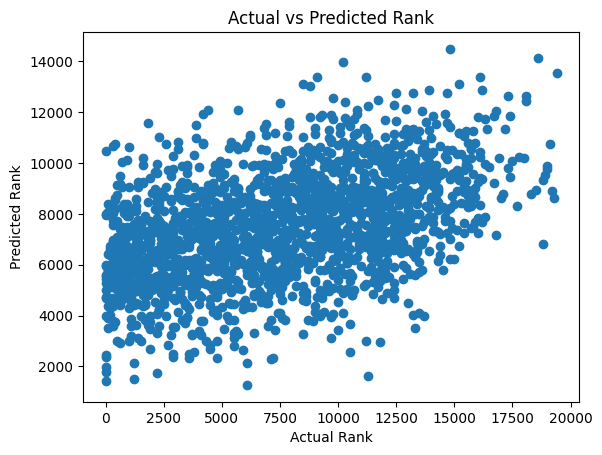

In [239]:
# check the model

# get r2 score
from sklearn.metrics import r2_score
# get predictions
# predictions = rank_model.predict(rank_model_data_read[rank_model_features])
predictions = standardized_predict(rank_model, rank_model_data_read[rank_model_features])
r2 = r2_score(rank_model_data_read['Rank'], predictions)
print('R2 Score: ', r2)

# plot the predictions
import matplotlib.pyplot as plt
plt.scatter(rank_model_data_read['Rank'], predictions)
plt.xlabel('Actual Rank')
plt.ylabel('Predicted Rank')
plt.title('Actual vs Predicted Rank')
plt.show()

In [240]:
rank_model_features

Index(['batting_order_P', 'batter_fp_mean_P',
       'batting_order_by_pitcher_handedness_P', 'est_slg_P', 'est_woba_P',
       'batter_fp_25_by_pitcher_handedness_P',
       'batter_fp_75_by_pitcher_handedness_P',
       'hr_friendly_launch_speed_freq_P', 'hr_friendly_launch_angle_freq_P',
       'WHIP_P', 'Stuff+_P', 'Location+_P', 'Pitching+_P',
       'hr_friendly_launch_speed_pitcher_P',
       'hr_friendly_launch_angle_pitcher_P',
       'pitcher_fp_75_by_batter_handedness_P', 'opp_team_fp_75_P',
       'batter_fp_25_by_batter_handedness_P',
       'batter_fp_75_by_batter_handedness_P', 'pitcher_avg_drafted_P',
       'batter_fp_pred_P', 'pitcher_fp_pred_P', 'teams_in_game_pk_P',
       'team_avg_drafted_pred_P', 'team_avg_drafted_P',
       'team_against_pitcher_avg_drafted_P',
       'team_against_pitcher_avg_drafted_pred_P',
       'pitcher_against_team_avg_drafted_P',
       'pitcher_against_team_avg_drafted_pred_P', 'team_batter_fp_pred_P',
       'team_batter_salary_P', 'ba

In [241]:
### using the model to predict the rank of lineups built by build_one_lineup to filter best possible entries and backtest potential earnings had those been entered ###
# scrapped 5/26 as data was not correct and 6/2 as it was giving errors

lineups_to_build = 20
iterations = lineups_to_build *5
# def backtest_with_filter():
files = get_files()

# read model from 'C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav'
model = pickle.load(open('C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav', 'rb'))

all_sum_fpts = []
all_lineup_ranks = []
all_lineup_payoffs = []
#all_lineup_utilities = []
all_lineup_rank_preds = []
bad_lineups = []
great_lineups = []
cashing_lineups = []
non_cashing_lineups = []
# create a table for earnings per day
earnings = pd.DataFrame(columns=['Date', 'Top Lineups Earnings', 'GeneratedAt', 'All Lineups Earnings', 'Best_result'])
all_lineups = pd.DataFrame(columns=['Date', 'Rank', 'Rank_pred', 'Payoff'])

for file in files:
    # proceed if file name is like 'MLBContestStandingsMMDDYYYY.csv' and 'DKSalariesMLBMMDDYYYY.csv'
    if 'MLBContestStandings' in file:
        date = file[-12:-4]
        m = str(date[0:2])
        d = str(date[2:4])
        y = str(date[4:8])
        # break if date is 06/02
        #if int(d) > 2 and int(m) == 6:
        if True:
            todays_lineups = pd.DataFrame(columns=['Date', 'Rank', 'Rank_pred', 'Payoff'])
            print('Getting data for ', m, d, y)
            contest_data = get_contest_standings(y, m, d)
            contest_player_results = get_contest_results(contest_data)
            leaderboard = get_leaderboard(contest_data)
            # skip if leaderboard has > 20000 rows or < 13000 rows
            if True: #leaderboard.shape[0] < 20000 and leaderboard.shape[0] > 13000:
                
                # change 'Player' to 'Name' in contest_player_results
                contest_player_results = contest_player_results.rename(columns={'Player': 'Name'})

                # convert contest_player_results to a dictionary with 'Name' as key and 'FPTS' as value
                contest_player_results = contest_player_results.set_index('Name')['FPTS'].to_dict()
                
                #someday will implement this rather than the below scripting, but for now keeping things as before
                #build_my_lineups(lineups_to_build, iterations, bans, max_own_goal, stdev, year, month, day, optional='', df=df)
                all_variables = get_all_variables(y, m, d, optional='', df=df)

                payoff_total = 0
                max_fpts = 0
                # max_lineup_rank = 100000
                
                # define an empty array to store lineups that rank > 14000
                
                # build 1500 lineups and predict rank based on model; get the 150 lineups with lowest predicted rank; otherwise same as above
                for i in tqdm(range(iterations)):
                    lineup = build_one_lineup(all_variables)                        # get only variables for players with names in lineup_players
                    #lineup_vars = all_variables[(all_variables['Name']).isin(lineup['Name'])]
                    lineup_names = lineup['Name'].to_list()
                    lineup_positions = lineup['position'].to_list()
                    # convert lineup to string formatted for get_lineup_summary
                    lineup_players = ''
                    for i in range(len(lineup_names)):
                        lineup_players += lineup_positions[i] + ',' + lineup_names[i].lower() + '/'

                    
                    # add a dummy column to lineup_vars to groupby
                    lineup_rank = 'dummy'
                    combined_vars = get_lineup_summary(lineup_players, lineup_rank, date, all_variables.drop(columns=['ID']))
                    # positions = ['p ', 'c ', '1b ', '2b ', '3b ', 'ss ', 'of ']
                    # for position in positions:
                    #     lineup_players = lineup_players.replace(position, '/' + position.strip() +',')
                    # lineup_players = lineup_players.replace(' /', '/')
                    # lineup_players = lineup_players.split('/')
                    
                    # if combined_vars is empty, skip to next iteration
                    if combined_vars.empty:
                        continue
                    
                    # get rank predictions
                    lineup_rank_prediction = standardized_predict(rank_model, combined_vars[rank_model_features]) #rank_model.predict(combined_vars[rank_model_features])
                    lineup_rank_prediction = lineup_rank_prediction[0]

                    # get actual fpts for lineup based on contest_player_results
                    lineup['fpts'] = lineup['Name'].map(contest_player_results)
                    lineup_fpts = lineup['fpts'].sum()
                    
                    if lineup_fpts > max_fpts:
                        max_fpts = lineup_fpts
                    # get rank of lineup in leaderboard
                    lineup_rank = get_leaderboard_rank(leaderboard, lineup_fpts)

                    # create a collection of lineups if they rank > 14000
                    if lineup_rank > 14000:
                        bad_lineups.append(lineup)

                    if lineup_rank < 100:
                        great_lineups.append(lineup)

                    if lineup_rank < 3500:
                        cashing_lineups.append(lineup)

                    if lineup_rank > 3500: 
                        non_cashing_lineups.append(lineup)

                    # get payoff based on rank
                    this_payoff = get_payoff(lineup_rank)

                    # add current results to arrays
                    all_sum_fpts.append(lineup['player_fp_pred'].sum())
                    all_lineup_ranks.append(lineup_rank)
                    all_lineup_payoffs.append(this_payoff)
                    #all_lineup_utilities.append(lineup['Utility'].sum())
                    all_lineup_rank_preds.append(lineup_rank_prediction)

                    # add to todays_lineups
                    todays_lineups = pd.concat([todays_lineups, pd.DataFrame({'Date': [date], 'Rank': [lineup_rank], 'Rank_pred': [lineup_rank_prediction], 'Payoff': [this_payoff]})])
                # get the payoff_total for all generated lineups
                payoff_total_all = todays_lineups['Payoff'].sum()
                
                # add to all_lineups
                all_lineups = pd.concat([all_lineups, todays_lineups])
                # get the 20 lineups with the lowest predicted rank
                todays_lineups = todays_lineups.sort_values(by='Rank_pred').head(lineups_to_build)

                payoff_total = todays_lineups['Payoff'].sum()


                # add to earnings table
                timestamp = datetime.datetime.now().time()
                earnings = pd.concat([earnings, pd.DataFrame({'Date': [date], 'Top Lineups Earnings': [payoff_total], 'GeneratedAt': [timestamp], 'All Lineups Earnings': [payoff_total_all], 'Best_result': [max_fpts]})])
                if(payoff_total_all == iterations * (-15)):
                    print('Exiting loop. All entry fees lost on ', date, '.')
                    break

    #return all_lineups, earnings, bad_lineups, great_lineups, cashing_lineups, non_cashing_lineups



Getting data for  05 23 2024
Getting contest standings for  05 / 23 / 2024


100%|██████████| 100/100 [00:11<00:00,  8.73it/s]


Getting data for  05 24 2024
Getting contest standings for  05 / 24 / 2024


100%|██████████| 100/100 [00:16<00:00,  6.17it/s]


Getting data for  05 27 2024
Getting contest standings for  05 / 27 / 2024


100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Getting data for  05 28 2024
Getting contest standings for  05 / 28 / 2024


100%|██████████| 100/100 [00:35<00:00,  2.78it/s]


Getting data for  05 29 2024
Getting contest standings for  05 / 29 / 2024


100%|██████████| 100/100 [00:21<00:00,  4.57it/s]


Getting data for  05 30 2024
Getting contest standings for  05 / 30 / 2024


100%|██████████| 100/100 [00:11<00:00,  9.09it/s]


Getting data for  05 31 2024
Getting contest standings for  05 / 31 / 2024


100%|██████████| 100/100 [00:24<00:00,  4.05it/s]


Getting data for  06 02 2024
Getting contest standings for  06 / 02 / 2024


100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


Getting data for  06 03 2024
Getting contest standings for  06 / 03 / 2024


100%|██████████| 100/100 [00:22<00:00,  4.42it/s]


Getting data for  06 04 2024
Getting contest standings for  06 / 04 / 2024


100%|██████████| 100/100 [00:20<00:00,  4.99it/s]


Getting data for  06 05 2024
Getting contest standings for  06 / 05 / 2024


100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


Getting data for  06 06 2024
Getting contest standings for  06 / 06 / 2024


100%|██████████| 100/100 [00:12<00:00,  7.92it/s]


Getting data for  06 07 2024
Getting contest standings for  06 / 07 / 2024


100%|██████████| 100/100 [00:27<00:00,  3.70it/s]


Getting data for  06 08 2024
Getting contest standings for  06 / 08 / 2024


100%|██████████| 100/100 [00:21<00:00,  4.55it/s]


Getting data for  06 09 2024
Getting contest standings for  06 / 09 / 2024


100%|██████████| 100/100 [00:45<00:00,  2.21it/s]


Getting data for  06 10 2024
Getting contest standings for  06 / 10 / 2024


100%|██████████| 100/100 [00:12<00:00,  8.29it/s]


Getting data for  06 11 2024
Getting contest standings for  06 / 11 / 2024


100%|██████████| 100/100 [00:22<00:00,  4.42it/s]


Getting data for  06 12 2024
Getting contest standings for  06 / 12 / 2024


100%|██████████| 100/100 [00:10<00:00,  9.11it/s]


Getting data for  06 13 2024
Getting contest standings for  06 / 13 / 2024


100%|██████████| 100/100 [00:12<00:00,  8.28it/s]


Getting data for  06 14 2024
Getting contest standings for  06 / 14 / 2024


100%|██████████| 100/100 [01:00<00:00,  1.64it/s]


Getting data for  06 15 2024
Getting contest standings for  06 / 15 / 2024


100%|██████████| 100/100 [00:13<00:00,  7.17it/s]


Getting data for  06 16 2024
Getting contest standings for  06 / 16 / 2024


100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Getting data for  06 17 2024
Getting contest standings for  06 / 17 / 2024


100%|██████████| 100/100 [00:23<00:00,  4.20it/s]


Getting data for  06 18 2024
Getting contest standings for  06 / 18 / 2024


100%|██████████| 100/100 [00:18<00:00,  5.51it/s]


Getting data for  06 19 2024
Getting contest standings for  06 / 19 / 2024


100%|██████████| 100/100 [00:11<00:00,  8.50it/s]


Getting data for  06 20 2024
Getting contest standings for  06 / 20 / 2024


100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


Getting data for  06 21 2024
Getting contest standings for  06 / 21 / 2024


100%|██████████| 100/100 [00:27<00:00,  3.61it/s]


Getting data for  06 22 2024
Getting contest standings for  06 / 22 / 2024


100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


Getting data for  07 14 2024
Getting contest standings for  07 / 14 / 2024


100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Getting data for  07 19 2024
Getting contest standings for  07 / 19 / 2024


100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


Getting data for  07 20 2024
Getting contest standings for  07 / 20 / 2024


100%|██████████| 100/100 [00:30<00:00,  3.28it/s]


Getting data for  07 21 2024
Getting contest standings for  07 / 21 / 2024


100%|██████████| 100/100 [00:21<00:00,  4.59it/s]


Getting data for  07 22 2024
Getting contest standings for  07 / 22 / 2024


100%|██████████| 100/100 [00:20<00:00,  4.80it/s]


Getting data for  07 23 2024
Getting contest standings for  07 / 23 / 2024


100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Getting data for  07 24 2024
Getting contest standings for  07 / 24 / 2024


100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


Getting data for  07 25 2024
Getting contest standings for  07 / 25 / 2024


100%|██████████| 100/100 [00:13<00:00,  7.52it/s]


Getting data for  07 26 2024
Getting contest standings for  07 / 26 / 2024


100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


Getting data for  07 27 2024
Getting contest standings for  07 / 27 / 2024


100%|██████████| 100/100 [00:23<00:00,  4.31it/s]


Getting data for  07 28 2024
Getting contest standings for  07 / 28 / 2024


100%|██████████| 100/100 [00:28<00:00,  3.53it/s]


Getting data for  07 29 2024
Getting contest standings for  07 / 29 / 2024


100%|██████████| 100/100 [00:13<00:00,  7.56it/s]


Getting data for  07 30 2024
Getting contest standings for  07 / 30 / 2024


100%|██████████| 100/100 [01:20<00:00,  1.25it/s]


Getting data for  07 31 2024
Getting contest standings for  07 / 31 / 2024


100%|██████████| 100/100 [00:13<00:00,  7.19it/s]


Getting data for  08 01 2024
Getting contest standings for  08 / 01 / 2024


100%|██████████| 100/100 [00:12<00:00,  7.95it/s]


Getting data for  08 02 2024
Getting contest standings for  08 / 02 / 2024


100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


Getting data for  08 03 2024
Getting contest standings for  08 / 03 / 2024


100%|██████████| 100/100 [00:10<00:00,  9.52it/s]


In [242]:
# check lowest 10 batter_drafted_delta players in all_variables
# all_variables['batter_drafted_delta'] = np.where(all_variables['position'] != 'P', all_variables['player_drafted_pred'] - all_variables['team_avg_drafted_pred'], 0)
# # map fpts to player names
# all_variables['fpts'] = all_variables['Name'].map(contest_player_results)
# all_variables[all_variables['position'] != 'P'].sort_values(by='fpts', ascending=False).head(20)
lineup

,Name,batting_order,Roster Position_x,p_throws,stand,batter_fp_mean,batter_14_plus,batting_order_by_pitcher_handedness,est_slg,est_woba,batter_fp_25_by_pitcher_handedness,batter_fp_75_by_pitcher_handedness,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,pitcher_20_plus,WHIP,Stuff+,Location+,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,pitcher_fp_75_by_batter_handedness,opp_team_fp_75,batter_fp_25_by_batter_handedness,batter_fp_75_by_batter_handedness,pitcher_avg_drafted,teams_in_game_pk,is_of,batter_fp_pred,pitcher_fp_pred,team_avg_drafted_pred,team_avg_drafted,team_against_pitcher_avg_drafted,team_against_pitcher_avg_drafted_pred,pitcher_against_team_avg_drafted,pitcher_against_team_avg_drafted_pred,team_batter_fp_pred,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,batter_payoff_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred,batter_name_lower,pitcher_name_lower,Position,Name + ID,ID,position,Salary,Game Info,team,AvgPointsPerGame,Name_lower,player_fp_pred,player_drafted_pred,payoff,opp_team,opp_mean_pred,P,C,1B,2B,3B,SS,OF,build_pred,top_drafted_pitcher,likelihood,team_build_pred_avg,WSH,CHC,STL,TOR,MIL,NYY,is_stacked,is_selected_pitcher,end_of_lineup,var,fpts
16,dj herz,9,OF,L,R,9,0,6,0,0,0,10,0,0,1,1,93,99,97,0,0,21,83,1,9,15,6,1,6,20,5,5,9,10,14,15,56,32800,5,18,6,18,7,17,jackson chourio,dj herz,SP,DJ Herz (35295997),35295997,P,6900,MIL@WSH 08/03/2024 04:05PM ET,WSH,14,dj herz,21,18,17,MIL,6,1,0,0,0,0,0,0,78,1,50,32,0,0,0,0,5,0,0,1,0,var53,25
11,carlos rodon,3,1B/3B,R,R,9,0,3,0,0,3,13,0,0,1,1,123,97,103,0,0,20,72,1,8,26,6,1,7,22,5,6,5,6,9,9,56,30200,4,23,6,24,2,17,vladimir guerrero,carlos rodon,SP,Carlos Rodon (35295993),35295993,P,9100,TOR@NYY 08/03/2024 01:05PM ET,NYY,17,carlos rodon,23,24,17,TOR,6,1,0,0,0,0,0,0,74,1,49,33,0,0,0,5,0,0,0,1,0,var54,23
33,keibert ruiz,3,C,R,L,5,0,6,0,0,0,8,0,0,0,1,98,100,100,0,0,14,87,1,8,14,6,0,8,5,5,5,4,4,14,14,64,29300,4,13,7,12,3,4,keibert ruiz,aaron civale,C,Keibert Ruiz (35296041),35296041,C,3500,MIL@WSH 08/03/2024 04:05PM ET,WSH,5,keibert ruiz,8,4,7,MIL,4,0,1,0,0,0,0,0,33,0,16,32,1,0,0,0,0,0,1,0,0,var19,7
44,paul goldschmidt,3,1B,R,R,8,0,4,0,0,3,10,0,0,0,1,87,108,103,0,0,19,70,2,9,12,6,0,8,8,8,6,9,10,12,15,68,36200,9,4,7,5,7,8,paul goldschmidt,jameson taillon,1B,Paul Goldschmidt (35296009),35296009,1B,4800,STL@CHC 08/03/2024 02:20PM ET,STL,7,paul goldschmidt,8,9,7,CHC,7,0,0,1,0,0,0,0,56,0,25,29,0,0,1,0,0,0,1,0,0,var2,0
41,nico hoerner,5,2B,R,R,5,0,3,0,0,3,8,0,0,0,1,93,97,94,0,0,18,79,1,8,19,6,0,8,5,6,6,6,7,13,14,69,35100,4,18,7,18,4,4,nico hoerner,kyle gibson,2B,Nico Hoerner (35296025),35296025,2B,4000,STL@CHC 08/03/2024 02:20PM ET,CHC,7,nico hoerner,8,4,7,STL,5,0,0,0,1,0,0,0,37,0,18,27,0,1,0,0,0,0,1,0,0,var12,13
42,nolan arenado,5,3B,R,R,5,0,5,0,0,3,10,0,0,0,1,87,108,103,0,0,19,70,2,9,12,6,0,7,7,8,6,9,10,12,15,68,36200,7,5,6,5,7,8,nolan arenado,jameson taillon,3B,Nolan Arenado (35296023),35296023,3B,4100,STL@CHC 08/03/2024 02:20PM ET,STL,6,nolan arenado,7,7,6,CHC,7,0,0,0,0,1,0,0,29,0,20,29,0,0,1,0,0,0,1,0,0,var7,10
37,masyn winn,9,SS,L,R,9,0,4,0,0,3,10,0,0,0,1,87,108,103,0,0,19,70,2,9,12,6,0,7,6,8,6,9,10,12,15,68,36200,4,4,8,5,7,8,masyn winn,jameson taillon,SS,Masyn Winn (35296016),35296016,SS,4300,STL@CHC 08/03/2024 02:20PM ET,STL,7,masyn winn,7,4,8,CHC,7,0,0,0,0,0,1,0,15,0,19,29,0,0,1,0,0,0,1,0,1,var11,0
13,cody bellinger,3,OF,L,L,9,0,3,0,0,3,12,0,0,0,1,93,97,94,0,0,18,79,1,8,19,6,1,8,4,6,6,6,7,13,14,69,35100,5,18,8,18,4,4,cody bellinger,kyle gibson,OF,Cody Bellinger (35296001),35296001,OF,5500,STL@CHC 08/03/2024 02:20PM ET,CHC,8,cody bellinger,8,5,8,STL,5,0,0,0,0,0,0,1,34,0,15,27,0,1,0,0,0,0,1,0,0,var24,0
48,seiya suzuki,2,OF,R,R,8,0,3,0,0,3,13,0,0,0,1,93,97,94,0,0,18,79,1,8,19,6,1,8,5,6,6,6,7,13,14,69,35100,6,18,8,18,4,4,seiya suzuki,kyle gibson,OF,Seiya Suzuki (35296008),35296008,OF,4800,STL@CHC 08/03/2024 02:20PM ET,CHC,9,seiya suzuki,8,6,8,STL,5,0,0,0,0,0,0,1,37,0,14,27,0,1,0,0,0,0,1,0,0,var28,

In [243]:
# # test = get_contest_results(contest_data)
# # test = test.dropna()
# # test[test['Player'].str.contains('gon')]
# test = contest_data['Player']
# for player in test:
#     # if not na
#     if not pd.isna(player):
#         print(player)

In [244]:
earnings

,Date,Top Lineups Earnings,GeneratedAt,All Lineups Earnings,Best_result
0,05232024,410,08:47:47.162988,1205,176
0,05242024,600,08:48:04.664232,355,189
0,05272024,-75,08:48:21.538815,-665,156
0,05282024,-210,08:48:58.422972,-895,173
0,05292024,35,08:49:21.420009,890,174
0,05302024,100,08:49:33.267305,120,140
0,05312024,175,08:49:59.185416,365,172
0,06022024,-90,08:50:19.678378,-540,124
0,06032024,-210,08:50:43.502754,-925,152
0,06042024,-210,08:51:06.099204,995,180


In [245]:
pct_earnings = earnings.copy()
pct_earnings['Top Lineups Earnings'] = pct_earnings['Top Lineups Earnings'].astype(float)/(lineups_to_build*15)*100
pct_earnings['All Lineups Earnings'] = pct_earnings['All Lineups Earnings'].astype(float)/(iterations*15)*100
pct_earnings = pct_earnings.rename(columns={'Top Lineups Earnings': 'Top Lineups Earnings (%)', 'All Lineups Earnings': 'All Lineups Earnings (%)'})
print('Total top lineups earnings: ', pct_earnings['Top Lineups Earnings (%)'].sum(), 'Total all lineups earnings: ', pct_earnings['All Lineups Earnings (%)'].sum())
pct_earnings

Total top lineups earnings:  17891.666666666664 Total all lineups earnings:  6469.0


,Date,Top Lineups Earnings (%),GeneratedAt,All Lineups Earnings (%),Best_result
0,05232024,137,08:47:47.162988,80,176
0,05242024,200,08:48:04.664232,24,189
0,05272024,-25,08:48:21.538815,-44,156
0,05282024,-70,08:48:58.422972,-60,173
0,05292024,12,08:49:21.420009,59,174
0,05302024,33,08:49:33.267305,8,140
0,05312024,58,08:49:59.185416,24,172
0,06022024,-30,08:50:19.678378,-36,124
0,06032024,-70,08:50:43.502754,-62,152
0,06042024,-70,08:51:06.099204,66,180


In [246]:
# programatically get the date
todays_date = get_todays_date()
year =  todays_date.split('-')[0]
month = todays_date.split('-')[1]
day = todays_date.split('-')[2]


In [247]:
# Get a single lineup ranked as the best of num_lineups
# (use when entering single-bullet)
# model = pickle.load(open('C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav', 'rb'))
# num_lineups = 100
# #optional = ''
# #all_variables = get_all_variables(year, month, day, optional=optional, df=df)
# # build num_lineups using build_one_lineup and get the best option
# def get_best_lineup(num_lineups, all_variables=all_variables, model=model):
#     best_lineup_rank = 100000
#     best_lineup = pd.DataFrame()
#     for i in range(num_lineups):
#         lineup = build_one_lineup(all_variables, all_variables)
#         # get only variables for players with names in lineup_players
#         lineup_vars = all_variables[(all_variables['Name']).isin(lineup['Name'])]

#         # add a dummy column to lineup_vars to groupby
#         lineup_vars['Rank'] = 'dummy'

#         lineup_hitters = lineup_vars[lineup_vars['position'] != 'P']
#         lineup_pitchers = lineup_vars[lineup_vars['position'] == 'P']

#         lineup_hitters = lineup_hitters.groupby(['Rank']).mean(numeric_only=True).reset_index()
#         lineup_pitchers = lineup_pitchers.groupby(['Rank']).mean(numeric_only=True).reset_index()

#         # rename pitcher columns by suffixing with '_pitcher'
#         lineup_pitchers = lineup_pitchers.add_suffix('_pitcher')
#         lineup_pitchers = lineup_pitchers.rename(columns={'Rank_pitcher': 'Rank'})

#         # merge hitters and pitchers on Rank and Date
#         combined_vars = pd.merge(lineup_hitters, lineup_pitchers, on=['Rank'])

#         # drop Rank
#         combined_vars = combined_vars.drop(columns='Rank')

#         # get rank predictions
#         lineup_rank_prediction = model.predict(combined_vars)
#         lineup_rank_prediction = lineup_rank_prediction[0]

#         if lineup_rank_prediction < best_lineup_rank:
#             best_lineup = lineup

#     return best_lineup

# top_lineup = get_best_lineup(num_lineups)

# # get top lineup
# top_lineup

(array([319., 269., 288., 238., 247., 230., 197., 243., 216., 193., 160.,
        193., 175., 162., 143., 129., 119., 122., 129., 103.,  86.,  95.,
         67.,  59.,  46.,  26.,  30.,  16.,  16.,  11.,   9.,  11.,   9.,
          7.,   1.,   5.,   7.,   2.,   5.,   1.,   6.,   6.,   2.,  11.,
          7.,   5.,   2.,   3.,   1.,   4.,   4.,   3.,   3.,   6.,   3.,
          3.,   3.,   2.,   3.,   2.,   4.,   3.,   1.,   1.,   3.,   3.,
          1.,   1.,   2.,   1.,   4.,   3.,   0.,   1.,   1.,   1.,   1.,
          2.,   0.,   4.]),
 array([1.00000e+00, 5.83600e+02, 1.16620e+03, 1.74880e+03, 2.33140e+03,
        2.91400e+03, 3.49660e+03, 4.07920e+03, 4.66180e+03, 5.24440e+03,
        5.82700e+03, 6.40960e+03, 6.99220e+03, 7.57480e+03, 8.15740e+03,
        8.74000e+03, 9.32260e+03, 9.90520e+03, 1.04878e+04, 1.10704e+04,
        1.16530e+04, 1.22356e+04, 1.28182e+04, 1.34008e+04, 1.39834e+04,
        1.45660e+04, 1.51486e+04, 1.57312e+04, 1.63138e+04, 1.68964e+04,
        1.74790e

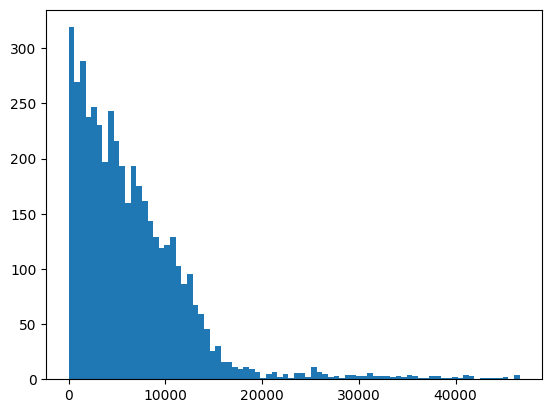

In [248]:
# histogram of all_lineups Ranks
plt.hist(all_lineups['Rank'], bins=80)

In [249]:
len(all_lineups)

4500

In [250]:
# how many in bad_lineups
len(bad_lineups)


315

In [251]:
len(great_lineups)

#great_lineups[2]

51

In [252]:
great_and_bad_lineups_hitters = pd.DataFrame()
great_and_bad_lineups_pitchers = pd.DataFrame()
great_and_bad_lineups = pd.DataFrame()
features = ['position', 'player_drafted_pred', 'batter_payoff_pred', 'opp_mean_pred', 'team_batter_fp_pred', 'player_fp_pred', 'WHIP', 'est_woba', 'est_slg', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher', 'batter_fp_pred', 'pitcher_fp_pred', 'team_batter_fp_pred', 'team_batter_salary', 'batter_drafted_pred', 'pitcher_drafted_pred', 'opp_pitcher_drafted_mean', 'opp_batter_drafted_mean', 'pitcher_payoff_pred', 'Salary', 'AvgPointsPerGame']

# find the difference between the great_lineups and bad_lineups
for i in range(len(great_lineups)):
    # get each lineup individually
    this_lineup_avgs = great_lineups[i]
    this_lineup_avgs = this_lineup_avgs[features]
    
    # drop fpts and add great_lineup column = 1
    #this_lineup_avgs = this_lineup_avgs.drop('fpts')
    this_lineup_avgs['great_lineup'] = 1
    # split by hitters and pitchers
    this_lineup_avgs_hitters = this_lineup_avgs[this_lineup_avgs['position'] != 'P']
    this_lineup_avgs_pitchers = this_lineup_avgs[this_lineup_avgs['position'] == 'P']

    # drop position
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.drop(columns='position')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.drop(columns='position')

    # coerce to numeric
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.astype(float, errors='ignore')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.astype(float, errors='ignore')

    # get mean of numerics
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.mean(numeric_only=True)
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.mean(numeric_only=True)
    # convert to dataframe
    this_lineup_avgs_hitters = pd.DataFrame(this_lineup_avgs_hitters).transpose()
    this_lineup_avgs_pitchers = pd.DataFrame(this_lineup_avgs_pitchers).transpose()
    # concat to great_and_bad_lineups
    great_and_bad_lineups_hitters = pd.concat([great_and_bad_lineups_hitters, this_lineup_avgs_hitters])
    great_and_bad_lineups_pitchers = pd.concat([great_and_bad_lineups_pitchers, this_lineup_avgs_pitchers])

    # add '_pitcher' to this_lineup_avgs_pitchers columns
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.add_suffix('_pitcher')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.rename(columns={'great_lineup_pitcher': 'great_lineup'})
    all_lineup_data = pd.merge(this_lineup_avgs_hitters, this_lineup_avgs_pitchers, on=['great_lineup'])
    great_and_bad_lineups = pd.concat([great_and_bad_lineups, all_lineup_data])

for i in range(len(bad_lineups)):
    # do the same but set great_lineup to 0
    this_lineup_avgs = bad_lineups[i]
    this_lineup_avgs = this_lineup_avgs[features]
    
    #this_lineup_avgs = this_lineup_avgs.drop('fpts')
    this_lineup_avgs['great_lineup'] = 0
    this_lineup_avgs_hitters = this_lineup_avgs[this_lineup_avgs['position'] != 'P']
    this_lineup_avgs_pitchers = this_lineup_avgs[this_lineup_avgs['position'] == 'P']

    # drop position
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.drop(columns='position')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.drop(columns='position')

    # coerce to numeric
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.astype(float, errors='ignore')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.astype(float, errors='ignore')

    this_lineup_avgs_hitters = this_lineup_avgs_hitters.mean(numeric_only=True)
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.mean(numeric_only=True)

    this_lineup_avgs_hitters = pd.DataFrame(this_lineup_avgs_hitters).transpose()
    this_lineup_avgs_pitchers = pd.DataFrame(this_lineup_avgs_pitchers).transpose()

    great_and_bad_lineups_hitters = pd.concat([great_and_bad_lineups_hitters, this_lineup_avgs_hitters])
    great_and_bad_lineups_pitchers = pd.concat([great_and_bad_lineups_pitchers, this_lineup_avgs_pitchers])
    
    # add '_pitcher' to this_lineup_avgs_pitchers columns
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.add_suffix('_pitcher')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.rename(columns={ 'great_lineup_pitcher': 'great_lineup'})
    all_lineup_data = pd.merge(this_lineup_avgs_hitters, this_lineup_avgs_pitchers, on=['great_lineup'])
    great_and_bad_lineups = pd.concat([great_and_bad_lineups, all_lineup_data])


In [253]:
great_and_bad_lineups.head()

,player_drafted_pred,batter_payoff_pred,opp_mean_pred,team_batter_fp_pred,player_fp_pred,WHIP,est_woba,est_slg,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,batter_fp_pred,pitcher_fp_pred,team_batter_fp_pred,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred,Salary,AvgPointsPerGame,great_lineup,player_drafted_pred_pitcher,batter_payoff_pred_pitcher,opp_mean_pred_pitcher,team_batter_fp_pred_pitcher,player_fp_pred_pitcher,WHIP_pitcher,est_woba_pitcher,est_slg_pitcher,hr_friendly_launch_speed_pitcher_pitcher,hr_friendly_launch_angle_pitcher_pitcher,batter_fp_pred_pitcher,pitcher_fp_pred_pitcher,team_batter_fp_pred_pitcher,team_batter_salary_pitcher,batter_drafted_pred_pitcher,pitcher_drafted_pred_pitcher,opp_pitcher_drafted_mean_pitcher,opp_batter_drafted_mean_pitcher,pitcher_payoff_pred_pitcher,Salary_pitcher,AvgPointsPerGame_pitcher
0,7,7,10,68,8,2,0,0,0,0,8,10,68,35750,7,5,5,7,9,4200,7,1,19,7,7,62,19,1,0,0,0,0,7,18,62,35500,5,19,19,4,15,8200,16
0,5,8,8,69,8,1,0,0,0,0,8,8,69,39112,5,10,11,4,7,4438,7,1,26,7,6,58,20,1,0,0,0,0,7,21,58,33250,8,26,26,5,16,7200,11
0,8,8,5,71,8,1,0,0,0,0,8,5,71,36388,8,5,5,7,4,4450,8,1,26,7,6,58,20,1,0,0,0,0,7,21,58,33250,8,26,26,5,16,7200,11
0,8,7,7,70,8,2,0,0,0,0,8,7,70,36212,8,7,7,8,6,4088,6,1,21,7,6,58,20,1,0,0,0,0,7,19,58,37250,4,20,21,2,16,8650,15
0,4,8,10,67,7,1,0,0,0,0,7,10,67,37600,4,12,12,4,7,3988,7,1,21,7,7,60,19,1,0,0,0,0,7,18,60,36550,5,21,21,4,14,9000,20


In [254]:
great_and_bad_lineups_hitters[great_and_bad_lineups_hitters['great_lineup'] == 1]


,player_drafted_pred,batter_payoff_pred,opp_mean_pred,team_batter_fp_pred,player_fp_pred,WHIP,est_woba,est_slg,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,batter_fp_pred,pitcher_fp_pred,team_batter_fp_pred,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred,Salary,AvgPointsPerGame,great_lineup
0,7,7,10,68,8,2,0,0,0,0,8,10,68,35750,7,5,5,7,9,4200,7,1
0,5,8,8,69,8,1,0,0,0,0,8,8,69,39112,5,10,11,4,7,4438,7,1
0,8,8,5,71,8,1,0,0,0,0,8,5,71,36388,8,5,5,7,4,4450,8,1
0,8,7,7,70,8,2,0,0,0,0,8,7,70,36212,8,7,7,8,6,4088,6,1
0,4,8,10,67,7,1,0,0,0,0,7,10,67,37600,4,12,12,4,7,3988,7,1
0,7,7,7,70,8,1,0,0,0,0,8,8,70,35725,7,6,6,6,6,3900,6,1
0,3,7,20,59,7,1,0,0,0,0,7,20,59,35812,3,18,18,2,16,4162,7,1
0,5,7,12,66,7,1,0,0,0,0,7,12,66,37712,5,10,10,5,10,3862,6,1
0,4,7,12,66,8,1,0,0,0,0,8,12,66,34250,4,20,21,4,8,4512,7,1
0,6,8,4,72,8,1,0,0,0,0,8,4,72,37075,6,8,9,5,5,4300,8,1


In [255]:
great_and_bad_lineups_hitters[great_and_bad_lineups_hitters['great_lineup'] == 0]


,player_drafted_pred,batter_payoff_pred,opp_mean_pred,team_batter_fp_pred,player_fp_pred,WHIP,est_woba,est_slg,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,batter_fp_pred,pitcher_fp_pred,team_batter_fp_pred,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred,Salary,AvgPointsPerGame,great_lineup
0,8,8,6,70,8,1,0,0,0,0,8,6,70,38050,8,6,6,7,5,4188,7,0
0,5,8,3,72,8,1,0,0,0,0,8,4,72,36250,5,8,8,4,4,4200,6,0
0,6,8,5,70,8,1,0,0,0,0,8,5,70,32225,6,8,8,6,5,4250,7,0
0,6,8,6,69,8,1,0,0,0,0,8,6,69,31800,6,9,9,5,5,3988,7,0
0,4,7,8,68,8,1,0,0,0,0,8,8,68,35075,4,10,10,4,8,4012,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,7,7,6,70,8,1,0,0,0,0,8,6,70,37938,7,4,4,7,6,4150,7,0
0,7,8,5,71,8,1,0,0,0,0,8,4,71,34250,7,14,15,6,3,4012,7,0
0,5,8,7,69,8,1,0,0,0,0,8,7,69,38275,5,5,5,5,6,4162,7,0
0,4,8,7,69,8,1,0,0,0,0,8,7,69,37925,4,7,7,5,6,4125,7,0


In [256]:
def get_classifier_model(df, target, features):
    output = df[target]
    model_features = df[features]
    
    model = LogisticRegression()
    model.fit(model_features, output)
    return model


In [257]:
# commenting out 'great_lineup' prediction model since it does not seem to be working correctly

# create a model to predict if a lineup is a great lineup based on pregame factors
# # target is great_lineup, features are pregame factors
target = great_and_bad_lineups['great_lineup']
# # # feature_names are: avg_batter_fp	avg_batting_order	est_woba	est_slg	est_ba	hr_friendly_launch_speed_freq	hr_friendly_launch_angle_freq	Pitching+	WHIP	hr_friendly_launch_speed_pitcher	hr_friendly_launch_angle_pitcher	batting_order_change	batter_fp_pred	pitcher_fp_pred	team_batter_fp_pred	teams_in_game_pk	team_batter_salary	batter_drafted_pred	pitcher_drafted_pred	payoff_pred	opp_pitcher_drafted_mean	opp_batter_drafted_mean	pitcher_payoff_pred	ID	Salary	AvgPointsPerGame	player_fp_pred	player_drafted_pred	payoff	opp_mean_pred net_sqrt_pred Utility
# feature_names = great_and_bad_lineups.columns[great_and_bad_lineups.columns != 'great_lineup']
# features = great_and_bad_lineups[feature_names]
# # split the data
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

# # establish a model
# model_is_great_lineup = LinearRegression()

# # fit the model
# model_is_great_lineup.fit(X_train, y_train)

# # predict the model
# y_pred = model_is_great_lineup.predict(X_test)

# # calculate r2 and rmse
# r2 = r2_score(y_test, y_pred)
# rmse = sqrt(mean_squared_error(y_test, y_pred))

# print('Model R2: ', r2)
# print('Model RMSE: ', rmse)

# # importance of each feature
# importance = model_is_great_lineup.coef_
# # summarize feature importance
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# plt.bar([x for x in range(len(importance))], importance)
# plt.show()

# do the above for a decision tree classifier model

# # establish a model
# model_is_great_lineup = DecisionTreeClassifier()

# # fit the model
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)
# model_is_great_lineup.fit(X_train, y_train)
# importance = model_is_great_lineup.feature_importances_

# # summarize feature importance
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# plt.bar([x for x in range(len(importance))], importance)
# plt.show()

# select best features
great_lineup_features, great_lineup_data = select_best_features(great_and_bad_lineups.drop(columns='great_lineup'), target)

# classifier model
model_is_great_lineup = get_classifier_model(great_and_bad_lineups, 'great_lineup', great_lineup_features)

# save the model
filename = 'C:\\Users\\jorda\\Downloads\\great_lineup_model.sav'
pickle.dump(model_is_great_lineup, open(filename, 'wb'))

# check the model with confusion matrix
# get predictions
predictions = model_is_great_lineup.predict(great_and_bad_lineups[great_lineup_features])
# get confusion matrix
confusion_matrix_result = confusion_matrix(great_and_bad_lineups['great_lineup'], predictions)
print('Confusion Matrix: ', confusion_matrix_result)



Confusion Matrix:  [[314   1]
 [ 47   4]]


In [258]:


# build a classification model to predict if a lineup is a great lineup
# # target is great_lineup, features are pregame factors
# target = great_and_bad_lineups_pitchers['great_lineup']
# # feature_names are: avg_batter_fp	avg_batting_order	est_woba	est_slg	est_ba	hr_friendly_launch_speed_freq	hr_friendly_launch_angle_freq	Pitching+	WHIP	hr_friendly_launch_speed_pitcher	hr_friendly_launch_angle_pitcher	batting_order_change	batter_fp_pred	pitcher_fp_pred	team_batter_fp_pred	teams_in_game_pk	team_batter_salary	batter_drafted_pred	pitcher_drafted_pred	payoff_pred	opp_pitcher_drafted_mean	opp_batter_drafted_mean	pitcher_payoff_pred	ID	Salary	AvgPointsPerGame	player_fp_pred	player_drafted_pred	payoff	opp_mean_pred net_sqrt_pred Utility
# feature_names = [ 'opp_mean_pred', 'player_fp_pred', 'WHIP', 'team_batter_fp_pred', 'team_batter_salary', 'batter_drafted_pred', 'pitcher_drafted_pred', 'batter_payoff_pred', 'Salary']
# features = great_and_bad_lineups_pitchers[feature_names]
# # split the data
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

# # establish a model
# model_is_great_lineup_pitchers = LogisticRegression()

# # fit the model
# model_is_great_lineup_pitchers.fit(X_train, y_train)

# # predict the model
# y_pred = model_is_great_lineup_pitchers.predict(X_test)

# confusion_matrix(y_test, y_pred)



In [259]:
lineups_hitters = pd.DataFrame()
lineups_pitchers = pd.DataFrame()
cashing_or_not = pd.DataFrame()
features = ['position', 'player_drafted_pred', 'batter_payoff_pred', 'opp_mean_pred', 'team_batter_fp_pred', 'player_fp_pred', 'WHIP', 'est_woba', 'est_slg', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher', 'batter_fp_pred', 'pitcher_fp_pred', 'team_batter_fp_pred', 'team_batter_salary', 'batter_drafted_pred', 'pitcher_drafted_pred', 'opp_pitcher_drafted_mean', 'opp_batter_drafted_mean', 'pitcher_payoff_pred', 'Salary', 'AvgPointsPerGame']

# find the difference between the great_lineups and bad_lineups
for i in range(len(cashing_lineups)):
    # get each lineup individually
    this_lineup_avgs = cashing_lineups[i]
    this_lineup_avgs = this_lineup_avgs[features]
    
    # drop fpts and add great_lineup column = 1
    #this_lineup_avgs = this_lineup_avgs.drop('fpts')
    this_lineup_avgs['cashing_lineup'] = 1
    # split by hitters and pitchers
    this_lineup_avgs_hitters = this_lineup_avgs[this_lineup_avgs['position'] != 'P']
    this_lineup_avgs_pitchers = this_lineup_avgs[this_lineup_avgs['position'] == 'P']

    # drop position
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.drop(columns='position')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.drop(columns='position')

    # coerce to numeric
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.astype(float, errors='ignore')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.astype(float, errors='ignore')

    # get mean of numerics
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.mean(numeric_only=True)
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.mean(numeric_only=True)
    # convert to dataframe
    this_lineup_avgs_hitters = pd.DataFrame(this_lineup_avgs_hitters).transpose()
    this_lineup_avgs_pitchers = pd.DataFrame(this_lineup_avgs_pitchers).transpose()
    # concat to great_and_bad_lineups
    lineups_hitters = pd.concat([lineups_hitters, this_lineup_avgs_hitters])
    lineups_pitchers = pd.concat([lineups_pitchers, this_lineup_avgs_pitchers])

    # add '_pitcher' to this_lineup_avgs_pitchers columns
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.add_suffix('_pitcher')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.rename(columns={'cashing_lineup_pitcher': 'cashing_lineup'})
    all_lineup_data = pd.merge(this_lineup_avgs_hitters, this_lineup_avgs_pitchers, on=['cashing_lineup'])
    cashing_or_not = pd.concat([cashing_or_not, all_lineup_data])

for i in range(len(non_cashing_lineups)):
    # get each lineup individually
    this_lineup_avgs = non_cashing_lineups[i]
    this_lineup_avgs = this_lineup_avgs[features]
    
    # drop fpts and add great_lineup column = 1
    #this_lineup_avgs = this_lineup_avgs.drop('fpts')
    this_lineup_avgs['cashing_lineup'] = 0
    # split by hitters and pitchers
    this_lineup_avgs_hitters = this_lineup_avgs[this_lineup_avgs['position'] != 'P']
    this_lineup_avgs_pitchers = this_lineup_avgs[this_lineup_avgs['position'] == 'P']

    # drop position
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.drop(columns='position')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.drop(columns='position')

    # coerce to numeric
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.astype(float, errors='ignore')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.astype(float, errors='ignore')

    # get mean of numerics
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.mean(numeric_only=True)
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.mean(numeric_only=True)
    # convert to dataframe
    this_lineup_avgs_hitters = pd.DataFrame(this_lineup_avgs_hitters).transpose()
    this_lineup_avgs_pitchers = pd.DataFrame(this_lineup_avgs_pitchers).transpose()
    # concat to great_and_bad_lineups
    lineups_hitters = pd.concat([lineups_hitters, this_lineup_avgs_hitters])
    lineups_pitchers = pd.concat([lineups_pitchers, this_lineup_avgs_pitchers])

    # add '_pitcher' to this_lineup_avgs_pitchers columns
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.add_suffix('_pitcher')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.rename(columns={'cashing_lineup_pitcher': 'cashing_lineup'})
    all_lineup_data = pd.merge(this_lineup_avgs_hitters, this_lineup_avgs_pitchers, on=['cashing_lineup'])
    cashing_or_not = pd.concat([cashing_or_not, all_lineup_data])



In [260]:
this_lineup['position'].to_list()

NameError: name 'this_lineup' is not defined

In [ ]:
cashing_or_not = pd.DataFrame()

for i in range(len(cashing_lineups)):
    # get each lineup individually
    this_lineup = cashing_lineups[i]
    # get a string of player names for get_lineup_summary
    lineup_players = ''
    for j in range(len(this_lineup)):
        lineup_players += this_lineup['position'].to_list()[j] + ',' + this_lineup['Name'].to_list()[j].lower() + '/'
    this_lineup = get_lineup_summary(lineup_players, 'dummy', 'date', this_lineup)
    this_lineup['cashing_lineup'] = 1
    cashing_or_not = pd.concat([cashing_or_not, this_lineup])

for i in range(len(non_cashing_lineups)):
    # get each lineup individually
    this_lineup = non_cashing_lineups[i]
    # get a string of player names for get_lineup_summary
    lineup_players = ''
    for j in range(len(this_lineup)):
        lineup_players += this_lineup['position'].to_list()[j] + ',' + this_lineup['Name'].to_list()[j].lower() + '/'
    this_lineup = get_lineup_summary(lineup_players, 'dummy', 'date', this_lineup)
    this_lineup['cashing_lineup'] = 0
    cashing_or_not = pd.concat([cashing_or_not, this_lineup])



,Rank,Date,batting_order_1B,batter_fp_mean_1B,batting_order_by_pitcher_handedness_1B,est_slg_1B,est_woba_1B,batter_fp_25_by_pitcher_handedness_1B,batter_fp_75_by_pitcher_handedness_1B,hr_friendly_launch_speed_freq_1B,hr_friendly_launch_angle_freq_1B,WHIP_1B,Stuff+_1B,Location+_1B,Pitching+_1B,hr_friendly_launch_speed_pitcher_1B,hr_friendly_launch_angle_pitcher_1B,pitcher_fp_75_by_batter_handedness_1B,opp_team_fp_75_1B,batter_fp_25_by_batter_handedness_1B,batter_fp_75_by_batter_handedness_1B,pitcher_avg_drafted_1B,teams_in_game_pk_1B,batter_fp_pred_1B,pitcher_fp_pred_1B,team_avg_drafted_pred_1B,team_avg_drafted_1B,team_against_pitcher_avg_drafted_1B,team_against_pitcher_avg_drafted_pred_1B,pitcher_against_team_avg_drafted_1B,pitcher_against_team_avg_drafted_pred_1B,team_batter_fp_pred_1B,team_batter_salary_1B,batter_drafted_pred_1B,pitcher_drafted_pred_1B,batter_payoff_pred_1B,opp_pitcher_drafted_mean_1B,opp_batter_drafted_mean_1B,pitcher_payoff_pred_1B,ID_1B,Salary_1B,AvgPointsPerGame_1B,player_fp_pred_1B,player_drafted_pred_1B,opp_mean_pred_1B,build_pred_1B,position_payoff_sum_1B,likelihood_1B,kelly_1B,fpts_1B,batting_order_2B,batter_fp_mean_2B,batting_order_by_pitcher_handedness_2B,est_slg_2B,est_woba_2B,batter_fp_25_by_pitcher_handedness_2B,batter_fp_75_by_pitcher_handedness_2B,hr_friendly_launch_speed_freq_2B,hr_friendly_launch_angle_freq_2B,WHIP_2B,Stuff+_2B,Location+_2B,Pitching+_2B,hr_friendly_launch_speed_pitcher_2B,hr_friendly_launch_angle_pitcher_2B,pitcher_fp_75_by_batter_handedness_2B,opp_team_fp_75_2B,batter_fp_25_by_batter_handedness_2B,batter_fp_75_by_batter_handedness_2B,pitcher_avg_drafted_2B,teams_in_game_pk_2B,batter_fp_pred_2B,pitcher_fp_pred_2B,team_avg_drafted_pred_2B,team_avg_drafted_2B,team_against_pitcher_avg_drafted_2B,team_against_pitcher_avg_drafted_pred_2B,pitcher_against_team_avg_drafted_2B,pitcher_against_team_avg_drafted_pred_2B,team_batter_fp_pred_2B,team_batter_salary_2B,batter_drafted_pred_2B,pitcher_drafted_pred_2B,batter_payoff_pred_2B,opp_pitcher_drafted_mean_2B,opp_batter_drafted_mean_2B,pitcher_payoff_pred_2B,ID_2B,Salary_2B,AvgPointsPerGame_2B,player_fp_pred_2B,player_drafted_pred_2B,opp_mean_pred_2B,build_pred_2B,position_payoff_sum_2B,likelihood_2B,kelly_2B,fpts_2B,batting_order_3B,batter_fp_mean_3B,batting_order_by_pitcher_handedness_3B,est_slg_3B,est_woba_3B,batter_fp_25_by_pitcher_handedness_3B,batter_fp_75_by_pitcher_handedness_3B,hr_friendly_launch_speed_freq_3B,hr_friendly_launch_angle_freq_3B,WHIP_3B,Stuff+_3B,Location+_3B,Pitching+_3B,hr_friendly_launch_speed_pitcher_3B,hr_friendly_launch_angle_pitcher_3B,pitcher_fp_75_by_batter_handedness_3B,opp_team_fp_75_3B,batter_fp_25_by_batter_handedness_3B,batter_fp_75_by_batter_handedness_3B,pitcher_avg_drafted_3B,teams_in_game_pk_3B,batter_fp_pred_3B,pitcher_fp_pred_3B,team_avg_drafted_pred_3B,team_avg_drafted_3B,team_against_pitcher_avg_drafted_3B,team_against_pitcher_avg_drafted_pred_3B,pitcher_against_team_avg_drafted_3B,pitcher_against_team_avg_drafted_pred_3B,team_batter_fp_pred_3B,team_batter_salary_3B,batter_drafted_pred_3B,pitcher_drafted_pred_3B,batter_payoff_pred_3B,opp_pitcher_drafted_mean_3B,opp_batter_drafted_mean_3B,pitcher_payoff_pred_3B,ID_3B,Salary_3B,AvgPointsPerGame_3B,player_fp_pred_3B,player_drafted_pred_3B,opp_mean_pred_3B,build_pred_3B,position_payoff_sum_3B,likelihood_3B,kelly_3B,fpts_3B,batting_order_C,batter_fp_mean_C,batting_order_by_pitcher_handedness_C,est_slg_C,est_woba_C,batter_fp_25_by_pitcher_handedness_C,batter_fp_75_by_pitcher_handedness_C,hr_friendly_launch_speed_freq_C,hr_friendly_launch_angle_freq_C,WHIP_C,Stuff+_C,Location+_C,Pitching+_C,hr_friendly_launch_speed_pitcher_C,hr_friendly_launch_angle_pitcher_C,pitcher_fp_75_by_batter_handedness_C,opp_team_fp_75_C,batter_fp_25_by_batter_handedness_C,batter_fp_75_by_batter_handedness_C,pitcher_avg_drafted_C,teams_in_game_pk_C,batter_fp_pred_C,pitcher_fp_pred_C,team_avg_drafted_pred_C,team_avg_drafted_C,team_against_pitcher_avg_drafted_C,team_against_pi

In [ ]:
cashing_or_not.head()


,batting_order_P,batter_fp_mean_P,batting_order_by_pitcher_handedness_P,est_slg_P,est_woba_P,batter_fp_25_by_pitcher_handedness_P,batter_fp_75_by_pitcher_handedness_P,hr_friendly_launch_speed_freq_P,hr_friendly_launch_angle_freq_P,WHIP_P,Stuff+_P,Location+_P,Pitching+_P,hr_friendly_launch_speed_pitcher_P,hr_friendly_launch_angle_pitcher_P,pitcher_fp_75_by_batter_handedness_P,opp_team_fp_75_P,batter_fp_25_by_batter_handedness_P,batter_fp_75_by_batter_handedness_P,pitcher_avg_drafted_P,teams_in_game_pk_P,batter_fp_pred_P,pitcher_fp_pred_P,team_avg_drafted_pred_P,team_avg_drafted_P,team_against_pitcher_avg_drafted_P,team_against_pitcher_avg_drafted_pred_P,pitcher_against_team_avg_drafted_P,pitcher_against_team_avg_drafted_pred_P,team_batter_fp_pred_P,team_batter_salary_P,batter_drafted_pred_P,pitcher_drafted_pred_P,batter_payoff_pred_P,opp_pitcher_drafted_mean_P,opp_batter_drafted_mean_P,pitcher_payoff_pred_P,Salary_P,AvgPointsPerGame_P,player_fp_pred_P,player_drafted_pred_P,opp_mean_pred_P,build_pred_P,position_payoff_sum_P,likelihood_P,kelly_P,fpts_P,batting_order_hitters,batter_fp_mean_hitters,batting_order_by_pitcher_handedness_hitters,est_slg_hitters,est_woba_hitters,batter_fp_25_by_pitcher_handedness_hitters,batter_fp_75_by_pitcher_handedness_hitters,hr_friendly_launch_speed_freq_hitters,hr_friendly_launch_angle_freq_hitters,WHIP_hitters,Stuff+_hitters,Location+_hitters,Pitching+_hitters,hr_friendly_launch_speed_pitcher_hitters,hr_friendly_launch_angle_pitcher_hitters,pitcher_fp_75_by_batter_handedness_hitters,opp_team_fp_75_hitters,batter_fp_25_by_batter_handedness_hitters,batter_fp_75_by_batter_handedness_hitters,pitcher_avg_drafted_hitters,teams_in_game_pk_hitters,batter_fp_pred_hitters,pitcher_fp_pred_hitters,team_avg_drafted_pred_hitters,team_avg_drafted_hitters,team_against_pitcher_avg_drafted_hitters,team_against_pitcher_avg_drafted_pred_hitters,pitcher_against_team_avg_drafted_hitters,pitcher_against_team_avg_drafted_pred_hitters,team_batter_fp_pred_hitters,team_batter_salary_hitters,batter_drafted_pred_hitters,pitcher_drafted_pred_hitters,batter_payoff_pred_hitters,opp_pitcher_drafted_mean_hitters,opp_batter_drafted_mean_hitters,pitcher_payoff_pred_hitters,Salary_hitters,AvgPointsPerGame_hitters,player_fp_pred_hitters,player_drafted_pred_hitters,opp_mean_pred_hitters,build_pred_hitters,position_payoff_sum_hitters,likelihood_hitters,kelly_hitters,fpts_hitters,cashing_lineup
0,9,18,8,1,1,4,21,0,0,2,195,202,200,0,0,43,151,2,18,44,28,14,30,9,8,10,11,37,40,118,65900,10,52,17,52,7,27,15200,24,30,52,13,165,883,0,-0,54,41,69,35,4,3,16,80,2,1,11,700,812,771,1,1,119,454,10,65,41,112,62,97,48,46,44,53,70,70,526,296300,44,29,70,28,41,83,34400,56,62,44,100,284,3942,1,0,74,1
0,16,20,8,1,1,3,23,0,0,2,206,202,199,0,0,43,132,2,17,35,28,14,32,13,11,11,10,25,28,111,65100,6,33,19,35,9,28,16800,32,34,35,12,148,883,0,-0,46,38,70,40,4,3,18,78,1,1,11,710,808,767,1,1,109,526,8,66,76,112,63,93,50,47,45,52,69,75,565,314800,44,60,71,59,42,78,32800,52,63,44,91,280,3988,1,0,89,1
0,4,16,10,1,1,1,19,0,0,2,194,206,203,0,0,44,148,2,17,45,28,13,36,7,8,7,6,33,34,108,57000,7,53,15,51,3,28,18500,33,34,51,13,148,883,0,-0,59,36,68,38,4,3,16,72,2,1,10,802,817,788,1,1,140,511,8,64,68,112,60,118,52,50,47,58,78,83,505,298800,49,53,67,52,44,94,31300,50,60,49,116,273,3847,1,0,53,1
0,16,23,7,1,1,6,27,0,0,2,184,202,197,0,0,39,145,2,17,47,28,15,23,11,11,13,15,26,28,123,73700,9,42,20,44,11,26,14200,24,28,44,14,167,883,0,-0,45,36,75,34,4,3,15,86,2,1,10,780,817,795,1,1,123,582,7,65,44,112,62,115,55,51,55,64,88,92,497,303600,59,38,71,38,55,93,35800,57,62,59,115,280,3914,1,0,69,1
0,5,19,9,1,1,3,21,0,0,2,194,206,202,0,0,45,154,2,17,42,28,13,36,8,9,5,4,23,24,103,59800,5,41,18,40,3,28,18900,37,35,40,13,167,883,0,-0,36,37,70,42,4,3,12,74,2,1,10,733,818,784,1,1,138,540,8,68,88,112,57,109,50,46,43,50,80,81,526,300100,44,77,68,75,40,89,30700,51,57,44,106,325,3909,1,0,81,1


In [ ]:
# classification model to predict if a lineup is a cashing lineup
# drop anything with _ID or that does not include _P or _hitters
cashing_or_not = cashing_or_not.loc[:,cashing_or_not.columns.str.contains('_P|_hitters|cashing_lineup') & ~cashing_or_not.columns.str.contains('ID') & ~cashing_or_not.columns.str.contains('fpts|likelihood|kelly')]
# target is cashing_lineup, features are pregame factors
target = cashing_or_not['cashing_lineup']
# feature_names are: avg_batter_fp	avg_batting_order	est_woba	est_slg	est_ba	hr_friendly_launch_speed_freq	hr_friendly_launch_angle_freq	Pitching+	WHIP	hr_friendly_launch_speed_pitcher	hr_friendly_launch_angle_pitcher	batting_order_change	batter_fp_pred	pitcher_fp_pred	team_batter_fp_pred	teams_in_game_pk	team_batter_salary	batter_drafted_pred	pitcher_drafted_pred	payoff_pred	opp_pitcher_drafted_mean	opp_batter_drafted_mean	pitcher_payoff_pred	ID	Salary	AvgPointsPerGame	player_fp_pred	player_drafted_pred	payoff	opp_mean_pred net_sqrt_pred Utility
# feature_names = cashing_or_not.columns[cashing_or_not.columns != 'cashing_lineup']
# features = cashing_or_not[feature_names]
# # split the data
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

# # establish a model
# model_is_cashing_lineup = DecisionTreeClassifier()

# # fit the model
# model_is_cashing_lineup.fit(X_train, y_train)
# importance = model_is_cashing_lineup.feature_importances_
# names = model_is_cashing_lineup.feature_names_in_

# # summarize feature importance
# for i,v in enumerate(importance):
#     # print feature name
#     print('Feature: %s, Score: %.5f' % (names[i],v))
#     #print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# plt.bar([x for x in range(len(importance))], importance)
# plt.show()

# # predict the model
# y_pred = model_is_cashing_lineup.predict(X_test)
# confusion_matrix(y_test, y_pred)

# select best features
cashing_lineup_features, cashing_lineup_data = select_best_features(cashing_or_not.drop(columns='cashing_lineup'), target)

# classifier model
model_is_cashing_lineup = get_classifier_model(cashing_or_not, 'cashing_lineup', cashing_lineup_features)

# save the model
filename = 'C:\\Users\\jorda\\Downloads\\cashing_lineup_model.sav'
pickle.dump(model_is_cashing_lineup, open(filename, 'wb'))

# check the model with confusion matrix
# get predictions
predictions = model_is_cashing_lineup.predict(cashing_or_not[cashing_lineup_features])
# get confusion matrix
confusion_matrix_result = confusion_matrix(cashing_or_not['cashing_lineup'], predictions)
print('Confusion Matrix: ', confusion_matrix_result)


Confusion Matrix:  [[6615  663]
 [4042  679]]


In [ ]:
cashing_lineup_features

Index(['batting_order_P', 'batter_fp_mean_P', 'est_slg_P', 'Pitching+_P',
       'hr_friendly_launch_angle_pitcher_P', 'batter_fp_pred_P',
       'team_against_pitcher_avg_drafted_P',
       'team_against_pitcher_avg_drafted_pred_P',
       'pitcher_against_team_avg_drafted_P',
       'pitcher_against_team_avg_drafted_pred_P', 'batter_drafted_pred_P',
       'pitcher_drafted_pred_P', 'opp_pitcher_drafted_mean_P',
       'opp_batter_drafted_mean_P', 'pitcher_payoff_pred_P', 'Salary_P',
       'AvgPointsPerGame_P', 'player_fp_pred_P', 'player_drafted_pred_P'],
      dtype='object')

In [ ]:
# change to True to run the following code
if False:
    best_lineup = pd.DataFrame()
    best_lineup_rank = 100000

    for i in range(150):
        lineup = build_one_lineup(all_variables)
        # get only variables for players with names in lineup_players
        lineup_vars = all_variables[(all_variables['Name']).isin(lineup['Name'])]

        # add a dummy column to lineup_vars to groupby
        lineup_vars['Rank'] = 'dummy'

        lineup_hitters = lineup_vars[lineup_vars['position'] != 'P']
        lineup_pitchers = lineup_vars[lineup_vars['position'] == 'P']

        lineup_hitters = lineup_hitters.groupby(['Rank']).mean(numeric_only=True).reset_index()
        lineup_pitchers = lineup_pitchers.groupby(['Rank']).mean(numeric_only=True).reset_index()

        # rename pitcher columns by suffixing with '_pitcher'
        lineup_pitchers = lineup_pitchers.add_suffix('_pitcher')
        lineup_pitchers = lineup_pitchers.rename(columns={'Rank_pitcher': 'Rank'})

        # merge hitters and pitchers on Rank and Date
        combined_vars = pd.merge(lineup_hitters, lineup_pitchers, on=['Rank'])

        # drop Rank
        combined_vars = combined_vars.drop(columns='Rank')
        
        # get rank predictions
        lineup_rank_prediction = model.predict(combined_vars)
        lineup_rank_prediction = lineup_rank_prediction[0]

        if lineup_rank_prediction < best_lineup_rank:
            best_lineup = lineup

    best_lineup

In [ ]:
### using the model to predict the rank of lineups built by build_one_lineup to filter best possible entries and backtest potential earnings had those been entered ###
# scrapped 5/26 as data was not correct and 6/2 as it was giving errors
lineups_to_build = 100
# def backtest_with_models():
files = get_files()

# read model from 'C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav'
model = pickle.load(open('C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav', 'rb'))

all_sum_fpts = []
all_lineup_ranks = []
all_lineup_payoffs = []
#all_lineup_utilities = []
all_lineup_rank_preds = []
keepers = []
# create a table for earnings per day
earnings = pd.DataFrame()
all_lineups = pd.DataFrame()

for file in files:
    # proceed if file name is like 'MLBContestStandingsMMDDYYYY.csv' and 'DKSalariesMLBMMDDYYYY.csv'
    if 'MLBContestStandings' in file:
        date = file[-12:-4]
        m = str(date[0:2])
        d = str(date[2:4])
        y = str(date[4:8])
        # break if date is 06/02
        #if int(d) > 2 and int(m) == 6:
        if not (m == '06' and d == '02'):
            todays_lineups = pd.DataFrame(columns=['Date', 'Rank', 'Rank_pred', 'Payoff'])
            print('Getting data for ', m, d, y)
            contest_data = get_contest_standings(y, m, d)
            contest_player_results = get_contest_results(contest_data)
            leaderboard = get_leaderboard(contest_data)
            # skip if leaderboard has > 20000 rows or < 13000 rows
            if leaderboard.shape[0] < 20000 and leaderboard.shape[0] > 13000:
                
                # change 'Player' to 'Name' in contest_player_results
                contest_player_results = contest_player_results.rename(columns={'Player': 'Name'})

                # convert contest_player_results to a dictionary with 'Name' as key and 'FPTS' as value
                contest_player_results = contest_player_results.set_index('Name')['FPTS'].to_dict()
                
                #someday will implement this rather than the below scripting, but for now keeping things as before
                #build_my_lineups(lineups_to_build, iterations, bans, max_own_goal, stdev, year, month, day, optional='', df=df)
                all_variables = get_all_variables(y, m, d, optional='', df=df)

                payoff_total = 0
                # max_fpts = 0
                # max_lineup_rank = 100000
                
                # define an empty array to store lineups that rank > 14000
                
                # build lineups until lineups_to_build is reached
                pbar = tqdm(desc="while loop", total=lineups_to_build)
                i= 0
                while i < lineups_to_build:
                    lineup = build_one_lineup(all_variables, all_variables)                        # get only variables for players with names in lineup_players
                    #lineup_vars = all_variables[(all_variables['Name']).isin(lineup['Name'])]
                    lineup_names = lineup['Name'].to_list()
                    lineup_positions = lineup['position'].to_list()
                    # convert lineup to string formatted for get_lineup_summary
                    lineup_players = ''
                    for i in range(len(lineup_names)):
                        lineup_players += lineup_positions[i] + ',' + lineup_names[i].lower() + '/'

                    
                    # add a dummy column to lineup_vars to groupby
                    lineup_rank = 'dummy'
                    combined_vars = get_lineup_summary(lineup_players, lineup_rank, date, all_variables.drop(columns=['ID']))
                    # positions = ['p ', 'c ', '1b ', '2b ', '3b ', 'ss ', 'of ']
                    # for position in positions:
                    #     lineup_players = lineup_players.replace(position, '/' + position.strip() +',')
                    # lineup_players = lineup_players.replace(' /', '/')
                    # lineup_players = lineup_players.split('/')
                    
                    # if combined_vars is empty, skip to next iteration
                    if combined_vars.empty:
                        continue
                    
                    # get rank predictions
                    lineup_rank_prediction = standardized_predict(rank_model, combined_vars[rank_model_features]) #rank_model.predict(combined_vars[rank_model_features])
                    lineup_rank_prediction = lineup_rank_prediction[0]

                    # get actual fpts for lineup based on contest_player_results
                    lineup['fpts'] = lineup['Name'].map(contest_player_results)
                    lineup_fpts = lineup['fpts'].sum()

                    # get rank of lineup in leaderboard
                    lineup_rank = get_leaderboard_rank(leaderboard, lineup_fpts)
                    cashing_lineup_prediction = model_is_cashing_lineup.predict(combined_vars[cashing_lineup_features])[0]

                    if great = 0 | cashing_lineup_prediction == 0:
                        continue
                    else:
                        # get actual fpts for lineup based on contest_player_results
                        lineup['fpts'] = lineup['Name'].map(contest_player_results)
                        lineup_fpts = lineup['fpts'].sum()

                        # get rank of lineup in leaderboard
                        lineup_rank = get_leaderboard_rank(leaderboard, lineup_fpts)
                        keepers.append(lineup)

                        # get payoff based on rank
                        this_payoff = get_payoff(lineup_rank)

                        # add current results to arrays
                        all_sum_fpts.append(lineup['player_fp_pred'].sum())
                        all_lineup_ranks.append(lineup_rank)
                        all_lineup_payoffs.append(this_payoff)
                        #all_lineup_utilities.append(lineup['Utility'].sum())
                        all_lineup_rank_preds.append(lineup_rank_prediction)

                        # add to todays_lineups
                        todays_lineups = pd.concat([todays_lineups, pd.DataFrame({'Date': [date], 'Rank': [lineup_rank], 'Rank_pred': [lineup_rank_prediction], 'Payoff': [this_payoff]})])
                        i = len(todays_lineups)

                    pbar.update(1)
                pbar.close()
                # get the payoff_total for all generated lineups
                payoff_total_all = todays_lineups['Payoff'].sum()
                
                # add to all_lineups
                all_lineups = pd.concat([all_lineups, todays_lineups])

                # add to earnings table
                timestamp = datetime.datetime.now().time()
                earnings = pd.concat([earnings, pd.DataFrame({'Date': [date], 'GeneratedAt': [timestamp], 'Filtered Lineups Earnings': [payoff_total_all]})])

# return all_lineups, earnings, keepers

# lineups, earnings, keepers = backtest_with_models()
earnings

Getting data for  05 23 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05232024.csv
Getting data for  05 24 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05242024.csv
Getting data for  05 25 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05252024.csv
Getting data for  05 27 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05272024.csv


Payoffs


Empty DataFrame
Columns: [batter_name, batting_order, Roster Position, batter_salary, TeamAbbrev, pitcher_name, pitcher_salary, p_throws, stand, batter_fp_mean, batting_order_by_pitcher_handedness, est_slg, est_woba, batter_fp_25_by_pitcher_handedness, batter_fp_75_by_pitcher_handedness, hr_friendly_launch_speed_freq, hr_friendly_launch_angle_freq, WHIP, Stuff+, Location+, Pitching+, hr_friendly_launch_speed_pitcher, hr_friendly_launch_angle_pitcher, pitcher_fp_75_by_batter_handedness, opp_team_fp_75, batter_fp_25_by_batter_handedness, batter_fp_

while loop:   0%|          | 0/100 [00:48<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
len(keepers)

1900

In [ ]:
earnings

,Date,Top Lineups Earnings,GeneratedAt,All Lineups Earnings
0,05272024,-120,12:27:14.650320,-1020
0,05282024,-150,12:28:30.032439,-1080
0,05292024,-240,12:29:38.961797,-970
0,05312024,-180,12:31:05.341271,-770
0,06032024,-150,12:32:17.819607,-1320
0,06042024,-270,12:33:42.725947,-1260
0,06052024,-270,12:34:58.741982,-1230
0,06072024,5,12:36:25.911433,-1075
0,06082024,-90,12:37:48.691983,-840
0,06092024,-270,12:39:12.971396,19295


In [430]:
# get all variables - refreshes default data before building

# programatically get the date
todays_date = get_todays_date()
year =  todays_date.split('-')[0]
month = todays_date.split('-')[1]
day = todays_date.split('-')[2]


# pregame_data = get_pregame_info(df, year, month, day)
# all_players_plus_data = get_todays_data(year, month, day, optional=optional, pregame_data=pregame_data, df=df)

# all_variables = get_all_variables(year, month, day, optional='', df=df)

In [ ]:
# get all variables with name contains Travis
all_variables[all_variables['Name_lower'].str.contains('travis')]

,Name,batting_order,Roster Position_x,p_throws,stand,batter_fp_mean,batter_14_plus,batting_order_by_pitcher_handedness,est_slg,est_woba,batter_fp_25_by_pitcher_handedness,batter_fp_75_by_pitcher_handedness,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,pitcher_20_plus,WHIP,Stuff+,Location+,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,pitcher_fp_75_by_batter_handedness,opp_team_fp_75,batter_fp_25_by_batter_handedness,batter_fp_75_by_batter_handedness,pitcher_avg_drafted,teams_in_game_pk,is_of,batter_fp_pred,pitcher_fp_pred,team_avg_drafted_pred,team_avg_drafted,team_against_pitcher_avg_drafted,team_against_pitcher_avg_drafted_pred,pitcher_against_team_avg_drafted,pitcher_against_team_avg_drafted_pred,team_batter_fp_pred,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,batter_payoff_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred,batter_name_lower,pitcher_name_lower,Position,Name + ID,ID,position,Salary,Game Info,team,AvgPointsPerGame,Name_lower,player_fp_pred,player_drafted_pred,payoff,opp_team,opp_mean_pred


In [ ]:
# save models to disk
# pickle.dump(model_is_great_lineup, open('C:\\Users\\jorda\\Downloads\\model_is_great_lineup.sav', 'wb'))
# pickle.dump(model_is_cashing_lineup, open('C:\\Users\\jorda\\Downloads\\model_is_cashing_lineup.sav', 'wb'))

Mass Multi Entry Builder

In [444]:

# build a csv of dk lineups using get_best_lineup
# MME
fd = False # change to True if building for FD
# Number of lineups at the end
lineups_to_build = 86
iterations = lineups_to_build * 5
# Number of lineups to build, of which we select the best ranked lineups_to_build
# iterations = 200
# banned players by name
bans = []
# Max percent of lineups that should include a single player
# max_own_goal = 0.7
# sets the standard deviation for the normal distribution used to select players
stdev = .28
# year, month day, optional and df are all defined above
optional = 'b'
# def build_my_lineups(lineups_to_build, iterations, bans, max_own_goal, stdev, year, month, day, optional='', df=df):
# get all variables - refreshes default data before building

all_variables = get_all_variables(year, month, day, optional, df=df)
all_variables['ID'] = all_variables['ID'].astype(str)
# bans = ['William Contreras', 'Connor Wong', 'Jose Trevino', 'TB', 'MIN']

# all_variables = all_variables[~all_variables['Name'].isin(bans)]
# all_variables = all_variables[~all_variables['team'].isin(bans)]

if fd:
    column_names = ['P', 'C/1B', '2B', '3B', 'SS', 'OF', 'OF', 'OF', 'UTIL']
    temp_col_names = ['01', '02', '03', '04', '05', '06', '07', '08', '09', 'Rank_pred', 'key']

else:
    column_names = ['P', 'P', 'C', '1B', '2B', '3B', 'SS', 'OF', 'OF', 'OF']
    temp_col_names = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', 'Rank_pred', 'key']

lineups = pd.DataFrame(columns=temp_col_names)
model = pickle.load(open('C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav', 'rb'))
model_is_cashing_lineup = pickle.load(open('C:\\Users\\jorda\\Downloads\\model_is_cashing_lineup.sav', 'rb'))
model_is_great_lineup = pickle.load(open('C:\\Users\\jorda\\Downloads\\model_is_great_lineup.sav', 'rb'))

# # create a dictionary to store number of times each id is in a lineup
# id_counts = dict.fromkeys(all_variables['ID'], 0)
# # get max number of times a player can be in a lineup
# max_id_count = int(lineups_to_build * max_own_goal)

pbar = tqdm(total=iterations)
i = 0
counter = 0
while i < iterations:
    # add progress bar to loop with tqdm
    pbar.update(1)
    counter += 1
    if fd:
        lineup = build_one_lineup(get_fd_variables(all_variables), bans=bans, stdev=stdev, fd=True)
    else:
        lineup = build_one_lineup(all_variables, bans=bans, stdev=stdev)
    
    #lineup_vars = all_variables[(all_variables['Name']).isin(lineup['Name'])]
    lineup_names = lineup['Name'].to_list()
    lineup_positions = lineup['position'].to_list()
    # convert lineup to string formatted for get_lineup_summary
    lineup_players = ''
    for i in range(len(lineup_names)):
        lineup_players += lineup_positions[i] + ',' + lineup_names[i].lower() + '/'

    
    # add a dummy column to lineup_vars to groupby
    lineup_rank = 'dummy'
    combined_vars = get_lineup_summary(lineup_players, lineup_rank, date, all_variables.drop(columns=['ID']), fd=fd)
    # positions = ['p ', 'c ', '1b ', '2b ', '3b ', 'ss ', 'of ']
    # for position in positions:
    #     lineup_players = lineup_players.replace(position, '/' + position.strip() +',')
    # lineup_players = lineup_players.replace(' /', '/')
    # lineup_players = lineup_players.split('/')
    
    # if combined_vars is empty, skip to next iteration
    if combined_vars.empty:
        continue
    
    # get rank predictions
    lineup_rank_prediction = standardized_predict(rank_model, combined_vars[rank_model_features]) #rank_model.predict(combined_vars[rank_model_features])
    lineup_rank_prediction = lineup_rank_prediction[0]

    if True: #great_lineup_prediction == 0 and cashing_lineup_prediction == 0:
    #     continue
    # else:
    # alphabetize IDs, concatenate as single string, add to lineup as key
        alphabetized_ids = lineup['ID'].astype(str).sort_values().tolist()
        alphabetized_ids = ''.join(alphabetized_ids)

        # add lineup prediction to lineup ids
        ids = lineup['ID'].tolist()

        ids.append(lineup_rank_prediction)
        ids.append(alphabetized_ids)
        
        lineups = pd.concat([lineups, pd.DataFrame([ids], columns=temp_col_names)])
        # drop duplicates
        lineups = lineups.drop_duplicates(subset='key') 
        i = len(lineups)

pbar.close()

# # get the best 'lineups_to_build' lineups based on rank prediction
lineups = lineups.sort_values(by='Rank_pred').head(lineups_to_build)

# get lineup ids
lineups = lineups.drop(columns=['Rank_pred', 'key'])

# rename columns
lineups.columns = column_names
# return lineups

# lineups = build_my_lineups(lineups_to_build, iterations, bans, max_own_goal, stdev, year, month, day, optional='', df=df)
# save lineups to csv
lineups.to_csv('C:\\Users\\jorda\\Downloads\\lineups.csv', index=False)

100%|██████████| 100/100 [00:15<00:00,  6.44it/s]


In [445]:
lineups

,P,P,C,1B,2B,3B,SS,OF,OF,OF
0,35351305,35351306,35351334,35351383,35351395,35351380,35351508,35351513,35351390,35351444
0,35351306,35351310,35351426,35351369,35351443,35351493,35351347,35351319,35351465,35351444
0,35351315,35351306,35351461,35351340,35351471,35351486,35351327,35351362,35351330,35351408
0,35351309,35351306,35351338,35351378,35351398,35351516,35351368,35351370,35351414,35351444
0,35351305,35351306,35351482,35351379,35351499,35351516,35351322,35351445,35351390,35351370
0,35351314,35351306,35351366,35351342,35351402,35351493,35351368,35351331,35351372,35351464
0,35351306,35351308,35351426,35351369,35351394,35351501,35351361,35351465,35351331,35351385
0,35351315,35351306,35351401,35351518,35351504,35351324,35351525,35351319,35351325,35351382
0,35351305,35351306,35351461,35351340,35351412,35351486,35351515,35351360,35351346,35351422
0,35351305,35351307,35351401,35351383,35351357,35351324,35351508,35351513,35351390,35351449


In [446]:

# print('Great lineup prediction: ', great_lineup_prediction, '\nCashing lineup prediction: ', cashing_lineup_prediction, '\nLineups for export: ', len(lineups), '\nLineups built: ', counter)


In [447]:
# for i in range(len(lineups)):
#     c_id = lineups.iloc[i][2]
#     lineup_catcher = all_variables[all_variables['ID'] == c_id]
#     # c_name = lineup_catcher['Name'].values[0]
#     # print(i, c_id, c_name)
#     print(lineup_catcher['Name'])


In [448]:
def write_to_entries(fd=False):
    # import from DKEntriesMLB.csv
    # use columns  0 - 16
    if fd:
        entries = pd.read_csv('C:\\Users\\jorda\\Downloads\\FDEntriesMLB.csv', sep=",", header=0, names=range(17), usecols=range(17))
    else:
        entries = pd.read_csv('C:\\Users\\jorda\\Downloads\\DKEntriesMLB.csv', sep=",", header=0, names=range(14), usecols=range(14))
    # change column names to original
    entries = entries.drop(columns=range(4, 14))
   
    # replace columns 4-13 with IDs from 'C:\\Users\\jorda\\Downloads\\lineups.csv'
    new_lineups = pd.read_csv('C:\\Users\\jorda\\Downloads\\lineups.csv')
    # make new_lineups all strings
    new_lineups = new_lineups.astype(str)
    entries = entries.astype(str)
    entries = pd.concat([entries, new_lineups], axis=1)
    # remove NaNs
    entries.columns = ['Entry ID', 'Contest Name', 'Contest ID', 'Entry Fee', 'P', 'P', 'C', '1B', '2B', '3B', 'SS', 'OF', 'OF', 'OF']
    entries = entries.dropna()
     # remove decimals from first column if there is a decimal
    entries.replace('\.0', '', regex=True, inplace=True)

    # remove scientific notation
    pd.options.display.float_format = '{:.0f}'.format
    # write to csv, do not include index
    if fd:
        entries.to_csv('C:\\Users\\jorda\\Downloads\\FDEntriesMLB.csv', index=False)
    else:
        entries.to_csv('C:\\Users\\jorda\\Downloads\\DKEntriesMLB.csv', index=False)
    return entries
entries = write_to_entries(fd=fd)

In [451]:
def check_ownership(lineups, top_own = 20, fd=fd, all_variables=all_variables):
    num_built = lineups.shape[0]
    # check number of times each player is in lineups and sort by most to least
    ownership = lineups.stack().value_counts().reset_index()
    ownership = ownership.rename(columns={'index': 'ID', 0: 'count'})
    ownership = ownership.sort_values(by='count', ascending=False)
    if fd:
        all_variables = get_fd_variables(all_variables)
        all_variables['ID'] = all_variables['fd_id']
        all_variables['position'] = all_variables['fd_position']
        all_variables['Salary'] = all_variables['fd_salary']
    ownership = pd.merge(ownership, all_variables[['ID', 'Name', 'team', 'position']], on='ID')
    # calculate percentage of lineups each player is in, rounded to 2 decimal places
    ownership['percentage'] = (ownership['count'] / num_built) * 100
    print(ownership.head(top_own))

check_ownership(lineups, top_own=40, fd=fd, all_variables=all_variables)


          ID  count               Name team position  percentage
0   35351306     15       tarik skubal  DET        P          75
1   35351305     10         chris sale  ATL        P          50
2   35351390      5          josh lowe   TB       OF          25
3   35351486      5      ernie clement  TOR    3B/SS          25
4   35351383      5         yandy diaz   TB       1B          25
5   35351357      5       brandon lowe   TB       2B          25
6   35351309      4       george kirby  SEA        P          20
7   35351315      4     paul blackburn  NYM        P          20
8   35351362      4    george springer  TOR       OF          20
9   35351368      4         masyn winn  STL       SS          20
10  35351370      4      colton cowser  BAL       OF          20
11  35351482      4       ben rortvedt   TB        C          20
12  35351444      4      lars nootbaar  STL       OF          20
13  35351445      4          jose siri   TB       OF          20
14  35351340      3  vlad